In [2]:
import requests
import pandas as pd
from datetime import datetime
import json

def fetch_polygon_news(api_key, ticker="AAPL", limit=100):
    """
    Polygon.io API에서 뉴스 데이터를 가져오는 함수
    
    Parameters:
    api_key (str): Polygon.io API 키
    ticker (str): 주식 티커 (기본값: AAPL)
    limit (int): 가져올 뉴스 개수 (기본값: 100)
    
    Returns:
    list: 뉴스 데이터 리스트
    """
    url = f"https://api.polygon.io/v2/reference/news"
    params = {
        'order': 'desc',
        'limit': limit,
        'sort': 'published_utc',
        'apiKey': api_key,
        'ticker': ticker
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if 'results' in data:
            return data['results']
        else:
            print("API 응답에 'results' 키가 없습니다.")
            return []
            
    except requests.exceptions.RequestException as e:
        print(f"API 요청 중 오류 발생: {e}")
        return []
    except json.JSONDecodeError as e:
        print(f"JSON 디코딩 오류: {e}")
        return []

def extract_sentiment_data(insights, target_ticker=None):
    """
    뉴스의 insights에서 감정 분석 정보를 추출하는 함수
    
    Parameters:
    insights (list): 뉴스의 insights 리스트
    target_ticker (str): 특정 티커의 감정만 추출할 경우
    
    Returns:
    dict: 감정 분석 결과
    """
    if not insights:
        return {
            'sentiment': None,
            'sentiment_reasoning': None,
            'ticker_sentiments': []
        }
    
    ticker_sentiments = []
    target_sentiment = None
    target_reasoning = None
    
    for insight in insights:
        ticker = insight.get('ticker', '')
        sentiment = insight.get('sentiment', '')
        reasoning = insight.get('sentiment_reasoning', '')
        
        ticker_sentiments.append({
            'ticker': ticker,
            'sentiment': sentiment,
            'reasoning': reasoning
        })
        
        # 타겟 티커의 감정 정보 저장
        if target_ticker and ticker == target_ticker:
            target_sentiment = sentiment
            target_reasoning = reasoning
    
    return {
        'sentiment': target_sentiment,
        'sentiment_reasoning': target_reasoning,
        'ticker_sentiments': ticker_sentiments
    }

def extract_news_dates(news_data, target_ticker=None):
    """
    뉴스 데이터에서 날짜 정보와 감정 분석 정보를 추출하는 함수
    
    Parameters:
    news_data (list): 뉴스 데이터 리스트
    target_ticker (str): 특정 티커의 감정 분석만 추출할 경우
    
    Returns:
    pandas.DataFrame: 날짜별로 정리된 뉴스 데이터 (감정 분석 포함)
    """
    if not news_data:
        print("뉴스 데이터가 없습니다.")
        return pd.DataFrame()
    
    processed_news = []
    
    for news in news_data:
        # 날짜 정보 추출 및 변환
        published_utc = news.get('published_utc', '')
        
        if published_utc:
            # ISO 형식의 날짜를 datetime 객체로 변환
            try:
                dt = datetime.fromisoformat(published_utc.replace('Z', '+00:00'))
                date_str = dt.strftime('%Y-%m-%d')
                time_str = dt.strftime('%H:%M:%S')
                
                # 감정 분석 정보 추출
                insights = news.get('insights', [])
                sentiment_data = extract_sentiment_data(insights, target_ticker)
                
                # 관련 티커들 추출
                tickers = news.get('tickers', [])
                tickers_str = ', '.join(tickers) if tickers else ''
                
                processed_news.append({
                    '날짜': date_str,
                    '시간': time_str,
                    '제목': news.get('title', '제목 없음'),
                    '발행처': news.get('publisher', {}).get('name', '발행처 없음'),
                    '저자': news.get('author', '저자 없음'),
                    '요약': news.get('description', '요약 없음'),
                    '관련_티커': tickers_str,
                    '주요_감정': sentiment_data['sentiment'],
                    '감정_근거': sentiment_data['sentiment_reasoning'],
                    '모든_티커_감정': str(sentiment_data['ticker_sentiments']),
                    'URL': news.get('article_url', ''),
                    '원본_날짜': published_utc
                })
            except ValueError as e:
                print(f"날짜 변환 오류: {published_utc} - {e}")
                continue
    
    return pd.DataFrame(processed_news)

def analyze_sentiment_summary(df):
    """
    감정 분석 요약을 생성하는 함수
    
    Parameters:
    df (pandas.DataFrame): 뉴스 데이터프레임
    
    Returns:
    dict: 감정 분석 요약
    """
    if df.empty or '주요_감정' not in df.columns:
        return {}
    
    # 감정별 카운트
    sentiment_counts = df['주요_감정'].value_counts()
    
    # 날짜별 감정 분포
    date_sentiment = df.groupby(['날짜', '주요_감정']).size().unstack(fill_value=0)
    
    # 발행처별 감정 분포
    publisher_sentiment = df.groupby(['발행처', '주요_감정']).size().unstack(fill_value=0)
    
    return {
        '전체_감정_분포': sentiment_counts.to_dict(),
        '날짜별_감정_분포': date_sentiment.to_dict(),
        '발행처별_감정_분포': publisher_sentiment.to_dict()
    }

def group_news_by_date(df):
    """
    날짜별로 뉴스를 그룹화하는 함수 (감정 정보 포함)
    
    Parameters:
    df (pandas.DataFrame): 뉴스 데이터프레임
    
    Returns:
    dict: 날짜별로 그룹화된 뉴스 딕셔너리
    """
    if df.empty:
        return {}
    
    grouped = df.groupby('날짜')
    date_groups = {}
    
    for date, group in grouped:
        # 해당 날짜의 감정 분포
        sentiment_dist = group['주요_감정'].value_counts().to_dict() if '주요_감정' in group.columns else {}
        
        date_groups[date] = {
            '뉴스_개수': len(group),
            '감정_분포': sentiment_dist,
            '뉴스_목록': group[['시간', '제목', '발행처', '주요_감정', '감정_근거', 'URL']].to_dict('records')
        }
    
    return date_groups

def save_to_csv(df, filename='polygon_news_sentiment.csv'):
    """
    데이터프레임을 CSV 파일로 저장하는 함수
    
    Parameters:
    df (pandas.DataFrame): 저장할 데이터프레임
    filename (str): 저장할 파일명
    """
    if not df.empty:
        df.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"데이터가 '{filename}' 파일로 저장되었습니다.")
    else:
        print("저장할 데이터가 없습니다.")

# 메인 실행 함수
def main():
    # API 키 설정 (여기에 실제 API 키를 입력하세요)
    API_KEY = "C2U8hupa3Hghwefp_r07iW_kwIrEDDHw"
    TICKER = "AAPL"
    
    print("Polygon.io에서 뉴스 데이터를 가져오는 중...")
    
    # 1. API에서 뉴스 데이터 가져오기
    news_data = fetch_polygon_news(API_KEY, TICKER)
    
    if not news_data:
        print("뉴스 데이터를 가져올 수 없습니다.")
        return
    
    print(f"총 {len(news_data)}개의 뉴스를 가져왔습니다.")
    
    # 2. 날짜 정보 및 감정 분석 정보 추출
    df = extract_news_dates(news_data, TICKER)
    
    if df.empty:
        print("처리할 수 있는 뉴스 데이터가 없습니다.")
        return
    
    # 3. 기본 결과 출력
    print("\n=== 날짜별 뉴스 요약 ===")
    date_summary = df['날짜'].value_counts().sort_index(ascending=False)
    
    for date, count in date_summary.items():
        print(f"{date}: {count}개 뉴스")
    
    # 4. 감정 분석 요약
    sentiment_summary = analyze_sentiment_summary(df)
    if sentiment_summary and '전체_감정_분포' in sentiment_summary:
        print(f"\n=== 전체 감정 분포 ===")
        for sentiment, count in sentiment_summary['전체_감정_분포'].items():
            if sentiment:  # None이 아닌 경우만 출력
                print(f"{sentiment}: {count}개")
    
    # 5. 최신 뉴스 상세 정보 (감정 포함)
    print(f"\n=== 최신 10개 뉴스 (감정 분석 포함) ===")
    display_columns = ['날짜', '시간', '제목', '발행처', '주요_감정']
    if all(col in df.columns for col in display_columns):
        print(df[display_columns].head(10).to_string(index=False))
    
    # 6. CSV 파일로 저장
    save_to_csv(df)
    
    # 7. 날짜별 그룹화된 데이터 반환
    grouped_data = group_news_by_date(df)
    
    return df, grouped_data, sentiment_summary

# 감정별 뉴스 필터링 함수
def filter_by_sentiment(df, sentiment):
    """
    특정 감정의 뉴스만 필터링하는 함수
    
    Parameters:
    df (pandas.DataFrame): 뉴스 데이터프레임
    sentiment (str): 필터링할 감정 ('positive', 'negative', 'neutral')
    
    Returns:
    pandas.DataFrame: 필터링된 데이터프레임
    """
    if df.empty or '주요_감정' not in df.columns:
        return pd.DataFrame()
    
    return df[df['주요_감정'] == sentiment]

# 사용 예시
if __name__ == "__main__":
    # 실행
    df, grouped_data, sentiment_summary = main()
    
    # 특정 날짜의 뉴스만 보고 싶을 때
    if not df.empty:
        latest_date = df['날짜'].iloc[0]
        print(f"\n=== {latest_date} 뉴스 상세 (감정 포함) ===")
        latest_news = df[df['날짜'] == latest_date]
        for idx, row in latest_news.iterrows():
            sentiment_info = f" [{row['주요_감정']}]" if row['주요_감정'] else ""
            print(f"[{row['시간']}]{sentiment_info} {row['제목']} - {row['발행처']}")
            if row['감정_근거']:
                print(f"  └ 감정 근거: {row['감정_근거'][:100]}...")
    
    # 긍정적인 뉴스만 필터링하여 출력
    if not df.empty:
        positive_news = filter_by_sentiment(df, 'positive')
        if not positive_news.empty:
            print(f"\n=== 긍정적인 뉴스 ({len(positive_news)}개) ===")
            for idx, row in positive_news.head(5).iterrows():
                print(f"• {row['제목']} - {row['발행처']}")
    
    # 부정적인 뉴스만 필터링하여 출력
    if not df.empty:
        negative_news = filter_by_sentiment(df, 'negative')
        if not negative_news.empty:
            print(f"\n=== 부정적인 뉴스 ({len(negative_news)}개) ===")
            for idx, row in negative_news.head(5).iterrows():
                print(f"• {row['제목']} - {row['발행처']}")

Polygon.io에서 뉴스 데이터를 가져오는 중...
총 100개의 뉴스를 가져왔습니다.

=== 날짜별 뉴스 요약 ===
2025-06-06: 1개 뉴스
2025-06-05: 4개 뉴스
2025-06-04: 6개 뉴스
2025-06-03: 3개 뉴스
2025-06-02: 1개 뉴스
2025-06-01: 1개 뉴스
2025-05-31: 1개 뉴스
2025-05-30: 5개 뉴스
2025-05-29: 4개 뉴스
2025-05-28: 2개 뉴스
2025-05-27: 5개 뉴스
2025-05-26: 1개 뉴스
2025-05-25: 6개 뉴스
2025-05-24: 1개 뉴스
2025-05-23: 4개 뉴스
2025-05-22: 1개 뉴스
2025-05-21: 4개 뉴스
2025-05-20: 4개 뉴스
2025-05-19: 3개 뉴스
2025-05-18: 8개 뉴스
2025-05-17: 1개 뉴스
2025-05-16: 3개 뉴스
2025-05-15: 6개 뉴스
2025-05-14: 6개 뉴스
2025-05-13: 1개 뉴스
2025-05-12: 8개 뉴스
2025-05-11: 3개 뉴스
2025-05-10: 2개 뉴스
2025-05-09: 5개 뉴스

=== 전체 감정 분포 ===
positive: 51개
neutral: 30개
negative: 19개

=== 최신 10개 뉴스 (감정 분석 포함) ===
        날짜       시간                                                                                                                                                                                                                                   제목                발행처    주요_감정
2025-06-06 08:12:00                       

AAPL 뉴스 데이터를 가져오는 중...
AAPL 뉴스 날짜 분석 리포트
📊 기본 정보:
   총 뉴스 개수: 100개
   분석 기간: 2025-05-09 ~ 2025-06-06
   전체 기간: 29일
   일평균 뉴스: 3.4개/일

📅 월별 뉴스 현황:
   2025-05: 84개 (84.0%)
   2025-06: 16개 (16.0%)

📈 최근 2주 일별 현황:
   2025-06-06 (Fri): 1개 ▪
   2025-06-05 (Thu): 4개 ▪▪▪▪
   2025-06-04 (Wed): 6개 ▪▪▪▪▪▪
   2025-06-03 (Tue): 3개 ▪▪▪
   2025-06-02 (Mon): 1개 ▪
   2025-06-01 (Sun): 1개 ▪
   2025-05-31 (Sat): 1개 ▪
   2025-05-30 (Fri): 5개 ▪▪▪▪▪
   2025-05-29 (Thu): 4개 ▪▪▪▪
   2025-05-28 (Wed): 2개 ▪▪
   2025-05-27 (Tue): 5개 ▪▪▪▪▪
   2025-05-26 (Mon): 1개 ▪
   2025-05-25 (Sun): 6개 ▪▪▪▪▪▪
   2025-05-24 (Sat): 1개 ▪

📊 요일별 평균 뉴스:
   Mon: 13개 (평균 3.1개/주)
   Tue: 13개 (평균 3.1개/주)
   Wed: 18개 (평균 4.3개/주)
   Thu: 15개 (평균 3.6개/주)
   Fri: 18개 (평균 4.3개/주)
   Sat: 5개 (평균 1.2개/주)
   Sun: 18개 (평균 4.3개/주)

⏰ 시간대별 분석 (UTC):
   08:00-08:59: 14개
   14:00-14:59: 10개
   10:00-10:59: 9개
   11:00-11:59: 8개
   22:00-22:59: 8개

📰 주요 출처:
   The Motley Fool: 67개 (67.0%)
   Investing.com: 12개 (12.0%)
   GlobeNewswire Inc.: 12개 (12.

C:\Users\TJ\AppData\Local\Temp\ipykernel_10756\858647803.py:114: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_counts = df.groupby(df['published_datetime'].dt.to_period('M')).size()


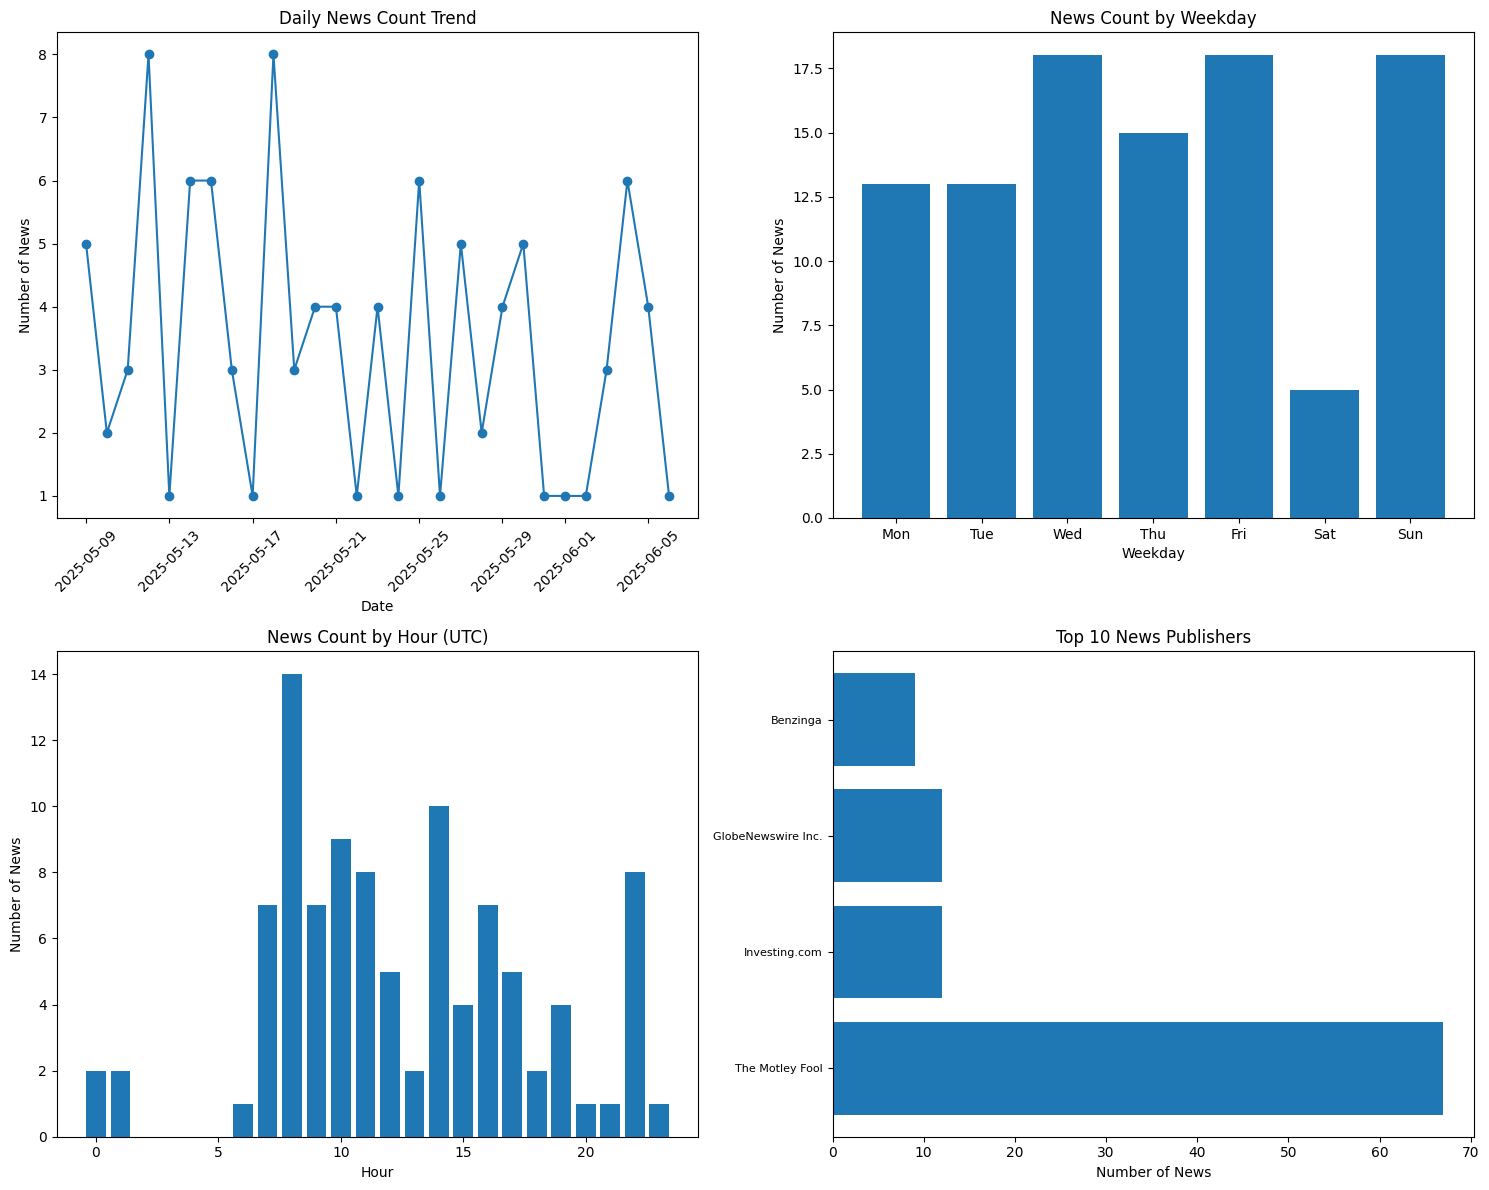

데이터가 aapl_news_dates.csv 파일로 저장되었습니다.

분석이 완료되었습니다!


In [3]:
import requests
import pandas as pd
from datetime import datetime, timezone
import pytz
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def fetch_aapl_news_dates(api_key, limit=100):
    """
    Polygon.io API에서 AAPL 관련 뉴스를 가져와서 날짜 정보를 추출합니다.
    
    Args:
        api_key (str): Polygon.io API 키
        limit (int): 가져올 뉴스 개수 (기본값: 100)
    
    Returns:
        pd.DataFrame: 뉴스 날짜 정보가 포함된 데이터프레임
    """
    
    # API 엔드포인트
    url = "https://api.polygon.io/v2/reference/news"
    
    # 파라미터 설정
    params = {
        'order': 'desc',
        'limit': limit,
        'sort': 'published_utc',
        'apiKey': api_key,
        'ticker': 'AAPL'
    }
    
    try:
        # API 호출
        response = requests.get(url, params=params)
        response.raise_for_status()
        
        data = response.json()
        
        if 'results' not in data:
            print("API 응답에 results가 없습니다.")
            return pd.DataFrame()
        
        # 뉴스 데이터 추출
        news_list = []
        for article in data['results']:
            news_info = {
                'title': article.get('title', ''),
                'author': article.get('author', ''),
                'publisher': article.get('publisher', {}).get('name', ''),
                'published_utc': article.get('published_utc', ''),
                'article_url': article.get('article_url', ''),
                'tickers': article.get('tickers', [])
            }
            news_list.append(news_info)
        
        # 데이터프레임 생성
        df = pd.DataFrame(news_list)
        
        if not df.empty:
            # 날짜 컬럼 파싱
            df['published_datetime'] = pd.to_datetime(df['published_utc'])
            df['published_date'] = df['published_datetime'].dt.date
            df['published_time'] = df['published_datetime'].dt.time
            
            # 한국 시간으로 변환
            kst = pytz.timezone('Asia/Seoul')
            df['published_kst'] = df['published_datetime'].dt.tz_convert(kst)
            df['published_date_kst'] = df['published_kst'].dt.date
            df['published_time_kst'] = df['published_kst'].dt.time
            
            # 요일 추가
            df['weekday'] = df['published_datetime'].dt.day_name()
            df['weekday_kst'] = df['published_kst'].dt.day_name()
        
        return df
        
    except requests.exceptions.RequestException as e:
        print(f"API 요청 오류: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"데이터 처리 오류: {e}")
        return pd.DataFrame()

def analyze_news_dates(df):
    """
    뉴스 날짜 데이터를 분석하고 시각화합니다.
    
    Args:
        df (pd.DataFrame): 뉴스 데이터프레임
    """
    
    if df.empty:
        print("분석할 데이터가 없습니다.")
        return
    
    print("=" * 60)
    print("AAPL 뉴스 날짜 분석 리포트")
    print("=" * 60)
    
    # 기본 통계
    total_news = len(df)
    date_range = (df['published_date'].max() - df['published_date'].min()).days + 1
    avg_per_day = total_news / date_range
    
    print(f"📊 기본 정보:")
    print(f"   총 뉴스 개수: {total_news}개")
    print(f"   분석 기간: {df['published_date'].min()} ~ {df['published_date'].max()}")
    print(f"   전체 기간: {date_range}일")
    print(f"   일평균 뉴스: {avg_per_day:.1f}개/일")
    
    # 월별 분석
    print(f"\n📅 월별 뉴스 현황:")
    monthly_counts = df.groupby(df['published_datetime'].dt.to_period('M')).size()
    for month, count in monthly_counts.items():
        percentage = (count / total_news) * 100
        print(f"   {month}: {count}개 ({percentage:.1f}%)")
    
    # 일별 분석 (최근 2주)
    print(f"\n📈 최근 2주 일별 현황:")
    daily_counts = df.groupby('published_date').size().sort_index(ascending=False)
    
    for date, count in daily_counts.head(14).items():
        weekday = df[df['published_date'] == date]['weekday'].iloc[0][:3]
        bar = "▪" * count
        print(f"   {date} ({weekday}): {count}개 {bar}")
    
    # 요일별 분석
    print(f"\n📊 요일별 평균 뉴스:")
    weekday_counts = df.groupby('weekday').size()
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    for day in weekday_order:
        if day in weekday_counts:
            count = weekday_counts[day]
            avg = count / (date_range / 7)  # 주간 평균
            print(f"   {day[:3]}: {count}개 (평균 {avg:.1f}개/주)")
    
    # 시간대별 분석 (UTC 기준)
    print(f"\n⏰ 시간대별 분석 (UTC):")
    df['hour'] = df['published_datetime'].dt.hour
    hourly_counts = df.groupby('hour').size()
    
    # 가장 활발한 시간대 상위 5개
    top_hours = hourly_counts.nlargest(5)
    for hour, count in top_hours.items():
        print(f"   {hour:02d}:00-{hour:02d}:59: {count}개")
    
    # 출처별 분석
    print(f"\n📰 주요 출처:")
    publisher_counts = df['publisher'].value_counts().head(5)
    for publisher, count in publisher_counts.items():
        percentage = (count / total_news) * 100
        print(f"   {publisher}: {count}개 ({percentage:.1f}%)")

def create_visualizations(df):
    """
    뉴스 데이터의 시각화를 생성합니다.
    
    Args:
        df (pd.DataFrame): 뉴스 데이터프레임
    """
    
    if df.empty:
        print("시각화할 데이터가 없습니다.")
        return
    
    # 한글 폰트 설정 (선택사항)
    plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial']
    
    # 1. 일별 뉴스 개수
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 일별 뉴스 트렌드
    daily_counts = df.groupby('published_date').size()
    axes[0, 0].plot(daily_counts.index, daily_counts.values, marker='o')
    axes[0, 0].set_title('Daily News Count Trend')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Number of News')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 요일별 뉴스 개수
    weekday_counts = df.groupby('weekday').size()
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_data = [weekday_counts.get(day, 0) for day in weekday_order]
    
    axes[0, 1].bar(range(len(weekday_order)), weekday_data)
    axes[0, 1].set_title('News Count by Weekday')
    axes[0, 1].set_xlabel('Weekday')
    axes[0, 1].set_ylabel('Number of News')
    axes[0, 1].set_xticks(range(len(weekday_order)))
    axes[0, 1].set_xticklabels([day[:3] for day in weekday_order])
    
    # 시간대별 뉴스 개수
    df['hour'] = df['published_datetime'].dt.hour
    hourly_counts = df.groupby('hour').size()
    axes[1, 0].bar(hourly_counts.index, hourly_counts.values)
    axes[1, 0].set_title('News Count by Hour (UTC)')
    axes[1, 0].set_xlabel('Hour')
    axes[1, 0].set_ylabel('Number of News')
    
    # 출처별 뉴스 개수 (상위 10개)
    publisher_counts = df['publisher'].value_counts().head(10)
    axes[1, 1].barh(range(len(publisher_counts)), publisher_counts.values)
    axes[1, 1].set_title('Top 10 News Publishers')
    axes[1, 1].set_xlabel('Number of News')
    axes[1, 1].set_yticks(range(len(publisher_counts)))
    axes[1, 1].set_yticklabels(publisher_counts.index, fontsize=8)
    
    plt.tight_layout()
    plt.show()

def export_to_csv(df, filename="aapl_news_dates.csv"):
    """
    데이터를 CSV 파일로 내보냅니다.
    
    Args:
        df (pd.DataFrame): 뉴스 데이터프레임
        filename (str): 저장할 파일명
    """
    
    if df.empty:
        print("내보낼 데이터가 없습니다.")
        return
    
    # 필요한 컬럼만 선택해서 내보내기
    export_df = df[['title', 'author', 'publisher', 'published_utc', 
                   'published_date', 'published_time', 'weekday', 
                   'published_date_kst', 'published_time_kst', 'article_url']]
    
    export_df.to_csv(filename, index=False, encoding='utf-8')
    print(f"데이터가 {filename} 파일로 저장되었습니다.")

def main():
    """
    메인 실행 함수
    """
    
    # API 키 설정 (실제 사용시 여기에 본인의 API 키를 입력하세요)
    API_KEY = "C2U8hupa3Hghwefp_r07iW_kwIrEDDHw"  # 예시 키
    
    print("AAPL 뉴스 데이터를 가져오는 중...")
    
    # 뉴스 데이터 가져오기
    df = fetch_aapl_news_dates(API_KEY, limit=100)
    
    if df.empty:
        print("데이터를 가져올 수 없습니다. API 키와 네트워크 연결을 확인하세요.")
        return
    
    # 데이터 분석
    analyze_news_dates(df)
    
    # 시각화 (선택사항)
    try:
        create_visualizations(df)
    except Exception as e:
        print(f"시각화 생성 중 오류: {e}")
    
    # CSV 파일로 내보내기 (선택사항)
    try:
        export_to_csv(df)
    except Exception as e:
        print(f"CSV 내보내기 중 오류: {e}")
    
    print("\n분석이 완료되었습니다!")

if __name__ == "__main__":
    main()


In [5]:
import requests
import pandas as pd
from datetime import datetime, timezone, date
import pytz
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def fetch_aapl_news_with_sentiment(api_key, start_date=None, end_date=None, limit=100):
    """
    Polygon.io API에서 AAPL 관련 뉴스를 날짜 범위를 지정하여 가져와서 센티먼트 정보를 추출합니다.
    
    Args:
        api_key (str): Polygon.io API 키
        start_date (str or datetime): 시작 날짜 (YYYY-MM-DD 형식 또는 datetime 객체)
        end_date (str or datetime): 종료 날짜 (YYYY-MM-DD 형식 또는 datetime 객체)
        limit (int): 가져올 뉴스 개수 (기본값: 100)
    
    Returns:
        pd.DataFrame: 뉴스 날짜 및 센티먼트 정보가 포함된 데이터프레임
    """
    
    # API 엔드포인트
    url = "https://api.polygon.io/v2/reference/news"
    
    # 기본 파라미터 설정
    params = {
        'order': 'desc',
        'limit': limit,
        'sort': 'published_utc',
        'apiKey': api_key,
        'ticker': 'AAPL'
    }
    
    # 날짜 범위 파라미터 추가
    if start_date:
        start_iso = convert_to_iso_format(start_date)
        params['published_utc.gte'] = start_iso
        print(f"📅 시작 날짜: {start_iso}")
    
    if end_date:
        end_iso = convert_to_iso_format(end_date, is_end_date=True)
        params['published_utc.lte'] = end_iso
        print(f"📅 종료 날짜: {end_iso}")
    
    if not start_date and not end_date:
        print("📅 날짜 범위: 제한 없음 (최신 뉴스부터)")
    
    try:
        # API 호출
        print(f"🔍 API 호출 중... (limit: {limit})")
        response = requests.get(url, params=params)
        response.raise_for_status()
        
        data = response.json()
        
        if 'results' not in data:
            print("API 응답에 results가 없습니다.")
            return pd.DataFrame()
        
        print(f"✅ {len(data['results'])}개의 뉴스를 가져왔습니다.")
        
        # 뉴스 데이터 추출
        news_list = []
        for article in data['results']:
            # 기본 뉴스 정보
            news_info = {
                'id': article.get('id', ''),
                'title': article.get('title', ''),
                'author': article.get('author', ''),
                'publisher': article.get('publisher', {}).get('name', ''),
                'published_utc': article.get('published_utc', ''),
                'article_url': article.get('article_url', ''),
                'description': article.get('description', ''),
                'keywords': ', '.join(article.get('keywords', [])),
                'tickers': ', '.join(article.get('tickers', []))
            }
            
            # AAPL 관련 센티먼트 정보 추출
            insights = article.get('insights', [])
            aapl_sentiment = None
            aapl_sentiment_reasoning = None
            
            for insight in insights:
                if insight.get('ticker') == 'AAPL':
                    aapl_sentiment = insight.get('sentiment', 'neutral')
                    aapl_sentiment_reasoning = insight.get('sentiment_reasoning', '')
                    break
            
            # 센티먼트 정보가 없는 경우 기본값 설정
            if aapl_sentiment is None:
                aapl_sentiment = 'neutral'
                aapl_sentiment_reasoning = 'No specific sentiment analysis available'
            
            news_info['aapl_sentiment'] = aapl_sentiment
            news_info['aapl_sentiment_reasoning'] = aapl_sentiment_reasoning
            
            # 다른 ticker들의 센티먼트도 수집 (참고용)
            other_sentiments = []
            for insight in insights:
                if insight.get('ticker') != 'AAPL':
                    other_sentiments.append(f"{insight.get('ticker', '')}:{insight.get('sentiment', 'neutral')}")
            
            news_info['other_tickers_sentiment'] = ', '.join(other_sentiments)
            
            news_list.append(news_info)
        
        # 데이터프레임 생성
        df = pd.DataFrame(news_list)
        
        if not df.empty:
            # 날짜 컬럼 파싱
            df['published_datetime'] = pd.to_datetime(df['published_utc'])
            df['published_date'] = df['published_datetime'].dt.date
            df['published_time'] = df['published_datetime'].dt.time
            
            # 한국 시간으로 변환
            kst = pytz.timezone('Asia/Seoul')
            df['published_kst'] = df['published_datetime'].dt.tz_convert(kst)
            df['published_date_kst'] = df['published_kst'].dt.date
            df['published_time_kst'] = df['published_kst'].dt.time
            
            # 요일 추가
            df['weekday'] = df['published_datetime'].dt.day_name()
            df['weekday_kst'] = df['published_kst'].dt.day_name()
            
            # 월, 년도 정보 추가
            df['year'] = df['published_datetime'].dt.year
            df['month'] = df['published_datetime'].dt.month
            df['year_month'] = df['published_datetime'].dt.to_period('M')
        
        return df
        
    except requests.exceptions.RequestException as e:
        print(f"API 요청 오류: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"데이터 처리 오류: {e}")
        return pd.DataFrame()

def convert_to_iso_format(date_input, is_end_date=False):
    """
    다양한 날짜 형식을 ISO 8601 형식으로 변환합니다.
    
    Args:
        date_input (str or datetime): 변환할 날짜
        is_end_date (bool): 종료 날짜인 경우 시간을 23:59:59로 설정
    
    Returns:
        str: ISO 8601 형식의 날짜 문자열
    """
    
    if isinstance(date_input, str):
        # 문자열인 경우 datetime으로 변환
        try:
            if 'T' in date_input:
                # 이미 ISO 형식인 경우
                dt = datetime.fromisoformat(date_input.replace('Z', '+00:00'))
            else:
                # YYYY-MM-DD 형식인 경우
                dt = datetime.strptime(date_input, '%Y-%m-%d')
                if is_end_date:
                    dt = dt.replace(hour=23, minute=59, second=59)
                dt = dt.replace(tzinfo=timezone.utc)
        except ValueError:
            print(f"날짜 형식 오류: {date_input}. YYYY-MM-DD 형식을 사용하세요.")
            return None
    elif isinstance(date_input, datetime):
        dt = date_input
        if dt.tzinfo is None:
            dt = dt.replace(tzinfo=timezone.utc)
    elif isinstance(date_input, date):
        dt = datetime.combine(date_input, datetime.min.time())
        if is_end_date:
            dt = dt.replace(hour=23, minute=59, second=59)
        dt = dt.replace(tzinfo=timezone.utc)
    else:
        print(f"지원하지 않는 날짜 형식: {type(date_input)}")
        return None
    
    return dt.isoformat().replace('+00:00', 'Z')

def get_date_range_presets():
    """
    미리 정의된 날짜 범위 프리셋을 반환합니다.
    
    Returns:
        dict: 날짜 범위 프리셋 딕셔너리
    """
    
    now = datetime.now(timezone.utc)
    today = now.date()
    
    presets = {
        '1': {
            'name': '2024년 전체',
            'start_date': '2024-01-01',
            'end_date': '2024-12-31'
        },
        '2': {
            'name': '2024년 1월 1일부터 현재까지',
            'start_date': '2024-01-01',
            'end_date': today.isoformat()
        },
        '3': {
            'name': '최근 30일',
            'start_date': (today - pd.Timedelta(days=30)).strftime('%Y-%m-%d'),
            'end_date': today.isoformat()
        },
        '4': {
            'name': '최근 90일',
            'start_date': (today - pd.Timedelta(days=90)).strftime('%Y-%m-%d'),
            'end_date': today.isoformat()
        },
        '5': {
            'name': '2025년 현재까지',
            'start_date': '2025-01-01',
            'end_date': today.isoformat()
        },
        '6': {
            'name': '사용자 정의',
            'start_date': None,
            'end_date': None
        }
    }
    
    return presets

def get_user_date_range():
    """
    사용자로부터 날짜 범위를 입력받습니다.
    
    Returns:
        tuple: (start_date, end_date)
    """
    
    presets = get_date_range_presets()
    
    print("\n📅 날짜 범위 선택:")
    print("=" * 40)
    
    for key, preset in presets.items():
        print(f"{key}. {preset['name']}")
        if preset['start_date'] and preset['end_date']:
            print(f"   ({preset['start_date']} ~ {preset['end_date']})")
        print()
    
    while True:
        choice = input("선택하세요 (1-6): ").strip()
        
        if choice in presets:
            preset = presets[choice]
            
            if choice == '6':  # 사용자 정의
                print("\n사용자 정의 날짜 범위:")
                start_date = input("시작 날짜 (YYYY-MM-DD, 예: 2024-01-01): ").strip()
                end_date = input("종료 날짜 (YYYY-MM-DD, 예: 2024-12-31): ").strip()
                
                if not start_date:
                    start_date = None
                if not end_date:
                    end_date = None
                    
                return start_date, end_date
            else:
                return preset['start_date'], preset['end_date']
        else:
            print("올바른 번호를 선택하세요 (1-6)")

def analyze_sentiment_trends(df):
    """
    센티먼트 트렌드를 분석합니다.
    
    Args:
        df (pd.DataFrame): 뉴스 데이터프레임
    """
    
    if df.empty:
        print("분석할 데이터가 없습니다.")
        return
    
    print("📊 AAPL 센티먼트 분석")
    print("=" * 50)
    
    # 전체 센티먼트 분포
    sentiment_counts = df['aapl_sentiment'].value_counts()
    total_news = len(df)
    
    print(f"💭 전체 센티먼트 분포:")
    for sentiment, count in sentiment_counts.items():
        percentage = (count / total_news) * 100
        emoji = get_sentiment_emoji(sentiment)
        print(f"   {emoji} {sentiment.capitalize()}: {count}개 ({percentage:.1f}%)")
    
    # 월별 센티먼트 트렌드 (데이터가 여러 달에 걸쳐 있는 경우)
    if df['year_month'].nunique() > 1:
        print(f"\n📈 월별 센티먼트 트렌드:")
        monthly_sentiment = df.groupby(['year_month', 'aapl_sentiment']).size().unstack(fill_value=0)
        
        for month, row in monthly_sentiment.iterrows():
            total_month = row.sum()
            sentiment_summary = []
            
            for sentiment in ['positive', 'neutral', 'negative']:
                if sentiment in row and row[sentiment] > 0:
                    count = row[sentiment]
                    pct = (count / total_month) * 100
                    emoji = get_sentiment_emoji(sentiment)
                    sentiment_summary.append(f"{emoji}{count}({pct:.0f}%)")
            
            print(f"   {month}: {' | '.join(sentiment_summary)} (총 {total_month}개)")
    
    # 최근 일별 센티먼트 트렌드
    display_days = min(14, df['published_date'].nunique())
    print(f"\n📈 최근 {display_days}일 센티먼트 트렌드:")
    daily_sentiment = df.groupby(['published_date', 'aapl_sentiment']).size().unstack(fill_value=0)
    
    # 최근 일정 기간만 표시
    recent_days = daily_sentiment.tail(display_days)
    
    for date, row in recent_days.iterrows():
        total_day = row.sum()
        sentiment_summary = []
        
        for sentiment in ['positive', 'neutral', 'negative']:
            if sentiment in row and row[sentiment] > 0:
                count = row[sentiment]
                pct = (count / total_day) * 100
                emoji = get_sentiment_emoji(sentiment)
                sentiment_summary.append(f"{emoji}{count}({pct:.0f}%)")
        
        print(f"   {date}: {' | '.join(sentiment_summary)} (총 {total_day}개)")
    
    # 요일별 센티먼트
    print(f"\n📅 요일별 평균 센티먼트:")
    weekday_sentiment = df.groupby(['weekday', 'aapl_sentiment']).size().unstack(fill_value=0)
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    for day in weekday_order:
        if day in weekday_sentiment.index:
            row = weekday_sentiment.loc[day]
            total_day = row.sum()
            if total_day > 0:
                pos_pct = (row.get('positive', 0) / total_day) * 100
                neg_pct = (row.get('negative', 0) / total_day) * 100
                neu_pct = (row.get('neutral', 0) / total_day) * 100
                print(f"   {day[:3]}: 😊{pos_pct:.0f}% | 😐{neu_pct:.0f}% | 😞{neg_pct:.0f}% (총 {total_day}개)")

def get_sentiment_emoji(sentiment):
    """
    센티먼트에 따른 이모지 반환
    """
    emoji_map = {
        'positive': '😊',
        'negative': '😞', 
        'neutral': '😐'
    }
    return emoji_map.get(sentiment.lower(), '😐')

def analyze_news_dates_with_sentiment(df):
    """
    뉴스 날짜 데이터를 센티먼트와 함께 분석합니다.
    
    Args:
        df (pd.DataFrame): 뉴스 데이터프레임
    """
    
    if df.empty:
        print("분석할 데이터가 없습니다.")
        return
    
    print("=" * 60)
    print("AAPL 뉴스 날짜 & 센티먼트 분석 리포트")
    print("=" * 60)
    
    # 기본 통계
    total_news = len(df)
    date_range = (df['published_date'].max() - df['published_date'].min()).days + 1
    avg_per_day = total_news / date_range
    
    print(f"📊 기본 정보:")
    print(f"   총 뉴스 개수: {total_news}개")
    print(f"   분석 기간: {df['published_date'].min()} ~ {df['published_date'].max()}")
    print(f"   전체 기간: {date_range}일")
    print(f"   일평균 뉴스: {avg_per_day:.1f}개/일")
    
    # 센티먼트 분석
    analyze_sentiment_trends(df)
    
    # 연도별 분석 (여러 해에 걸쳐 있는 경우)
    if df['year'].nunique() > 1:
        print(f"\n📅 연도별 뉴스 현황:")
        yearly_counts = df.groupby('year').size()
        for year, count in yearly_counts.items():
            percentage = (count / total_news) * 100
            print(f"   {year}년: {count}개 ({percentage:.1f}%)")
    
    # 월별 분석
    print(f"\n📅 월별 뉴스 현황:")
    monthly_counts = df.groupby('year_month').size()
    for month, count in monthly_counts.items():
        percentage = (count / total_news) * 100
        print(f"   {month}: {count}개 ({percentage:.1f}%)")
    
    # 최근 긍정/부정 뉴스 샘플
    print(f"\n📝 최근 긍정적 뉴스 샘플:")
    positive_news = df[df['aapl_sentiment'] == 'positive'].head(3)
    for idx, news in positive_news.iterrows():
        print(f"   😊 {news['published_date']}: {news['title'][:80]}...")
    
    print(f"\n📝 최근 부정적 뉴스 샘플:")
    negative_news = df[df['aapl_sentiment'] == 'negative'].head(3)
    for idx, news in negative_news.iterrows():
        print(f"   😞 {news['published_date']}: {news['title'][:80]}...")

def create_sentiment_visualizations(df):
    """
    센티먼트가 포함된 뉴스 데이터의 시각화를 생성합니다.
    
    Args:
        df (pd.DataFrame): 뉴스 데이터프레임
    """
    
    if df.empty:
        print("시각화할 데이터가 없습니다.")
        return
    
    # 한글 폰트 설정
    plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial']
    
    # 데이터 기간에 따라 시각화 조정
    date_range_days = (df['published_date'].max() - df['published_date'].min()).days
    
    if date_range_days > 90:
        # 긴 기간인 경우 월별 차트 추가
        fig, axes = plt.subplots(3, 2, figsize=(18, 16))
    else:
        # 짧은 기간인 경우 기본 차트
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 색상 설정
    sentiment_colors = {'positive': '#2E8B57', 'neutral': '#FFD700', 'negative': '#DC143C'}
    
    # 1. 전체 센티먼트 분포 (파이 차트)
    sentiment_counts = df['aapl_sentiment'].value_counts()
    colors = [sentiment_colors.get(sent, '#808080') for sent in sentiment_counts.index]
    axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
                   colors=colors, startangle=90)
    axes[0, 0].set_title('Overall AAPL Sentiment Distribution')
    
    # 2. 일별 센티먼트 스택 차트
    daily_sentiment = df.groupby(['published_date', 'aapl_sentiment']).size().unstack(fill_value=0)
    
    # 데이터가 많은 경우 샘플링
    if len(daily_sentiment) > 30:
        daily_sentiment = daily_sentiment.iloc[::len(daily_sentiment)//30]
    
    daily_sentiment.plot(kind='bar', stacked=True, ax=axes[0, 1], 
                        color=[sentiment_colors.get(col, '#808080') for col in daily_sentiment.columns])
    axes[0, 1].set_title('Daily Sentiment Trends')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Number of News')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].legend(title='Sentiment')
    
    # 3. 요일별 센티먼트
    weekday_sentiment = df.groupby(['weekday', 'aapl_sentiment']).size().unstack(fill_value=0)
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # 요일 순서대로 정렬
    weekday_sentiment = weekday_sentiment.reindex(weekday_order, fill_value=0)
    weekday_sentiment.plot(kind='bar', ax=axes[1, 0], 
                          color=[sentiment_colors.get(col, '#808080') for col in weekday_sentiment.columns])
    axes[1, 0].set_title('Sentiment by Weekday')
    axes[1, 0].set_xlabel('Weekday')
    axes[1, 0].set_ylabel('Number of News')
    axes[1, 0].set_xticklabels([day[:3] for day in weekday_order], rotation=45)
    axes[1, 0].legend(title='Sentiment')
    
    # 4. 시간대별 센티먼트
    df['hour'] = df['published_datetime'].dt.hour
    hourly_sentiment = df.groupby(['hour', 'aapl_sentiment']).size().unstack(fill_value=0)
    hourly_sentiment.plot(kind='bar', ax=axes[1, 1], 
                         color=[sentiment_colors.get(col, '#808080') for col in hourly_sentiment.columns])
    axes[1, 1].set_title('Sentiment by Hour (UTC)')
    axes[1, 1].set_xlabel('Hour')
    axes[1, 1].set_ylabel('Number of News')
    axes[1, 1].legend(title='Sentiment')
    
    if date_range_days > 90:
        # 5. 월별 센티먼트 트렌드 (장기간 데이터)
        monthly_sentiment = df.groupby(['year_month', 'aapl_sentiment']).size().unstack(fill_value=0)
        monthly_sentiment.plot(kind='bar', ax=axes[2, 0], 
                              color=[sentiment_colors.get(col, '#808080') for col in monthly_sentiment.columns])
        axes[2, 0].set_title('Monthly Sentiment Trends')
        axes[2, 0].set_xlabel('Year-Month')
        axes[2, 0].set_ylabel('Number of News')
        axes[2, 0].tick_params(axis='x', rotation=45)
        axes[2, 0].legend(title='Sentiment')
        
        # 6. 출처별 센티먼트 (간소화)
        top_publishers = df['publisher'].value_counts().head(5).index
        publisher_sentiment = df[df['publisher'].isin(top_publishers)].groupby(['publisher', 'aapl_sentiment']).size().unstack(fill_value=0)
        publisher_sentiment_pct = publisher_sentiment.div(publisher_sentiment.sum(axis=1), axis=0) * 100
        publisher_sentiment_pct.plot(kind='barh', stacked=True, ax=axes[2, 1], 
                                    color=[sentiment_colors.get(col, '#808080') for col in publisher_sentiment_pct.columns])
        axes[2, 1].set_title('Top 5 Publishers Sentiment (%)')
        axes[2, 1].set_xlabel('Percentage')
        axes[2, 1].legend(title='Sentiment')
    else:
        # 5. 출처별 센티먼트 비율
        top_publishers = df['publisher'].value_counts().head(8).index
        publisher_sentiment = df[df['publisher'].isin(top_publishers)].groupby(['publisher', 'aapl_sentiment']).size().unstack(fill_value=0)
        
        # 비율로 변환
        publisher_sentiment_pct = publisher_sentiment.div(publisher_sentiment.sum(axis=1), axis=0) * 100
        publisher_sentiment_pct.plot(kind='barh', stacked=True, ax=axes[1, 2], 
                                    color=[sentiment_colors.get(col, '#808080') for col in publisher_sentiment_pct.columns])
        axes[1, 2].set_title('Sentiment Distribution by Publisher (%)')
        axes[1, 2].set_xlabel('Percentage')
        axes[1, 2].legend(title='Sentiment')
    
    plt.tight_layout()
    plt.show()

def export_to_csv_with_sentiment(df, filename=None):
    """
    센티먼트 정보가 포함된 데이터를 CSV 파일로 내보냅니다.
    
    Args:
        df (pd.DataFrame): 뉴스 데이터프레임
        filename (str): 저장할 파일명 (None인 경우 자동 생성)
    """
    
    if df.empty:
        print("내보낼 데이터가 없습니다.")
        return
    
    # 파일명 자동 생성
    if filename is None:
        start_date = df['published_date'].min().strftime('%Y%m%d')
        end_date = df['published_date'].max().strftime('%Y%m%d')
        filename = f"aapl_news_sentiment_{start_date}_to_{end_date}.csv"
    
    # 모든 컬럼 포함해서 내보내기
    export_df = df.copy()
    
    # 컬럼 순서 정리
    column_order = [
        'title', 'aapl_sentiment', 'aapl_sentiment_reasoning',
        'author', 'publisher', 'published_utc', 'published_date', 'published_time',
        'published_date_kst', 'published_time_kst', 'weekday', 'year', 'month',
        'description', 'keywords', 'tickers', 'other_tickers_sentiment', 'article_url'
    ]
    
    # 존재하는 컬럼만 선택
    available_columns = [col for col in column_order if col in export_df.columns]
    export_df = export_df[available_columns]
    
    export_df.to_csv(filename, index=False, encoding='utf-8')
    print(f"센티먼트 데이터가 {filename} 파일로 저장되었습니다.")

def get_sentiment_summary(df):
    """
    센티먼트 요약 정보를 반환합니다.
    
    Args:
        df (pd.DataFrame): 뉴스 데이터프레임
    
    Returns:
        dict: 센티먼트 요약 정보
    """
    
    if df.empty:
        return {}
    
    sentiment_counts = df['aapl_sentiment'].value_counts()
    total = len(df)
    
    summary = {
        'total_news': total,
        'positive_count': sentiment_counts.get('positive', 0),
        'negative_count': sentiment_counts.get('negative', 0),
        'neutral_count': sentiment_counts.get('neutral', 0),
        'positive_percentage': (sentiment_counts.get('positive', 0) / total) * 100,
        'negative_percentage': (sentiment_counts.get('negative', 0) / total) * 100,
        'neutral_percentage': (sentiment_counts.get('neutral', 0) / total) * 100,
        'sentiment_score': (sentiment_counts.get('positive', 0) - sentiment_counts.get('negative', 0)) / total
    }
    
    return summary

def main_interactive():
    """
    대화형 메인 실행 함수
    """
    
    print("🍎 AAPL 뉴스 센티먼트 분석기")
    print("=" * 50)
    
    # API 키 설정 (실제 사용시 여기에 본인의 API 키를 입력하세요)
    API_KEY = "C2U8hupa3Hghwefp_r07iW_kwIrEDDHw"  # 예시 키
    
    # 날짜 범위 선택
    start_date, end_date = get_user_date_range()
    
    # 뉴스 개수 설정
    print(f"\n📄 가져올 뉴스 개수:")
    limit_input = input("뉴스 개수 (기본값: 100, 최대: 1000): ").strip()
    limit = int(limit_input) if limit_input.isdigit() else 100
    limit = min(limit, 1000)  # API 제한
    
    print(f"\n🔍 AAPL 뉴스 데이터를 가져오는 중...")
    
    # 뉴스 데이터 가져오기
    df = fetch_aapl_news_with_sentiment(API_KEY, start_date, end_date, limit)
    
    if df.empty:
        print("❌ 데이터를 가져올 수 없습니다.")
        print("   - API 키를 확인하세요")
        print("   - 네트워크 연결을 확인하세요")
        print("   - 날짜 범위를 확인하세요")
        return
    
    print(f"✅ {len(df)}개의 뉴스 데이터를 성공적으로 가져왔습니다.")
    
    # 데이터 분석
    analyze_news_dates_with_sentiment(df)
    
    # 센티먼트 요약
    summary = get_sentiment_summary(df)
    print(f"\n🎯 센티먼트 스코어: {summary.get('sentiment_score', 0):.3f}")
    print(f"   (1에 가까울수록 긍정적, -1에 가까울수록 부정적)")
    
    # 추가 작업 선택
    while True:
        print(f"\n🔧 추가 작업을 선택하세요:")
        print("1. 시각화 생성")
        print("2. CSV 파일로 내보내기")
        print("3. 종료")
        
        choice = input("선택 (1-3): ").strip()
        
        if choice == '1':
            try:
                create_sentiment_visualizations(df)
            except Exception as e:
                print(f"❌ 시각화 생성 중 오류: {e}")
        elif choice == '2':
            try:
                export_to_csv_with_sentiment(df)
            except Exception as e:
                print(f"❌ CSV 내보내기 중 오류: {e}")
        elif choice == '3':
            break
        else:
            print("올바른 번호를 선택하세요 (1-3)")
    
    print("\n✅ 분석이 완료되었습니다!")

def main_programmatic(api_key, start_date='2024-01-01', end_date=None, limit=100):
    """
    프로그래밍 방식 메인 함수 (스크립트에서 직접 호출용)
    
    Args:
        api_key (str): Polygon.io API 키
        start_date (str): 시작 날짜 (YYYY-MM-DD)
        end_date (str): 종료 날짜 (YYYY-MM-DD, None인 경우 현재 날짜)
        limit (int): 가져올 뉴스 개수
    
    Returns:
        pd.DataFrame: 분석된 뉴스 데이터
    """
    
    print(f"🍎 AAPL 뉴스 센티먼트 분석 시작")
    
    # 뉴스 데이터 가져오기
    df = fetch_aapl_news_with_sentiment(api_key, start_date, end_date, limit)
    
    if df.empty:
        print("❌ 데이터를 가져올 수 없습니다.")
        return pd.DataFrame()
    
    # 데이터 분석
    analyze_news_dates_with_sentiment(df)
    
    # 센티먼트 요약
    summary = get_sentiment_summary(df)
    print(f"\n🎯 센티먼트 스코어: {summary.get('sentiment_score', 0):.3f}")
    
    return df

if __name__ == "__main__":
    # 대화형 모드로 실행
    main_interactive()
    
    # 또는 프로그래밍 방식으로 직접 호출:
    # df = main_programmatic(
    #     api_key="YOUR_API_KEY",
    #     start_date="2024-01-01",
    #     end_date="2024-12-31",
    #     limit=500
    # )

# 사용 예시:
# 1. 필요한 라이브러리 설치:
# pip install requests pandas matplotlib seaborn pytz

# 2. 실행 방법:
# python aapl_news_sentiment_analyzer.py  # 대화형 모드
# 
# 또는 스크립트에서:
# from aapl_news_sentiment_analyzer import main_programmatic
# df = main_programmatic("YOUR_API_KEY", "2024-01-01", "2024-12-31", 200)

🍎 AAPL 뉴스 센티먼트 분석기

📅 날짜 범위 선택:
1. 2024년 전체
   (2024-01-01 ~ 2024-12-31)

2. 2024년 1월 1일부터 현재까지
   (2024-01-01 ~ 2025-06-06)

3. 최근 30일
   (2025-05-07 ~ 2025-06-06)

4. 최근 90일
   (2025-03-08 ~ 2025-06-06)

5. 2025년 현재까지
   (2025-01-01 ~ 2025-06-06)

6. 사용자 정의


사용자 정의 날짜 범위:

📄 가져올 뉴스 개수:

🔍 AAPL 뉴스 데이터를 가져오는 중...
📅 시작 날짜: 2024-01-01T00:00:00Z
📅 종료 날짜: 2025-05-29T23:59:59Z
🔍 API 호출 중... (limit: 1000)


C:\Users\TJ\AppData\Local\Temp\ipykernel_10756\2090418489.py:130: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['published_datetime'].dt.to_period('M')


✅ 1000개의 뉴스를 가져왔습니다.
✅ 1000개의 뉴스 데이터를 성공적으로 가져왔습니다.
AAPL 뉴스 날짜 & 센티먼트 분석 리포트
📊 기본 정보:
   총 뉴스 개수: 1000개
   분석 기간: 2024-09-19 ~ 2025-05-29
   전체 기간: 253일
   일평균 뉴스: 4.0개/일
📊 AAPL 센티먼트 분석
💭 전체 센티먼트 분포:
   😊 Positive: 474개 (47.4%)
   😐 Neutral: 342개 (34.2%)
   😞 Negative: 184개 (18.4%)

📈 월별 센티먼트 트렌드:
   2024-09: 😊26(52%) | 😐17(34%) | 😞7(14%) (총 50개)
   2024-10: 😊61(49%) | 😐42(34%) | 😞22(18%) (총 125개)
   2024-11: 😊67(47%) | 😐52(36%) | 😞24(17%) (총 143개)
   2024-12: 😊64(59%) | 😐35(32%) | 😞10(9%) (총 109개)
   2025-01: 😊51(41%) | 😐46(37%) | 😞26(21%) (총 123개)
   2025-02: 😊47(45%) | 😐39(38%) | 😞18(17%) (총 104개)
   2025-03: 😊45(48%) | 😐28(30%) | 😞20(22%) (총 93개)
   2025-04: 😊60(46%) | 😐40(31%) | 😞30(23%) (총 130개)
   2025-05: 😊53(43%) | 😐43(35%) | 😞27(22%) (총 123개)

📈 최근 14일 센티먼트 트렌드:
   2025-05-16: 😊2(67%) | 😞1(33%) (총 3개)
   2025-05-17: 😞1(100%) (총 1개)
   2025-05-18: 😊6(75%) | 😐2(25%) (총 8개)
   2025-05-19: 😊2(67%) | 😐1(33%) (총 3개)
   2025-05-20: 😐2(50%) | 😞2(50%) (총 4개)
   2025-05-21: 😊1(25%) | 😐

In [2]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import numpy as np

# TimescaleDB 연결 설정
DB_CONFIG = {
    'host': '192.168.40.193',  # TimescaleDB 호스트
    'port': '5432',       # 포트
    'database': 'minute',  # 데이터베이스명
    'user': 'postgres',     # 사용자명
    'password': 'mysecretpassword'  # 비밀번호
}

# SQLAlchemy 엔진 생성
engine = create_engine(f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}")

stock_lists = ['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
result_lists = []

for stock_symbol in stock_lists:
    try:
        # TimescaleDB에서 데이터 조회
        # 1분봉 데이터를 일별로 집계하여 각 날의 마지막 종가 가져오기
        query = f"""
        SELECT 
            DATE(timestamp) as date,
            LAST(close, timestamp) as close
        FROM us_market_data 
        WHERE symbol = '{stock_symbol}'
        GROUP BY DATE(timestamp)
        ORDER BY date;
        """
        
        # 데이터 읽기
        df = pd.read_sql(query, engine)
        
        if df.empty:
            print(f"Warning: No data found for {stock_symbol}")
            continue
            
        # 날짜를 인덱스로 설정
        df.set_index('date', inplace=True)
        
        # 일일 수익률 계산 (퍼센트로 변환)
        df['daily_return'] = df['close'].pct_change() * 100
        
        # NaN 값이 있을 경우 제거
        df = df.dropna(subset=['daily_return'])
        
        if len(df) < 2:
            print(f"Warning: Insufficient data for {stock_symbol}")
            continue
            
        # 전체 기간에 대한 일일 수익률의 표준편차 계산
        overall_return_std = df['daily_return'].std()
        
        # 전체 기간의 평균 종가 계산
        mean_close = df['close'].mean()
        
        # 가격 변동성 계산 (표준편차 / 평균 가격 * 100)
        price_volatility = (overall_return_std / mean_close) * 100
        
        # 결과 저장
        result_lists.append({
            '주식': stock_symbol, 
            '전체 기간 일일 수익률의 표준편차': overall_return_std,
            '전체 기간 가격 변동성': price_volatility
        })
        
    except Exception as e:
        print(f"Error processing {stock_symbol}: {str(e)}")
        continue

# 결과 DataFrame 생성 및 출력
if result_lists:
    result_df = pd.DataFrame(result_lists)
    print(result_df)
    
    # 결과를 TimescaleDB에 저장 (선택사항)
    try:
        result_df.to_sql('stock_volatility_analysis', engine, if_exists='replace', index=False)
        print("\n결과가 TimescaleDB의 'stock_volatility_analysis' 테이블에 저장되었습니다.")
    except Exception as e:
        print(f"결과 저장 중 오류 발생: {str(e)}")
else:
    print("처리할 수 있는 데이터가 없습니다.")

# 연결 종료
engine.dispose()


# TimescaleDB 테이블 생성 스크립트 (참고용)
"""
-- 주식 데이터 테이블 생성
CREATE TABLE IF NOT EXISTS stock_data (
    timestamp TIMESTAMPTZ NOT NULL,
    symbol TEXT NOT NULL,
    open DOUBLE PRECISION,
    high DOUBLE PRECISION,
    low DOUBLE PRECISION,
    close DOUBLE PRECISION,
    volume BIGINT
);

-- TimescaleDB 하이퍼테이블 생성
SELECT create_hypertable('stock_data', 'timestamp', if_not_exists => TRUE);

-- 인덱스 생성
CREATE INDEX IF NOT EXISTS idx_stock_symbol_time ON stock_data (symbol, timestamp DESC);

-- 분석 결과 테이블
CREATE TABLE IF NOT EXISTS stock_volatility_analysis (
    주식 TEXT PRIMARY KEY,
    전체_기간_일일_수익률의_표준편차 DOUBLE PRECISION,
    전체_기간_가격_변동성 DOUBLE PRECISION,
    분석_일시 TIMESTAMPT DEFAULT NOW()
);
"""

      주식  전체 기간 일일 수익률의 표준편차  전체 기간 가격 변동성
0   AAPL            1.783710      1.797436
1   AMZN            2.049882      1.955050
2  GOOGL            1.813730      2.129922
3   META           49.691198     18.188538
4   MSFT            1.673387      0.862568
5   NVDA            3.103237     14.293897
6   TSLA            3.643167      3.032847

결과가 TimescaleDB의 'stock_volatility_analysis' 테이블에 저장되었습니다.


"\n-- 주식 데이터 테이블 생성\nCREATE TABLE IF NOT EXISTS stock_data (\n    timestamp TIMESTAMPTZ NOT NULL,\n    symbol TEXT NOT NULL,\n    open DOUBLE PRECISION,\n    high DOUBLE PRECISION,\n    low DOUBLE PRECISION,\n    close DOUBLE PRECISION,\n    volume BIGINT\n);\n\n-- TimescaleDB 하이퍼테이블 생성\nSELECT create_hypertable('stock_data', 'timestamp', if_not_exists => TRUE);\n\n-- 인덱스 생성\nCREATE INDEX IF NOT EXISTS idx_stock_symbol_time ON stock_data (symbol, timestamp DESC);\n\n-- 분석 결과 테이블\nCREATE TABLE IF NOT EXISTS stock_volatility_analysis (\n    주식 TEXT PRIMARY KEY,\n    전체_기간_일일_수익률의_표준편차 DOUBLE PRECISION,\n    전체_기간_가격_변동성 DOUBLE PRECISION,\n    분석_일시 TIMESTAMPTZ DEFAULT NOW()\n);\n"

In [3]:
result_df

,주식,전체 기간 일일 수익률의 표준편차,전체 기간 가격 변동성
0,AAPL,1.783710,1.797436
1,AMZN,2.049882,1.955050
2,GOOGL,1.813730,2.129922
3,META,49.691198,18.188538
4,MSFT,1.673387,0.862568
5,NVDA,3.103237,14.293897
6,TSLA,3.643167,3.032847


=== Market Volatility Analysis Report ===
Analysis Period: From 2023-01-01
Generated on: 2025-06-11 10:46:04
Successfully fetched 1367691 records from database
Total records fetched: 1367691
Symbols analyzed: 7
Date range: 2023-01-03 00:00:00 to 2024-12-31 00:00:00
Calculated returns for 1367691 records (7 NaN values)
Processing AAPL: 195384 records
Processing AMZN: 195383 records
Processing GOOGL: 195383 records
Processing META: 195381 records
Processing MSFT: 195381 records
Processing NVDA: 195386 records
Processing TSLA: 195386 records
Successfully processed 7 symbols

=== Volatility Summary ===
Error calculating summary statistics: reduction operation 'argmax' not allowed for this dtype

=== Top 10 Most Volatile Stocks (Annual Volatility) ===
Error displaying top volatile stocks: Column 'annual_volatility' has dtype object, cannot use method 'nlargest' with this dtype

Results saved to market_analysis_2023_*.csv


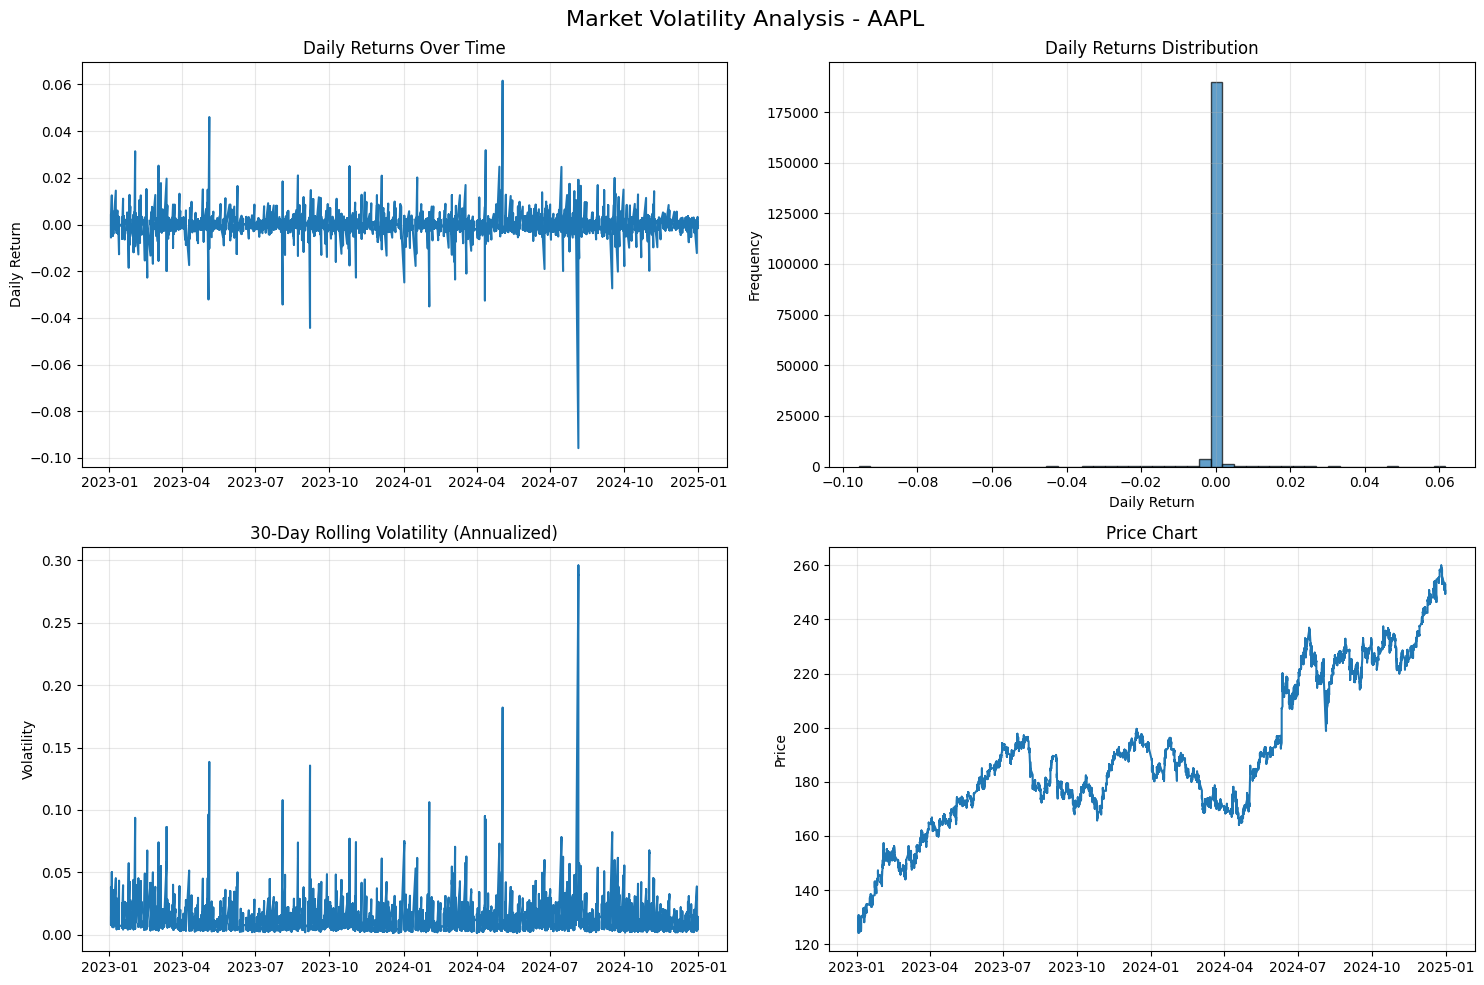

In [8]:
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class MarketVolatilityAnalyzer:
    def __init__(self, db_config):
        """
        PostgreSQL 데이터베이스 연결 설정
        
        db_config 예시:
        {
            'host': 'localhost',
            'database': 'market_db',
            'user': 'username',
            'password': 'password',
            'port': 5432
        }
        """
        self.db_config = db_config
        self.engine = self._create_connection()
        
    def _create_connection(self):
        """데이터베이스 연결 생성"""
        connection_string = f"postgresql://{self.db_config['user']}:{self.db_config['password']}@{self.db_config['host']}:{self.db_config['port']}/{self.db_config['database']}"
        return create_engine(connection_string)
    
    def fetch_market_data(self, start_date, end_date=None, symbols=None):
        """
        PostgreSQL에서 시장 데이터 가져오기
        
        Parameters:
        - start_date: 시작 날짜 ('YYYY-MM-DD' 형식)
        - end_date: 종료 날짜 (None이면 최신 데이터까지)
        - symbols: 특정 종목 리스트 (None이면 전체)
        """
        
        query = """
        SELECT 
            *
        FROM us_market_data 
        WHERE date >= %(start_date)s
        """
        
        params = {'start_date': start_date}
        
        if end_date:
            query += " AND date <= %(end_date)s"
            params['end_date'] = end_date
            
        if symbols:
            # IN 절을 위한 동적 쿼리 생성
            symbol_placeholders = ','.join([f"%(symbol_{i})s" for i in range(len(symbols))])
            query += f" AND symbol IN ({symbol_placeholders})"
            
            # 각 심볼을 개별 파라미터로 추가
            for i, symbol in enumerate(symbols):
                params[f'symbol_{i}'] = symbol
            
        query += " ORDER BY symbol, date"
        
        try:
            df = pd.read_sql_query(query, self.engine, params=params)
            df['date'] = pd.to_datetime(df['date'])
            print(f"Successfully fetched {len(df)} records from database")
            return df
        except Exception as e:
            print(f"Error fetching data: {e}")
            return pd.DataFrame()
    
    def calculate_daily_returns(self, df):
        """일일 수익률 계산"""
        if df.empty:
            print("Warning: Empty DataFrame provided to calculate_daily_returns")
            return df
            
        df = df.copy()
        df = df.sort_values(['symbol', 'date'])
        
        # 종목별로 그룹화하여 일일 수익률 계산
        df['prev_close'] = df.groupby('symbol')['close'].shift(1)
        
        # 단순 수익률 (Simple Return)
        df['daily_return'] = (df['close'] - df['prev_close']) / df['prev_close']
        
        # 로그 수익률 (Log Return)
        df['log_return'] = np.log(df['close'] / df['prev_close'])
        
        # 가격 변동폭 (High-Low Range)
        df['price_range'] = df['high'] - df['low']
        df['price_range_pct'] = df['price_range'] / df['close']
        
        # NaN 값 확인
        nan_count = df['daily_return'].isna().sum()
        print(f"Calculated returns for {len(df)} records ({nan_count} NaN values)")
        
        return df
    
    def calculate_volatility_metrics(self, df):
        """변동성 지표 계산"""
        if df.empty:
            print("Warning: Empty DataFrame provided to calculate_volatility_metrics")
            return pd.DataFrame()
            
        results = {}
        symbols_processed = 0
        
        for symbol in df['symbol'].unique():
            symbol_data = df[df['symbol'] == symbol].copy()
            symbol_data = symbol_data.dropna(subset=['daily_return'])
            
            if len(symbol_data) < 2:
                print(f"Skipping {symbol}: insufficient data ({len(symbol_data)} records)")
                continue
                
            symbols_processed += 1
            print(f"Processing {symbol}: {len(symbol_data)} records")
            
            # 기본 통계
            daily_returns = symbol_data['daily_return']
            log_returns = symbol_data['log_return']
            
            # 일일 수익률 표준편차 (변동성)
            daily_volatility = daily_returns.std()
            
            # 연간 변동성 (252 거래일 기준)
            annual_volatility = daily_volatility * np.sqrt(252)
            
            # 로그 수익률 기준 변동성
            log_volatility = log_returns.std()
            annual_log_volatility = log_volatility * np.sqrt(252)
            
            # 가격 변동성 지표들
            avg_price_range_pct = symbol_data['price_range_pct'].mean()
            
            # 추가 위험 지표
            var_95 = daily_returns.quantile(0.05)  # 5% VaR
            var_99 = daily_returns.quantile(0.01)  # 1% VaR
            
            # 최대 손실폭 (Maximum Drawdown)
            cumulative_returns = (1 + daily_returns).cumprod()
            rolling_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - rolling_max) / rolling_max
            max_drawdown = drawdown.min()
            
            # 샤프 비율 (무위험 수익률을 0으로 가정)
            sharpe_ratio = daily_returns.mean() / daily_volatility * np.sqrt(252) if daily_volatility > 0 else 0
            
            results[symbol] = {
                'symbol': symbol,
                'period_start': symbol_data['date'].min(),
                'period_end': symbol_data['date'].max(),
                'trading_days': len(symbol_data),
                
                # 수익률 통계
                'avg_daily_return': daily_returns.mean(),
                'median_daily_return': daily_returns.median(),
                'min_daily_return': daily_returns.min(),
                'max_daily_return': daily_returns.max(),
                
                # 변동성 지표
                'daily_volatility': daily_volatility,
                'annual_volatility': annual_volatility,
                'log_volatility': log_volatility,
                'annual_log_volatility': annual_log_volatility,
                
                # 가격 변동성
                'avg_price_range_pct': avg_price_range_pct,
                
                # 위험 지표
                'var_95': var_95,
                'var_99': var_99,
                'max_drawdown': max_drawdown,
                'sharpe_ratio': sharpe_ratio,
                
                # 추가 통계
                'skewness': daily_returns.skew(),
                'kurtosis': daily_returns.kurtosis()
            }
        
        print(f"Successfully processed {symbols_processed} symbols")
        
        if results:
            return pd.DataFrame(results).T
        else:
            print("Warning: No symbols were successfully processed")
            return pd.DataFrame()
    
    def plot_volatility_analysis(self, df, symbol=None):
        """변동성 분석 시각화"""
        if df.empty:
            print("Warning: Empty DataFrame provided for plotting")
            return
            
        if symbol:
            data = df[df['symbol'] == symbol].copy()
            if data.empty:
                print(f"Warning: No data found for symbol {symbol}")
                return
            title_suffix = f" - {symbol}"
        else:
            # 전체 데이터의 평균 사용
            data = df.groupby('date').agg({
                'daily_return': 'mean',
                'close': 'mean'  # 'close_price' -> 'close'로 수정
            }).reset_index()
            title_suffix = " - Market Average"
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Market Volatility Analysis{title_suffix}', fontsize=16)
        
        # 1. 일일 수익률 시계열
        axes[0, 0].plot(data['date'], data['daily_return'])
        axes[0, 0].set_title('Daily Returns Over Time')
        axes[0, 0].set_ylabel('Daily Return')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. 수익률 히스토그램
        axes[0, 1].hist(data['daily_return'].dropna(), bins=50, alpha=0.7, edgecolor='black')
        axes[0, 1].set_title('Daily Returns Distribution')
        axes[0, 1].set_xlabel('Daily Return')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. 롤링 변동성 (30일)
        rolling_vol = data['daily_return'].rolling(window=30).std() * np.sqrt(252)
        axes[1, 0].plot(data['date'], rolling_vol)
        axes[1, 0].set_title('30-Day Rolling Volatility (Annualized)')
        axes[1, 0].set_ylabel('Volatility')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. 가격 차트
        price_col = 'close' if 'close' in data.columns else 'close_price'
        if price_col in data.columns:
            axes[1, 1].plot(data['date'], data[price_col])
            axes[1, 1].set_title('Price Chart')
            axes[1, 1].set_ylabel('Price')
            axes[1, 1].grid(True, alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Price data not available', 
                           horizontalalignment='center', verticalalignment='center')
        
        plt.tight_layout()
        plt.show()
    
    def generate_report(self, start_date, symbols=None, save_to_file=None):
        """종합 변동성 분석 보고서 생성"""
        print(f"=== Market Volatility Analysis Report ===")
        print(f"Analysis Period: From {start_date}")
        print(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print("="*50)
        
        # 데이터 가져오기
        df = self.fetch_market_data(start_date, symbols=symbols)
        
        if df.empty:
            print("Error: No data was fetched from the database")
            return pd.DataFrame(), pd.DataFrame()
            
        print(f"Total records fetched: {len(df)}")
        print(f"Symbols analyzed: {df['symbol'].nunique()}")
        print(f"Date range: {df['date'].min()} to {df['date'].max()}")
        
        # 수익률 계산
        df = self.calculate_daily_returns(df)
        
        # 변동성 지표 계산
        volatility_metrics = self.calculate_volatility_metrics(df)
        
        if volatility_metrics.empty:
            print("Error: No volatility metrics could be calculated")
            return df, pd.DataFrame()
        
        # 결과 요약
        print("\n=== Volatility Summary ===")
        
        # 안전한 통계 계산
        try:
            summary_stats = {
                'Average Daily Volatility': volatility_metrics['daily_volatility'].mean(),
                'Average Annual Volatility': volatility_metrics['annual_volatility'].mean(),
            }
            
            # idxmax/idxmin을 안전하게 처리
            if len(volatility_metrics) > 0 and not volatility_metrics['annual_volatility'].isna().all():
                max_vol_idx = volatility_metrics['annual_volatility'].idxmax()
                min_vol_idx = volatility_metrics['annual_volatility'].idxmin()
                summary_stats['Highest Volatility Symbol'] = volatility_metrics.loc[max_vol_idx, 'symbol']
                summary_stats['Lowest Volatility Symbol'] = volatility_metrics.loc[min_vol_idx, 'symbol']
            
            summary_stats['Average Sharpe Ratio'] = volatility_metrics['sharpe_ratio'].mean()
            
            for key, value in summary_stats.items():
                if isinstance(value, (int, float)):
                    print(f"{key}: {value:.4f}")
                else:
                    print(f"{key}: {value}")
                    
        except Exception as e:
            print(f"Error calculating summary statistics: {e}")
        
        # 상위 변동성 종목
        try:
            print("\n=== Top 10 Most Volatile Stocks (Annual Volatility) ===")
            if len(volatility_metrics) > 0:
                top_volatile = volatility_metrics.nlargest(min(10, len(volatility_metrics)), 'annual_volatility')[
                    ['symbol', 'annual_volatility', 'sharpe_ratio']
                ]
                print(top_volatile.to_string(index=False))
            else:
                print("No volatility data available")
        except Exception as e:
            print(f"Error displaying top volatile stocks: {e}")
        
        # 파일 저장
        if save_to_file:
            try:
                volatility_metrics.to_csv(f"{save_to_file}_volatility_metrics.csv")
                df.to_csv(f"{save_to_file}_raw_data.csv", index=False)
                print(f"\nResults saved to {save_to_file}_*.csv")
            except Exception as e:
                print(f"Error saving files: {e}")
        
        return df, volatility_metrics

# 사용 예시
def main():
    # 데이터베이스 설정
    db_config = {
        'host': '192.168.40.193',
        'database': 'minute',
        'user': 'postgres',
        'password': 'mysecretpassword',
        'port': 5432
    }
    
    # 분석기 초기화
    try:
        analyzer = MarketVolatilityAnalyzer(db_config)
    except Exception as e:
        print(f"Error connecting to database: {e}")
        return None, None
    
    # 분석 실행
    start_date = '2023-01-01'  # 시작 날짜 설정
    symbols = ['AAPL', 'AMZN', 'GOOG', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA'] # 특정 종목만 분석하려면 리스트 제공
    
    # 종합 보고서 생성
    df, metrics = analyzer.generate_report(
        start_date=start_date,
        symbols=symbols,  # None으로 설정하면 전체 종목 분석
        save_to_file='market_analysis_2023'
    )
    
    # 특정 종목 시각화 (데이터가 있는 경우에만)
    if not df.empty and 'AAPL' in df['symbol'].values:
        analyzer.plot_volatility_analysis(df, symbol='AAPL')
    else:
        print("AAPL data not available for visualization")
    
    return df, metrics

if __name__ == "__main__":
    # 실행
    data, volatility_results = main()

✅ Database connection established: 192.168.40.193:5432
🏆 MARKET VOLATILITY RANKING ANALYSIS REPORT
📅 Generated: 2025-06-11 10:59:52
📊 Database: 192.168.40.193:5432/minute
📈 Period: 2023-01-01 ~ 2025-01-01
🎯 Symbols: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX']
----------------------------------------------------------------------

📋 VOLATILITY METRICS IMPORTANCE RANKING:
--------------------------------------------------
 1. Annual Volatility         (Weight:  9.5/10)
 2. Sharpe Ratio              (Weight:  9.0/10)
 3. Max Drawdown              (Weight:  8.5/10)
 4. Var 95                    (Weight:  8.0/10)
 5. Var 99                    (Weight:  8.0/10)
 6. Daily Volatility          (Weight:  7.5/10)
 7. Price Range Pct           (Weight:  7.0/10)
 8. Log Volatility            (Weight:  6.5/10)
 9. Skewness                  (Weight:  6.0/10)
10. Kurtosis                  (Weight:  5.5/10)
🔄 Processing 8 symbols...
[1/8] Processing AAPL...
✅ AAPL: 195385 records 

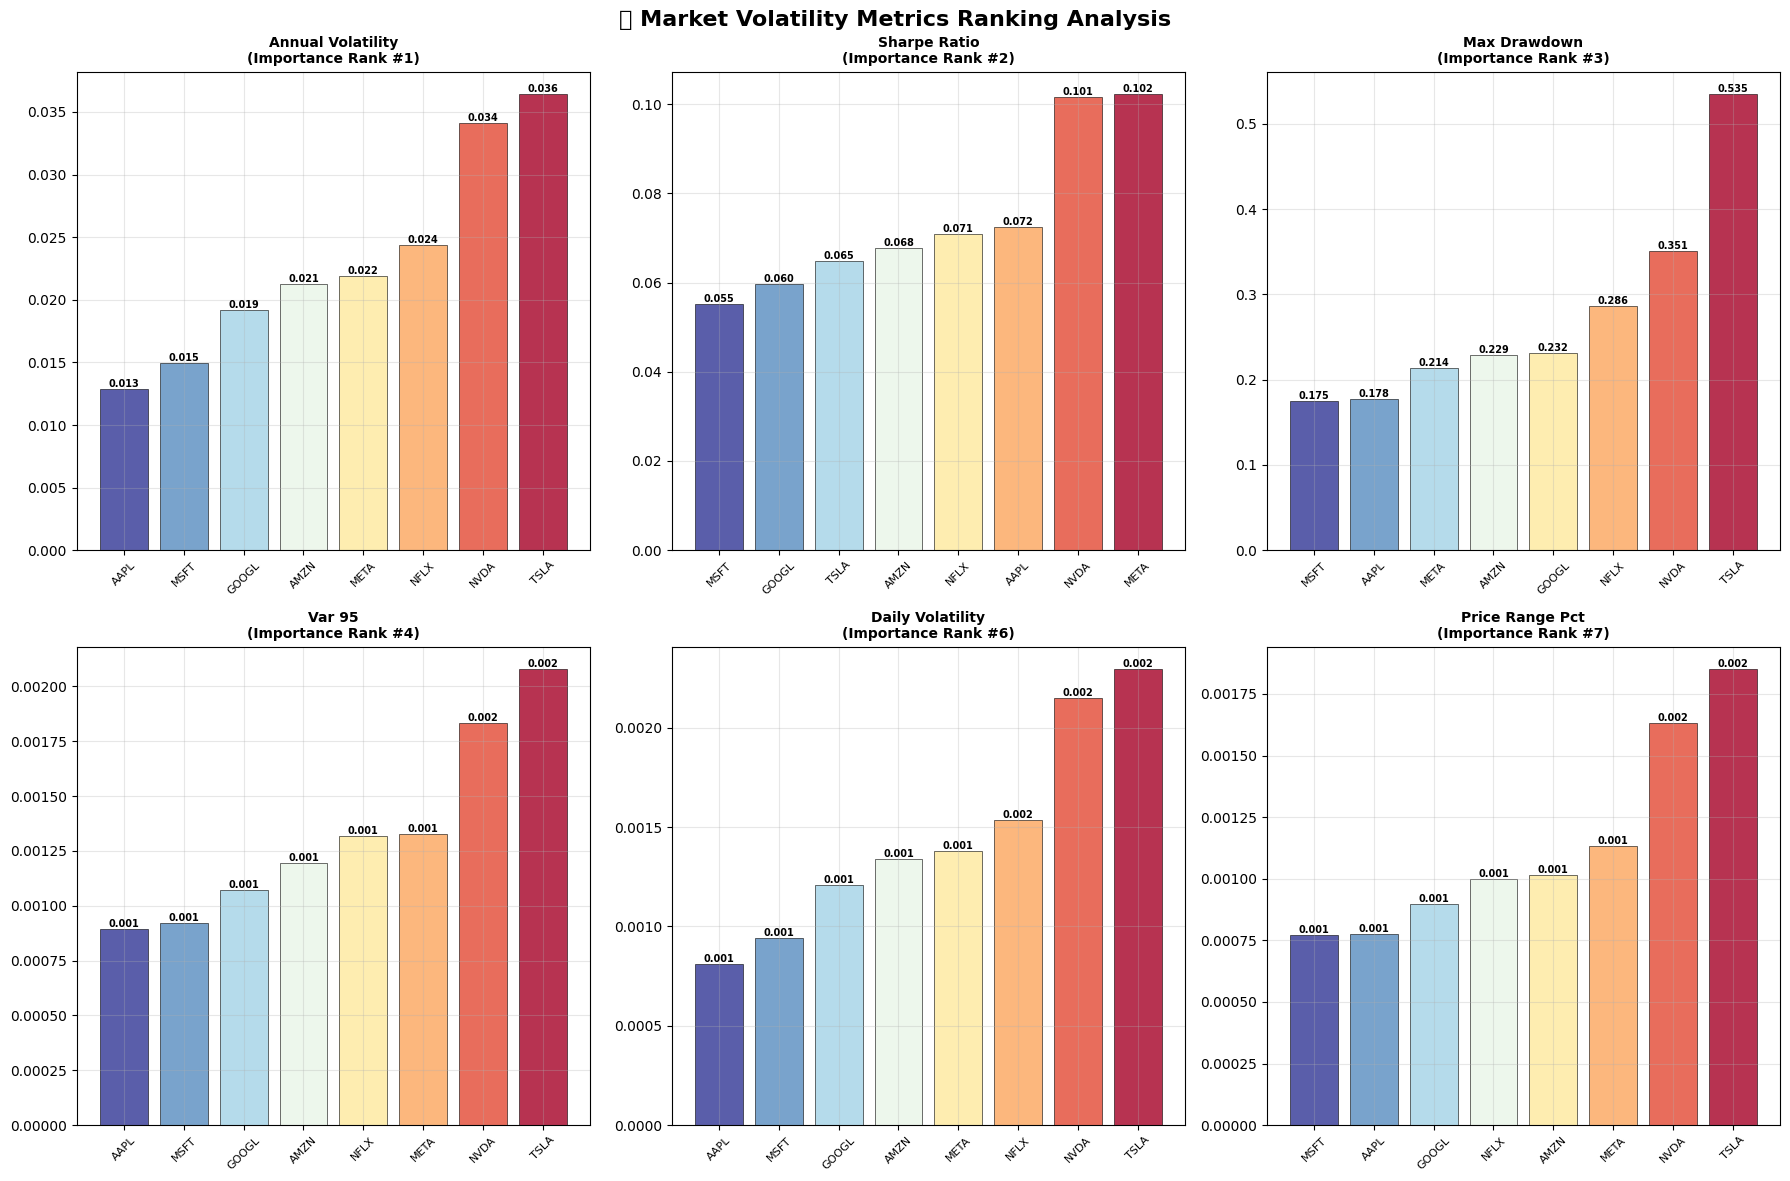


💾 Results saved to: market_volatility_ranking_volatility_ranking_20250611_110016.csv


In [9]:
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class VolatilityRankingAnalyzer:
    def __init__(self, db_config):
        """
        PostgreSQL 변동성 순위 분석기 초기화
        
        db_config 예시:
        {
            'host': '192.168.40.193',
            'database': 'minute',
            'user': 'postgres',
            'password': 'mysecretpassword',
            'port': 5432
        }
        """
        self.db_config = db_config
        self.engine = self._create_connection()
        
        # 변동성 지표 중요도 가중치 (순위별)
        self.volatility_weights = {
            'annual_volatility': 9.5,      # 1위
            'sharpe_ratio': 9.0,           # 2위  
            'max_drawdown': 8.5,           # 3위
            'var_95': 8.0,                 # 4위
            'var_99': 8.0,                 # 4위 (동점)
            'daily_volatility': 7.5,       # 5위
            'price_range_pct': 7.0,        # 6위
            'log_volatility': 6.5,         # 7위
            'skewness': 6.0,               # 8위
            'kurtosis': 5.5                # 9위
        }
        
    def _create_connection(self):
        """PostgreSQL 데이터베이스 연결 생성"""
        try:
            connection_string = f"postgresql://{self.db_config['user']}:{self.db_config['password']}@{self.db_config['host']}:{self.db_config['port']}/{self.db_config['database']}"
            engine = create_engine(connection_string)
            print(f"✅ Database connection established: {self.db_config['host']}:{self.db_config['port']}")
            return engine
        except Exception as e:
            print(f"❌ Database connection failed: {e}")
            raise
    
    def fetch_market_data(self, start_date, end_date=None, symbols=None):
        """PostgreSQL에서 시장 데이터 가져오기"""
        
        base_query = """
        SELECT 
            date, symbol, open, high, low, close, volume
        FROM us_market_data 
        WHERE date >= %(start_date)s
        """
        
        params = {'start_date': start_date}
        
        if end_date:
            base_query += " AND date <= %(end_date)s"
            params['end_date'] = end_date
            
        if symbols:
            # WHERE symbol IN ('AAPL', 'MSFT', ...) 형태로 생성
            symbol_placeholders = ','.join([f"'{symbol}'" for symbol in symbols])
            base_query += f" AND symbol IN ({symbol_placeholders})"
            
        base_query += " ORDER BY symbol, date"
        
        try:
            print(f"🔍 Fetching data from PostgreSQL...")
            print(f"   Start date: {start_date}")
            if end_date:
                print(f"   End date: {end_date}")
            if symbols:
                print(f"   Symbols: {symbols}")
            
            df = pd.read_sql_query(base_query, self.engine, params=params)
            df['date'] = pd.to_datetime(df['date'])
            
            if not df.empty:
                print(f"✅ Successfully fetched {len(df)} records")
                print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
                print(f"   Symbols: {df['symbol'].nunique()} ({df['symbol'].unique()})")
            else:
                print("❌ No data found with given criteria")
                
            return df
            
        except Exception as e:
            print(f"❌ Error fetching data: {e}")
            return pd.DataFrame()
    
    def fetch_symbol_data(self, symbol, start_date, end_date=None):
        """특정 심볼의 데이터만 가져오기"""
        
        query = """
        SELECT 
            date, symbol, open, high, low, close, volume
        FROM us_market_data 
        WHERE symbol = %(symbol)s
        AND date >= %(start_date)s
        """
        
        params = {
            'symbol': symbol,
            'start_date': start_date
        }
        
        if end_date:
            query += " AND date <= %(end_date)s"
            params['end_date'] = end_date
            
        query += " ORDER BY date"
        
        try:
            df = pd.read_sql_query(query, self.engine, params=params)
            df['date'] = pd.to_datetime(df['date'])
            print(f"✅ {symbol}: {len(df)} records fetched")
            return df
            
        except Exception as e:
            print(f"❌ Error fetching {symbol}: {e}")
            return pd.DataFrame()
    
    def calculate_returns(self, df):
        """수익률 및 기본 지표 계산"""
        if df.empty:
            return df
            
        df = df.copy()
        df = df.sort_values(['symbol', 'date'])
        
        # 심볼별로 그룹화하여 계산
        df['prev_close'] = df.groupby('symbol')['close'].shift(1)
        
        # 일일 수익률
        df['daily_return'] = (df['close'] - df['prev_close']) / df['prev_close']
        
        # 로그 수익률
        df['log_return'] = np.log(df['close'] / df['prev_close'])
        
        # 가격 변동폭
        df['price_range'] = df['high'] - df['low']
        df['price_range_pct'] = df['price_range'] / df['close']
        
        # NaN 제거
        df = df.dropna(subset=['daily_return'])
        
        print(f"📊 Returns calculated for {len(df)} records")
        return df
    
    def calculate_volatility_metrics_by_symbol(self, symbol, start_date, end_date=None):
        """개별 심볼의 변동성 지표 계산"""
        
        # 해당 심볼 데이터 가져오기
        symbol_df = self.fetch_symbol_data(symbol, start_date, end_date)
        
        if symbol_df.empty or len(symbol_df) < 30:
            print(f"⚠️  {symbol}: Insufficient data ({len(symbol_df)} records)")
            return None
        
        # 수익률 계산
        symbol_df = self.calculate_returns(symbol_df)
        
        if symbol_df.empty:
            return None
            
        returns = symbol_df['daily_return'].dropna()
        log_returns = symbol_df['log_return'].dropna()
        
        if len(returns) < 10:
            print(f"⚠️  {symbol}: Insufficient return data ({len(returns)} points)")
            return None
        
        try:
            # 1위: Annual Volatility (연간 변동성)
            daily_vol = returns.std()
            annual_vol = daily_vol * np.sqrt(252)
            
            # 2위: Sharpe Ratio (샤프 비율)
            avg_return = returns.mean()
            sharpe = (avg_return / daily_vol * np.sqrt(252)) if daily_vol > 0 else 0
            
            # 3위: Maximum Drawdown (최대 손실폭)
            cumulative_returns = (1 + returns).cumprod()
            rolling_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - rolling_max) / rolling_max
            max_dd = abs(drawdown.min())
            
            # 4위: VaR (Value at Risk)
            var_95 = abs(returns.quantile(0.05))
            var_99 = abs(returns.quantile(0.01))
            
            # 5위: Daily Volatility (일일 변동성)
            daily_volatility = daily_vol
            
            # 6위: Price Range Percentage (가격 변동폭 비율)
            avg_price_range_pct = symbol_df['price_range_pct'].mean()
            
            # 7위: Log Volatility (로그 변동성)
            log_vol = log_returns.std()
            annual_log_vol = log_vol * np.sqrt(252)
            
            # 8위: Skewness (왜도)
            skew = abs(returns.skew())
            
            # 9위: Kurtosis (첨도)
            kurt = abs(returns.kurtosis())
            
            # 결과 반환
            result = {
                'symbol': symbol,
                'data_points': len(returns),
                'period_start': symbol_df['date'].min().strftime('%Y-%m-%d'),
                'period_end': symbol_df['date'].max().strftime('%Y-%m-%d'),
                
                # 순위별 변동성 지표
                'annual_volatility': annual_vol,
                'sharpe_ratio': sharpe,
                'max_drawdown': max_dd,
                'var_95': var_95,
                'var_99': var_99,
                'daily_volatility': daily_volatility,
                'price_range_pct': avg_price_range_pct,
                'log_volatility': annual_log_vol,
                'skewness': skew,
                'kurtosis': kurt,
                
                # 기본 통계
                'avg_daily_return': avg_return,
                'total_return': (symbol_df['close'].iloc[-1] / symbol_df['close'].iloc[0] - 1),
                'min_return': returns.min(),
                'max_return': returns.max(),
                'avg_volume': symbol_df['volume'].mean()
            }
            
            print(f"✅ {symbol}: Volatility metrics calculated")
            return result
            
        except Exception as e:
            print(f"❌ Error calculating metrics for {symbol}: {e}")
            return None
    
    def calculate_all_volatility_metrics(self, symbols, start_date, end_date=None):
        """모든 심볼의 변동성 지표 계산"""
        
        print(f"🔄 Processing {len(symbols)} symbols...")
        results = []
        
        for i, symbol in enumerate(symbols, 1):
            print(f"[{i}/{len(symbols)}] Processing {symbol}...")
            
            metrics = self.calculate_volatility_metrics_by_symbol(symbol, start_date, end_date)
            
            if metrics:
                results.append(metrics)
            
        if results:
            df = pd.DataFrame(results)
            print(f"✅ Successfully processed {len(results)} symbols")
            return df
        else:
            print("❌ No volatility metrics calculated")
            return pd.DataFrame()
    
    def create_volatility_ranking(self, metrics_df):
        """변동성 지표 기반 종합 순위 생성"""
        if metrics_df.empty:
            return pd.DataFrame()
        
        ranking_df = metrics_df.copy()
        volatility_cols = list(self.volatility_weights.keys())
        
        print("📊 Creating volatility rankings...")
        
        # 각 지표별 순위 계산
        for col in volatility_cols:
            if col in ranking_df.columns:
                if col == 'sharpe_ratio':
                    # Sharpe Ratio는 높을수록 좋음 (역순)
                    ranking_df[f'{col}_rank'] = ranking_df[col].rank(ascending=False)
                else:
                    # 나머지 변동성 지표들은 높을수록 위험함 (정순)
                    ranking_df[f'{col}_rank'] = ranking_df[col].rank(ascending=False)
        
        # 가중 점수 계산
        ranking_df['weighted_score'] = 0
        ranking_df['total_weight'] = 0
        
        for col, weight in self.volatility_weights.items():
            rank_col = f'{col}_rank'
            if rank_col in ranking_df.columns:
                # 순위를 점수로 변환 (1위=10점, 꼴지=1점)
                max_rank = len(ranking_df)
                points = (max_rank + 1 - ranking_df[rank_col]) / max_rank * 10
                ranking_df['weighted_score'] += points * weight
                ranking_df['total_weight'] += weight
        
        # 최종 점수 계산 (0-10 스케일)
        ranking_df['final_score'] = ranking_df['weighted_score'] / ranking_df['total_weight']
        ranking_df['overall_rank'] = ranking_df['final_score'].rank(ascending=False)
        
        # 정렬
        ranking_df = ranking_df.sort_values('overall_rank')
        
        print("✅ Volatility ranking completed")
        return ranking_df
    
    def create_ranking_visualization(self, ranking_df):
        """순위 시각화"""
        if ranking_df.empty:
            print("❌ No data to visualize")
            return
        
        # 상위 6개 지표 선택
        top_metrics = ['annual_volatility', 'sharpe_ratio', 'max_drawdown', 
                      'var_95', 'daily_volatility', 'price_range_pct']
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('🏆 Market Volatility Metrics Ranking Analysis', 
                     fontsize=16, fontweight='bold')
        
        axes = axes.flatten()
        
        for i, metric in enumerate(top_metrics):
            if metric in ranking_df.columns and i < len(axes):
                
                # 데이터 정렬 (해당 지표 기준)
                sorted_data = ranking_df.sort_values(metric, ascending=True)
                
                # 색상 설정
                colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(sorted_data)))
                
                # 바 차트
                bars = axes[i].bar(range(len(sorted_data)), sorted_data[metric], 
                                  color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
                
                # 제목과 축 설정
                metric_name = metric.replace('_', ' ').title()
                rank = list(self.volatility_weights.keys()).index(metric) + 1
                axes[i].set_title(f'{metric_name}\n(Importance Rank #{rank})', 
                                 fontweight='bold', fontsize=10)
                axes[i].set_xticks(range(len(sorted_data)))
                axes[i].set_xticklabels(sorted_data['symbol'], rotation=45, fontsize=8)
                axes[i].grid(True, alpha=0.3)
                
                # 값 표시
                for j, (bar, value) in enumerate(zip(bars, sorted_data[metric])):
                    height = bar.get_height()
                    axes[i].text(bar.get_x() + bar.get_width()/2., height,
                               f'{value:.3f}', ha='center', va='bottom', 
                               fontsize=7, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    def generate_ranking_report(self, symbols, start_date, end_date=None, save_to_file=None):
        """종합 변동성 순위 보고서 생성"""
        
        print("="*70)
        print("🏆 MARKET VOLATILITY RANKING ANALYSIS REPORT")
        print("="*70)
        print(f"📅 Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"📊 Database: {self.db_config['host']}:{self.db_config['port']}/{self.db_config['database']}")
        print(f"📈 Period: {start_date} ~ {end_date or 'Latest'}")
        print(f"🎯 Symbols: {symbols}")
        print("-"*70)
        
        # 변동성 지표 중요도 출력
        print("\n📋 VOLATILITY METRICS IMPORTANCE RANKING:")
        print("-"*50)
        for i, (metric, weight) in enumerate(self.volatility_weights.items(), 1):
            metric_name = metric.replace('_', ' ').title()
            print(f"{i:2d}. {metric_name:<25} (Weight: {weight:4.1f}/10)")
        
        # 변동성 지표 계산
        metrics_df = self.calculate_all_volatility_metrics(symbols, start_date, end_date)
        
        if metrics_df.empty:
            print("\n❌ No volatility metrics could be calculated")
            return None
        
        # 순위 생성
        ranking_df = self.create_volatility_ranking(metrics_df)
        
        # 결과 출력
        print(f"\n🏆 STOCK VOLATILITY RANKING (Weighted Score):")
        print("-"*80)
        print(f"{'Rank':<4} {'Symbol':<8} {'Score':<8} {'AnnVol':<8} {'Sharpe':<8} {'MaxDD':<8} {'VaR95':<8}")
        print("-"*80)
        
        for _, row in ranking_df.iterrows():
            print(f"{int(row['overall_rank']):2d}   {row['symbol']:<8} "
                  f"{row['final_score']:6.2f}   "
                  f"{row['annual_volatility']:6.3f}   "
                  f"{row['sharpe_ratio']:6.3f}   "
                  f"{row['max_drawdown']:6.3f}   "
                  f"{row['var_95']:6.3f}")
        
        # 상세 분석
        print(f"\n📊 DETAILED ANALYSIS:")
        print("-"*50)
        best_performer = ranking_df.iloc[0]
        worst_performer = ranking_df.iloc[-1]
        
        print(f"🥇 Best Overall: {best_performer['symbol']} (Score: {best_performer['final_score']:.2f})")
        print(f"🥉 Worst Overall: {worst_performer['symbol']} (Score: {worst_performer['final_score']:.2f})")
        
        # 각 지표별 1위
        print(f"\n🏅 INDIVIDUAL METRIC LEADERS:")
        print("-"*30)
        for metric in ['annual_volatility', 'sharpe_ratio', 'max_drawdown', 'var_95']:
            if metric == 'sharpe_ratio':
                leader = ranking_df.loc[ranking_df[metric].idxmax()]
                print(f"• Best {metric.replace('_', ' ').title()}: {leader['symbol']} ({leader[metric]:.3f})")
            else:
                leader = ranking_df.loc[ranking_df[metric].idxmax()]
                print(f"• Highest {metric.replace('_', ' ').title()}: {leader['symbol']} ({leader[metric]:.3f})")
        
        # 시각화
        self.create_ranking_visualization(ranking_df)
        
        # 파일 저장
        if save_to_file:
            try:
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                filename = f"{save_to_file}_volatility_ranking_{timestamp}.csv"
                ranking_df.to_csv(filename, index=False)
                print(f"\n💾 Results saved to: {filename}")
            except Exception as e:
                print(f"❌ Error saving file: {e}")
        
        print("="*70)
        
        return ranking_df

# 사용 예시
def main():
    """메인 실행 함수"""
    
    # PostgreSQL 데이터베이스 설정
    db_config = {
        'host': '192.168.40.193',
        'database': 'minute', 
        'user': 'postgres',
        'password': 'mysecretpassword',
        'port': 5432
    }
    
    try:
        # 분석기 초기화
        analyzer = VolatilityRankingAnalyzer(db_config)
        
        # 분석할 종목들
        symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX']
        
        # 분석 기간 설정
        start_date = '2023-01-01'
        end_date = '2025-01-01'  # 선택사항
        
        # 종합 순위 분석 실행
        ranking_results = analyzer.generate_ranking_report(
            symbols=symbols,
            start_date=start_date,
            end_date=end_date,
            save_to_file='market_volatility_ranking'
        )
        
        return ranking_results
        
    except Exception as e:
        print(f"❌ Error in main execution: {e}")
        return None

if __name__ == "__main__":
    # 실행
    results = main()

✅ Database connection established: 192.168.40.193:5432
🏆 MARKET VOLATILITY RANKING ANALYSIS REPORT
📅 Generated: 2025-06-11 11:20:25
📊 Database: 192.168.40.193:5432/minute
📈 Period: 2023-01-01 ~ 2025-01-01
🎯 Symbols: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX']
----------------------------------------------------------------------

📋 VOLATILITY METRICS IMPORTANCE RANKING:
--------------------------------------------------
 1. Annual Volatility         (Weight:  9.5/10)
 2. Sharpe Ratio              (Weight:  9.0/10)
 3. Max Drawdown              (Weight:  8.5/10)
 4. Var 95                    (Weight:  8.0/10)
 5. Var 99                    (Weight:  8.0/10)
 6. Daily Volatility          (Weight:  7.5/10)
 7. Price Range Pct           (Weight:  7.0/10)
 8. Log Volatility            (Weight:  6.5/10)
 9. Skewness                  (Weight:  6.0/10)
10. Kurtosis                  (Weight:  5.5/10)
🔄 Processing 8 symbols...
[1/8] Processing AAPL...
✅ AAPL: 195385 records 

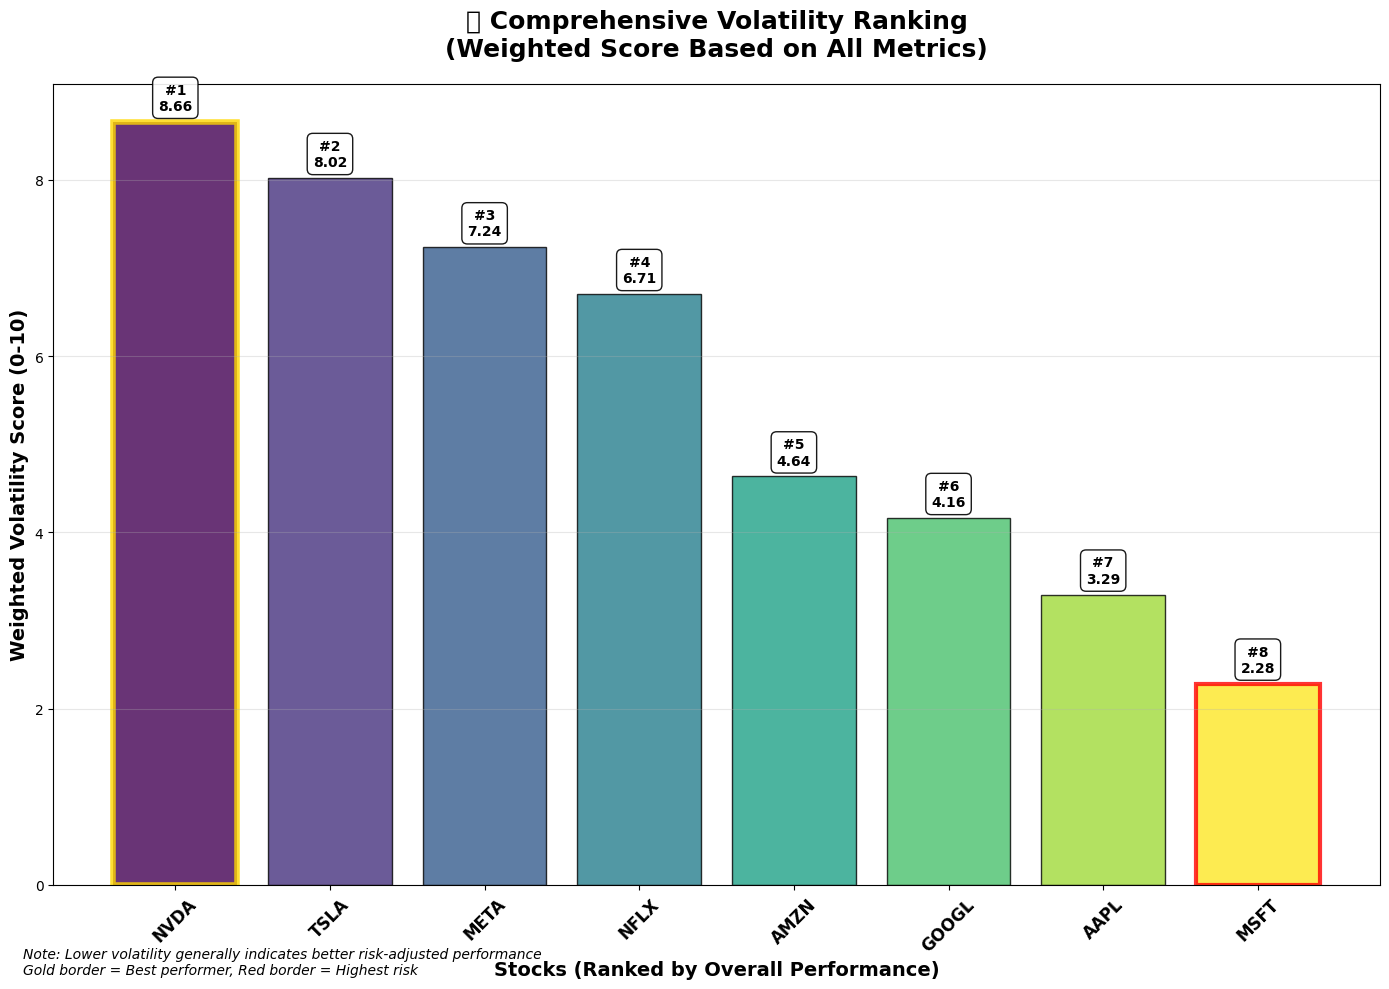

📊 Creating individual volatility plots...
[1/6] Creating plot for annual_volatility...


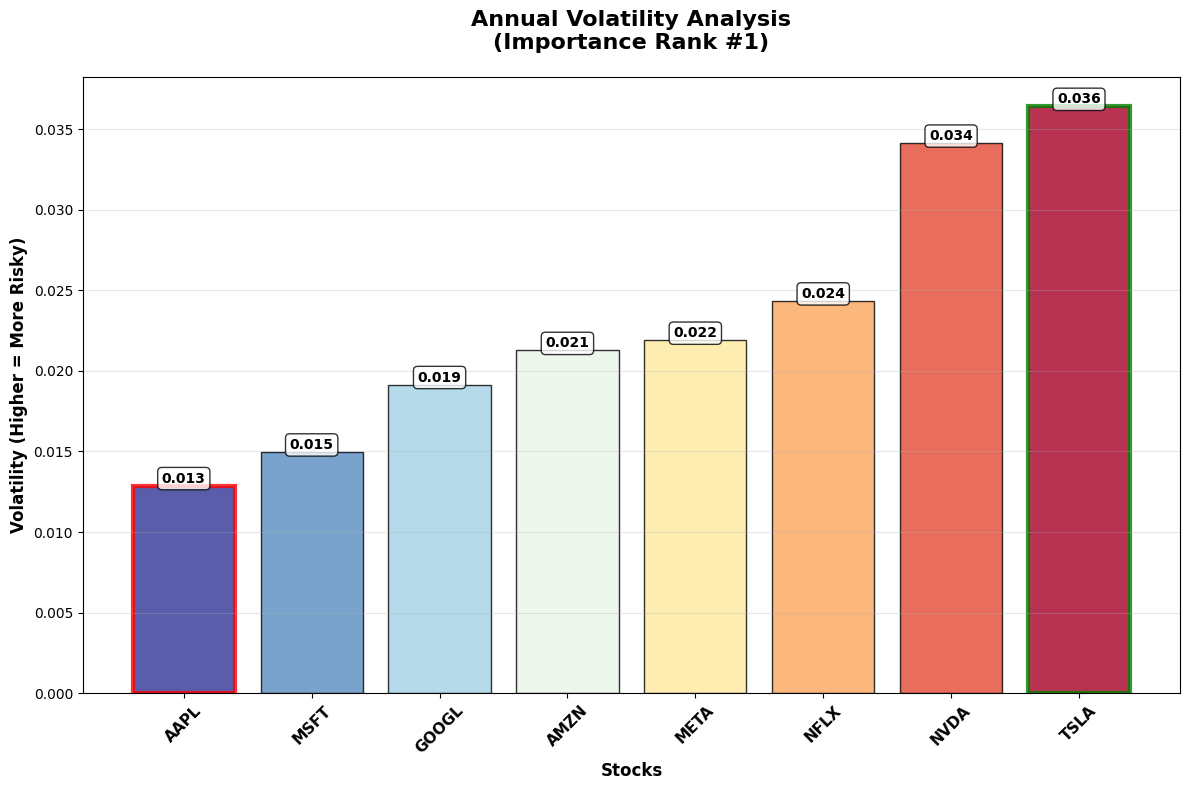

[2/6] Creating plot for sharpe_ratio...


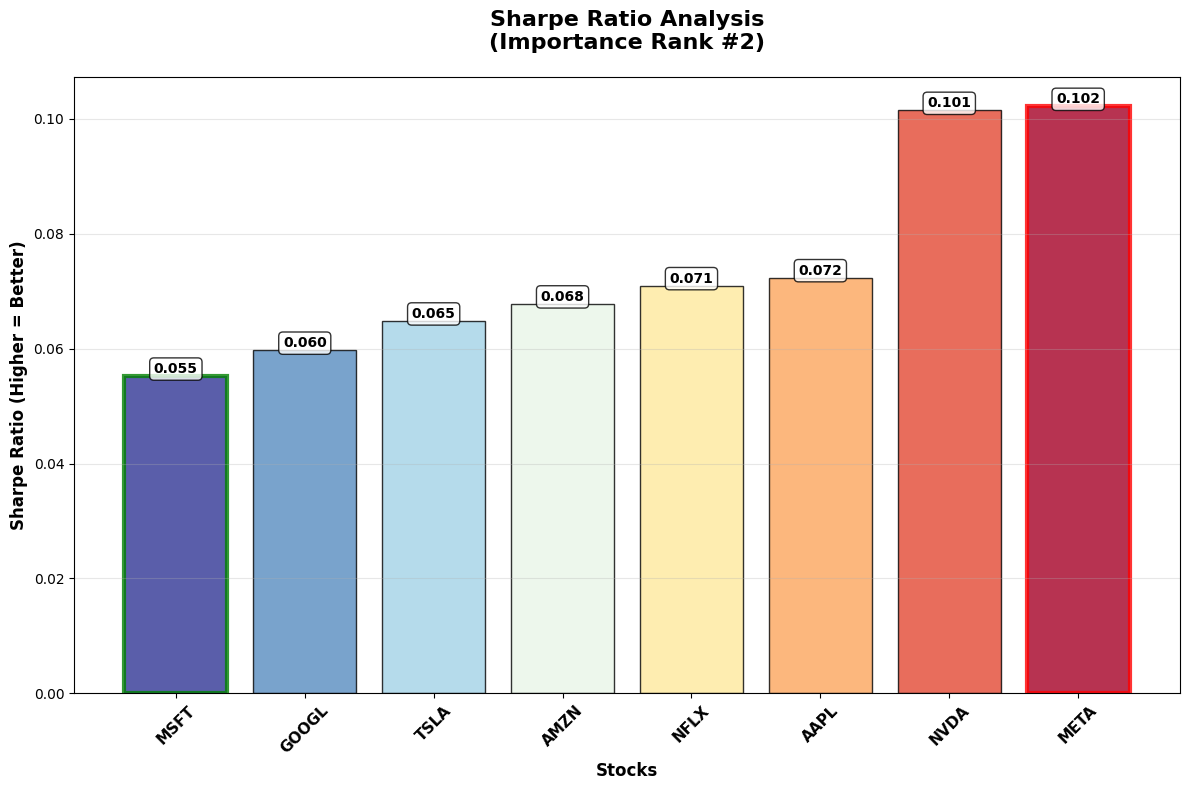

[3/6] Creating plot for max_drawdown...


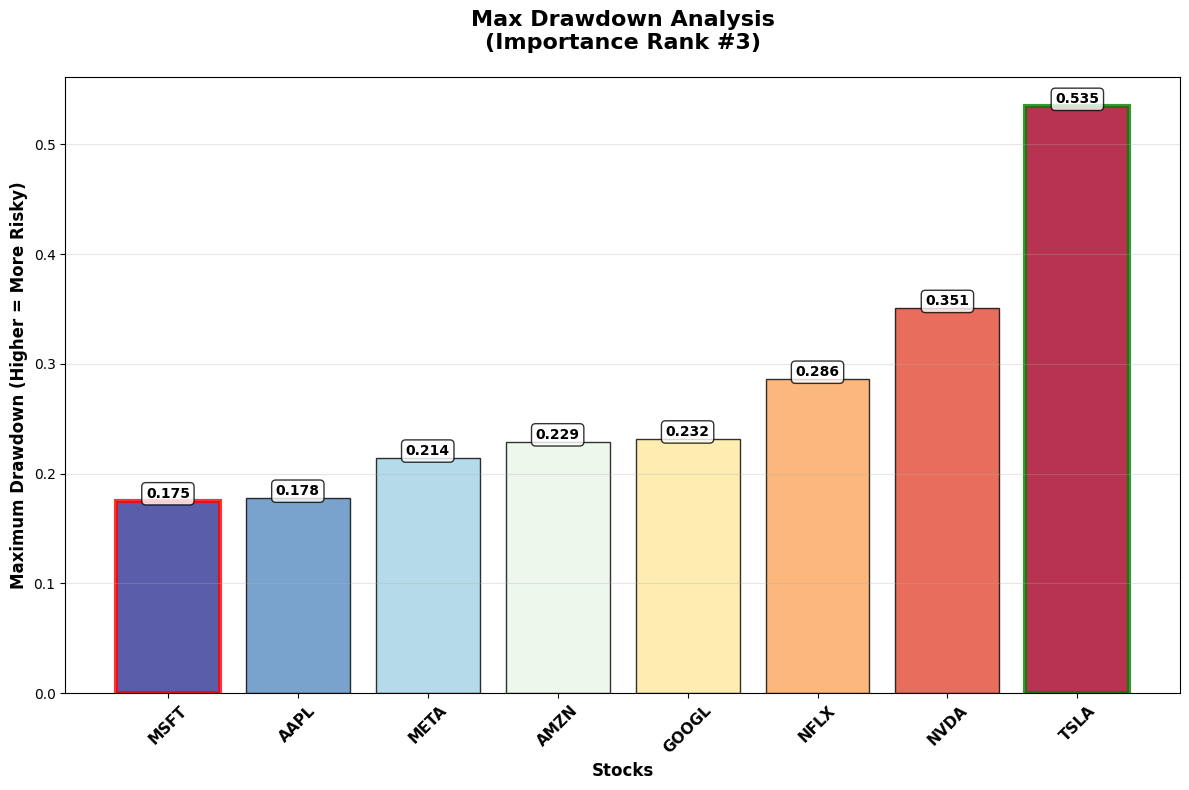

[4/6] Creating plot for var_95...


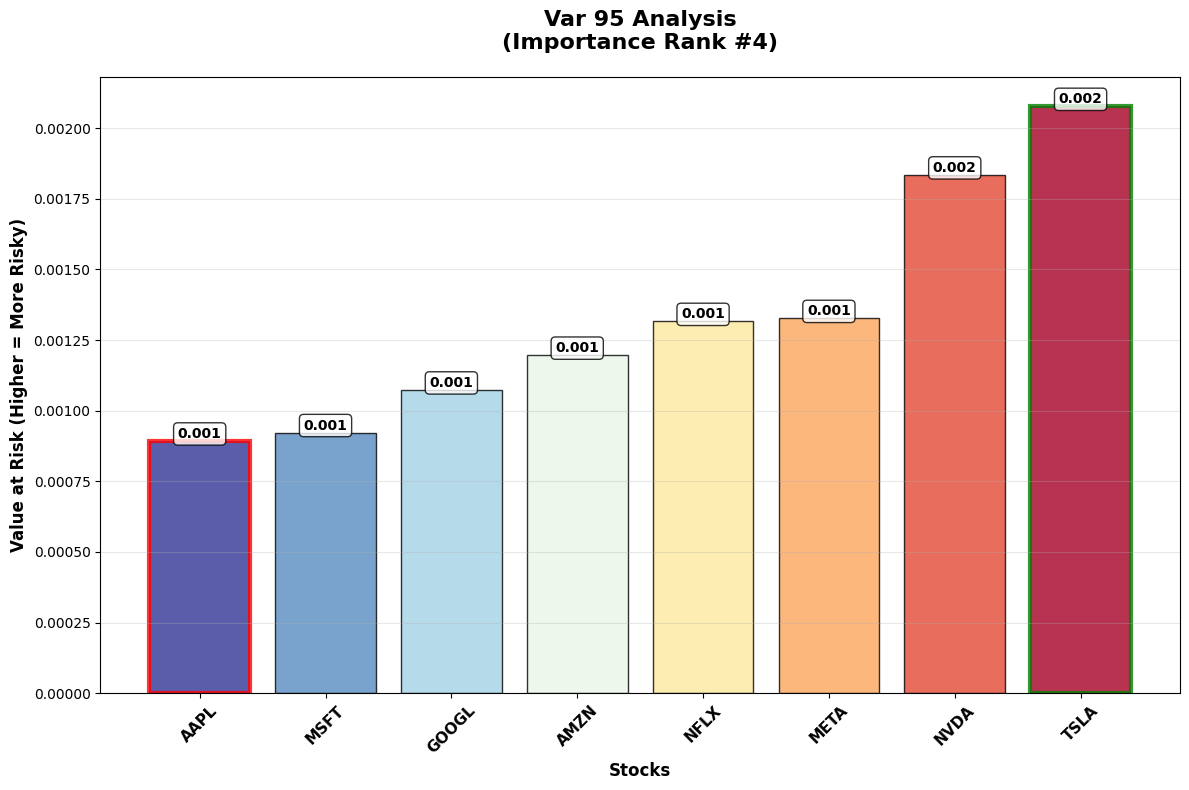

[5/6] Creating plot for daily_volatility...


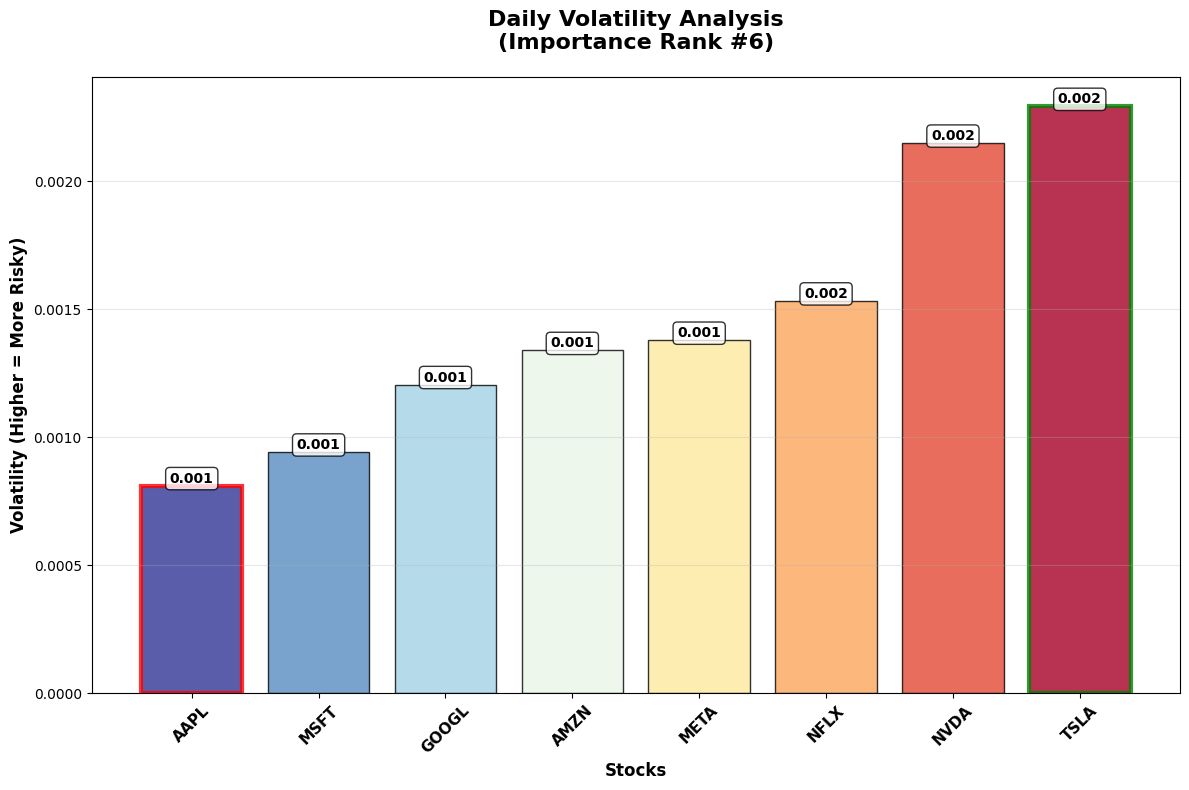

[6/6] Creating plot for price_range_pct...


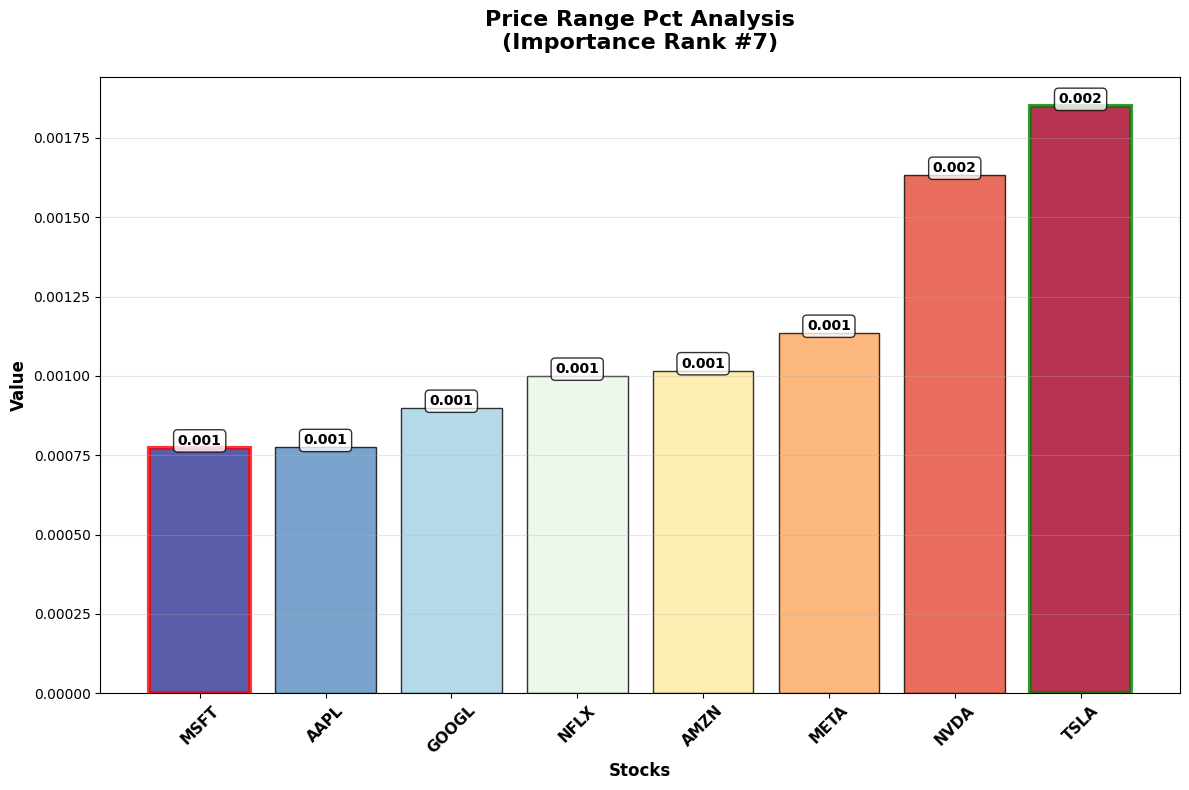


💾 Results saved to: market_volatility_ranking_volatility_ranking_20250611_112047.csv


In [10]:
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class VolatilityRankingAnalyzer:
    def __init__(self, db_config):
        """
        PostgreSQL 변동성 순위 분석기 초기화
        
        db_config 예시:
        {
            'host': '192.168.40.193',
            'database': 'minute',
            'user': 'postgres',
            'password': 'mysecretpassword',
            'port': 5432
        }
        """
        self.db_config = db_config
        self.engine = self._create_connection()
        
        # 변동성 지표 중요도 가중치 (순위별)
        self.volatility_weights = {
            'annual_volatility': 9.5,      # 1위
            'sharpe_ratio': 9.0,           # 2위  
            'max_drawdown': 8.5,           # 3위
            'var_95': 8.0,                 # 4위
            'var_99': 8.0,                 # 4위 (동점)
            'daily_volatility': 7.5,       # 5위
            'price_range_pct': 7.0,        # 6위
            'log_volatility': 6.5,         # 7위
            'skewness': 6.0,               # 8위
            'kurtosis': 5.5                # 9위
        }
        
    def _create_connection(self):
        """PostgreSQL 데이터베이스 연결 생성"""
        try:
            connection_string = f"postgresql://{self.db_config['user']}:{self.db_config['password']}@{self.db_config['host']}:{self.db_config['port']}/{self.db_config['database']}"
            engine = create_engine(connection_string)
            print(f"✅ Database connection established: {self.db_config['host']}:{self.db_config['port']}")
            return engine
        except Exception as e:
            print(f"❌ Database connection failed: {e}")
            raise
    
    def fetch_market_data(self, start_date, end_date=None, symbols=None):
        """PostgreSQL에서 시장 데이터 가져오기"""
        
        base_query = """
        SELECT 
            date, symbol, open, high, low, close, volume
        FROM us_market_data 
        WHERE date >= %(start_date)s
        """
        
        params = {'start_date': start_date}
        
        if end_date:
            base_query += " AND date <= %(end_date)s"
            params['end_date'] = end_date
            
        if symbols:
            # WHERE symbol IN ('AAPL', 'MSFT', ...) 형태로 생성
            symbol_placeholders = ','.join([f"'{symbol}'" for symbol in symbols])
            base_query += f" AND symbol IN ({symbol_placeholders})"
            
        base_query += " ORDER BY symbol, date"
        
        try:
            print(f"🔍 Fetching data from PostgreSQL...")
            print(f"   Start date: {start_date}")
            if end_date:
                print(f"   End date: {end_date}")
            if symbols:
                print(f"   Symbols: {symbols}")
            
            df = pd.read_sql_query(base_query, self.engine, params=params)
            df['date'] = pd.to_datetime(df['date'])
            
            if not df.empty:
                print(f"✅ Successfully fetched {len(df)} records")
                print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
                print(f"   Symbols: {df['symbol'].nunique()} ({df['symbol'].unique()})")
            else:
                print("❌ No data found with given criteria")
                
            return df
            
        except Exception as e:
            print(f"❌ Error fetching data: {e}")
            return pd.DataFrame()
    
    def fetch_symbol_data(self, symbol, start_date, end_date=None):
        """특정 심볼의 데이터만 가져오기"""
        
        query = """
        SELECT 
            date, symbol, open, high, low, close, volume
        FROM us_market_data 
        WHERE symbol = %(symbol)s
        AND date >= %(start_date)s
        """
        
        params = {
            'symbol': symbol,
            'start_date': start_date
        }
        
        if end_date:
            query += " AND date <= %(end_date)s"
            params['end_date'] = end_date
            
        query += " ORDER BY date"
        
        try:
            df = pd.read_sql_query(query, self.engine, params=params)
            df['date'] = pd.to_datetime(df['date'])
            print(f"✅ {symbol}: {len(df)} records fetched")
            return df
            
        except Exception as e:
            print(f"❌ Error fetching {symbol}: {e}")
            return pd.DataFrame()
    
    def calculate_returns(self, df):
        """수익률 및 기본 지표 계산"""
        if df.empty:
            return df
            
        df = df.copy()
        df = df.sort_values(['symbol', 'date'])
        
        # 심볼별로 그룹화하여 계산
        df['prev_close'] = df.groupby('symbol')['close'].shift(1)
        
        # 일일 수익률
        df['daily_return'] = (df['close'] - df['prev_close']) / df['prev_close']
        
        # 로그 수익률
        df['log_return'] = np.log(df['close'] / df['prev_close'])
        
        # 가격 변동폭
        df['price_range'] = df['high'] - df['low']
        df['price_range_pct'] = df['price_range'] / df['close']
        
        # NaN 제거
        df = df.dropna(subset=['daily_return'])
        
        print(f"📊 Returns calculated for {len(df)} records")
        return df
    
    def calculate_volatility_metrics_by_symbol(self, symbol, start_date, end_date=None):
        """개별 심볼의 변동성 지표 계산"""
        
        # 해당 심볼 데이터 가져오기
        symbol_df = self.fetch_symbol_data(symbol, start_date, end_date)
        
        if symbol_df.empty or len(symbol_df) < 30:
            print(f"⚠️  {symbol}: Insufficient data ({len(symbol_df)} records)")
            return None
        
        # 수익률 계산
        symbol_df = self.calculate_returns(symbol_df)
        
        if symbol_df.empty:
            return None
            
        returns = symbol_df['daily_return'].dropna()
        log_returns = symbol_df['log_return'].dropna()
        
        if len(returns) < 10:
            print(f"⚠️  {symbol}: Insufficient return data ({len(returns)} points)")
            return None
        
        try:
            # 1위: Annual Volatility (연간 변동성)
            daily_vol = returns.std()
            annual_vol = daily_vol * np.sqrt(252)
            
            # 2위: Sharpe Ratio (샤프 비율)
            avg_return = returns.mean()
            sharpe = (avg_return / daily_vol * np.sqrt(252)) if daily_vol > 0 else 0
            
            # 3위: Maximum Drawdown (최대 손실폭)
            cumulative_returns = (1 + returns).cumprod()
            rolling_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - rolling_max) / rolling_max
            max_dd = abs(drawdown.min())
            
            # 4위: VaR (Value at Risk)
            var_95 = abs(returns.quantile(0.05))
            var_99 = abs(returns.quantile(0.01))
            
            # 5위: Daily Volatility (일일 변동성)
            daily_volatility = daily_vol
            
            # 6위: Price Range Percentage (가격 변동폭 비율)
            avg_price_range_pct = symbol_df['price_range_pct'].mean()
            
            # 7위: Log Volatility (로그 변동성)
            log_vol = log_returns.std()
            annual_log_vol = log_vol * np.sqrt(252)
            
            # 8위: Skewness (왜도)
            skew = abs(returns.skew())
            
            # 9위: Kurtosis (첨도)
            kurt = abs(returns.kurtosis())
            
            # 결과 반환
            result = {
                'symbol': symbol,
                'data_points': len(returns),
                'period_start': symbol_df['date'].min().strftime('%Y-%m-%d'),
                'period_end': symbol_df['date'].max().strftime('%Y-%m-%d'),
                
                # 순위별 변동성 지표
                'annual_volatility': annual_vol,
                'sharpe_ratio': sharpe,
                'max_drawdown': max_dd,
                'var_95': var_95,
                'var_99': var_99,
                'daily_volatility': daily_volatility,
                'price_range_pct': avg_price_range_pct,
                'log_volatility': annual_log_vol,
                'skewness': skew,
                'kurtosis': kurt,
                
                # 기본 통계
                'avg_daily_return': avg_return,
                'total_return': (symbol_df['close'].iloc[-1] / symbol_df['close'].iloc[0] - 1),
                'min_return': returns.min(),
                'max_return': returns.max(),
                'avg_volume': symbol_df['volume'].mean()
            }
            
            print(f"✅ {symbol}: Volatility metrics calculated")
            return result
            
        except Exception as e:
            print(f"❌ Error calculating metrics for {symbol}: {e}")
            return None
    
    def calculate_all_volatility_metrics(self, symbols, start_date, end_date=None):
        """모든 심볼의 변동성 지표 계산"""
        
        print(f"🔄 Processing {len(symbols)} symbols...")
        results = []
        
        for i, symbol in enumerate(symbols, 1):
            print(f"[{i}/{len(symbols)}] Processing {symbol}...")
            
            metrics = self.calculate_volatility_metrics_by_symbol(symbol, start_date, end_date)
            
            if metrics:
                results.append(metrics)
            
        if results:
            df = pd.DataFrame(results)
            print(f"✅ Successfully processed {len(results)} symbols")
            return df
        else:
            print("❌ No volatility metrics calculated")
            return pd.DataFrame()
    
    def create_volatility_ranking(self, metrics_df):
        """변동성 지표 기반 종합 순위 생성"""
        if metrics_df.empty:
            return pd.DataFrame()
        
        ranking_df = metrics_df.copy()
        volatility_cols = list(self.volatility_weights.keys())
        
        print("📊 Creating volatility rankings...")
        
        # 각 지표별 순위 계산
        for col in volatility_cols:
            if col in ranking_df.columns:
                if col == 'sharpe_ratio':
                    # Sharpe Ratio는 높을수록 좋음 (역순)
                    ranking_df[f'{col}_rank'] = ranking_df[col].rank(ascending=False)
                else:
                    # 나머지 변동성 지표들은 높을수록 위험함 (정순)
                    ranking_df[f'{col}_rank'] = ranking_df[col].rank(ascending=False)
        
        # 가중 점수 계산
        ranking_df['weighted_score'] = 0
        ranking_df['total_weight'] = 0
        
        for col, weight in self.volatility_weights.items():
            rank_col = f'{col}_rank'
            if rank_col in ranking_df.columns:
                # 순위를 점수로 변환 (1위=10점, 꼴지=1점)
                max_rank = len(ranking_df)
                points = (max_rank + 1 - ranking_df[rank_col]) / max_rank * 10
                ranking_df['weighted_score'] += points * weight
                ranking_df['total_weight'] += weight
        
        # 최종 점수 계산 (0-10 스케일)
        ranking_df['final_score'] = ranking_df['weighted_score'] / ranking_df['total_weight']
        ranking_df['overall_rank'] = ranking_df['final_score'].rank(ascending=False)
        
        # 정렬
        ranking_df = ranking_df.sort_values('overall_rank')
        
        print("✅ Volatility ranking completed")
        return ranking_df
    
    def create_individual_metric_plot(self, ranking_df, metric, plot_title=None):
        """개별 지표에 대한 플롯 생성"""
        if ranking_df.empty or metric not in ranking_df.columns:
            print(f"❌ Cannot create plot for {metric}: Data not available")
            return
        
        # 데이터 정렬 (해당 지표 기준)
        sorted_data = ranking_df.sort_values(metric, ascending=True)
        
        # 플롯 생성
        plt.figure(figsize=(12, 8))
        
        # 색상 설정 (RdYlBu_r 컬러맵 사용)
        colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(sorted_data)))
        
        # 바 차트
        bars = plt.bar(range(len(sorted_data)), sorted_data[metric], 
                      color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        
        # 제목과 축 설정
        if plot_title is None:
            metric_name = metric.replace('_', ' ').title()
            if metric in self.volatility_weights:
                rank = list(self.volatility_weights.keys()).index(metric) + 1
                plot_title = f'{metric_name} Analysis\n(Importance Rank #{rank})'
            else:
                plot_title = f'{metric_name} Analysis'
        
        plt.title(plot_title, fontweight='bold', fontsize=16, pad=20)
        plt.xlabel('Stocks', fontweight='bold', fontsize=12)
        
        # Y축 라벨 설정
        if metric == 'sharpe_ratio':
            plt.ylabel('Sharpe Ratio (Higher = Better)', fontweight='bold', fontsize=12)
        elif 'volatility' in metric:
            plt.ylabel('Volatility (Higher = More Risky)', fontweight='bold', fontsize=12)
        elif metric == 'max_drawdown':
            plt.ylabel('Maximum Drawdown (Higher = More Risky)', fontweight='bold', fontsize=12)
        elif 'var' in metric:
            plt.ylabel('Value at Risk (Higher = More Risky)', fontweight='bold', fontsize=12)
        else:
            plt.ylabel('Value', fontweight='bold', fontsize=12)
        
        # X축 설정
        plt.xticks(range(len(sorted_data)), sorted_data['symbol'], 
                  rotation=45, fontsize=11, fontweight='bold')
        
        # 그리드 추가
        plt.grid(True, alpha=0.3, axis='y')
        
        # 값 표시
        for i, (bar, value) in enumerate(zip(bars, sorted_data[metric])):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.3f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        # 최고/최저 강조
        if len(sorted_data) > 0:
            best_idx = 0 if metric == 'sharpe_ratio' else len(sorted_data) - 1
            worst_idx = len(sorted_data) - 1 if metric == 'sharpe_ratio' else 0
            
            # 테두리 강조
            bars[best_idx].set_edgecolor('green')
            bars[best_idx].set_linewidth(3)
            bars[worst_idx].set_edgecolor('red')
            bars[worst_idx].set_linewidth(3)
        
        plt.tight_layout()
        plt.show()
        
    def create_all_individual_plots(self, ranking_df):
        """모든 주요 지표에 대한 개별 플롯 생성"""
        if ranking_df.empty:
            print("❌ No data to visualize")
            return
        
        # 주요 6개 지표
        main_metrics = ['annual_volatility', 'sharpe_ratio', 'max_drawdown', 
                       'var_95', 'daily_volatility', 'price_range_pct']
        
        print("📊 Creating individual volatility plots...")
        
        for i, metric in enumerate(main_metrics, 1):
            if metric in ranking_df.columns:
                print(f"[{i}/{len(main_metrics)}] Creating plot for {metric}...")
                self.create_individual_metric_plot(ranking_df, metric)
            else:
                print(f"⚠️  Skipping {metric}: Not found in data")
    
    def create_comprehensive_overview_plot(self, ranking_df):
        """종합 순위 개요 플롯"""
        if ranking_df.empty:
            print("❌ No data to visualize")
            return
        
        # 최종 점수 기준으로 정렬
        sorted_data = ranking_df.sort_values('final_score', ascending=False)
        
        plt.figure(figsize=(14, 10))
        
        # 색상 그라데이션
        colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_data)))
        
        # 바 차트
        bars = plt.bar(range(len(sorted_data)), sorted_data['final_score'], 
                      color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        
        # 제목 설정
        plt.title('🏆 Comprehensive Volatility Ranking\n(Weighted Score Based on All Metrics)', 
                 fontweight='bold', fontsize=18, pad=20)
        plt.xlabel('Stocks (Ranked by Overall Performance)', fontweight='bold', fontsize=14)
        plt.ylabel('Weighted Volatility Score (0-10)', fontweight='bold', fontsize=14)
        
        # X축 설정
        plt.xticks(range(len(sorted_data)), sorted_data['symbol'], 
                  rotation=45, fontsize=12, fontweight='bold')
        
        # 그리드 추가
        plt.grid(True, alpha=0.3, axis='y')
        
        # 점수 표시
        for i, (bar, value, rank) in enumerate(zip(bars, sorted_data['final_score'], sorted_data['overall_rank'])):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'#{int(rank)}\n{value:.2f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))
        
        # 1위와 꼴찌 강조
        if len(bars) > 0:
            bars[0].set_edgecolor('gold')
            bars[0].set_linewidth(4)
            if len(bars) > 1:
                bars[-1].set_edgecolor('red')
                bars[-1].set_linewidth(3)
        
        # 범례 추가
        plt.figtext(0.02, 0.02, 
                   'Note: Lower volatility generally indicates better risk-adjusted performance\n'
                   'Gold border = Best performer, Red border = Highest risk',
                   fontsize=10, style='italic')
        
        plt.tight_layout()
        plt.show()
    
    def generate_ranking_report(self, symbols, start_date, end_date=None, save_to_file=None):
        """종합 변동성 순위 보고서 생성"""
        
        print("="*70)
        print("🏆 MARKET VOLATILITY RANKING ANALYSIS REPORT")
        print("="*70)
        print(f"📅 Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"📊 Database: {self.db_config['host']}:{self.db_config['port']}/{self.db_config['database']}")
        print(f"📈 Period: {start_date} ~ {end_date or 'Latest'}")
        print(f"🎯 Symbols: {symbols}")
        print("-"*70)
        
        # 변동성 지표 중요도 출력
        print("\n📋 VOLATILITY METRICS IMPORTANCE RANKING:")
        print("-"*50)
        for i, (metric, weight) in enumerate(self.volatility_weights.items(), 1):
            metric_name = metric.replace('_', ' ').title()
            print(f"{i:2d}. {metric_name:<25} (Weight: {weight:4.1f}/10)")
        
        # 변동성 지표 계산
        metrics_df = self.calculate_all_volatility_metrics(symbols, start_date, end_date)
        
        if metrics_df.empty:
            print("\n❌ No volatility metrics could be calculated")
            return None
        
        # 순위 생성
        ranking_df = self.create_volatility_ranking(metrics_df)
        
        # 결과 출력
        print(f"\n🏆 STOCK VOLATILITY RANKING (Weighted Score):")
        print("-"*80)
        print(f"{'Rank':<4} {'Symbol':<8} {'Score':<8} {'AnnVol':<8} {'Sharpe':<8} {'MaxDD':<8} {'VaR95':<8}")
        print("-"*80)
        
        for _, row in ranking_df.iterrows():
            print(f"{int(row['overall_rank']):2d}   {row['symbol']:<8} "
                  f"{row['final_score']:6.2f}   "
                  f"{row['annual_volatility']:6.3f}   "
                  f"{row['sharpe_ratio']:6.3f}   "
                  f"{row['max_drawdown']:6.3f}   "
                  f"{row['var_95']:6.3f}")
        
        # 상세 분석
        print(f"\n📊 DETAILED ANALYSIS:")
        print("-"*50)
        best_performer = ranking_df.iloc[0]
        worst_performer = ranking_df.iloc[-1]
        
        print(f"🥇 Best Overall: {best_performer['symbol']} (Score: {best_performer['final_score']:.2f})")
        print(f"🥉 Worst Overall: {worst_performer['symbol']} (Score: {worst_performer['final_score']:.2f})")
        
        # 각 지표별 1위
        print(f"\n🏅 INDIVIDUAL METRIC LEADERS:")
        print("-"*30)
        for metric in ['annual_volatility', 'sharpe_ratio', 'max_drawdown', 'var_95']:
            if metric == 'sharpe_ratio':
                leader = ranking_df.loc[ranking_df[metric].idxmax()]
                print(f"• Best {metric.replace('_', ' ').title()}: {leader['symbol']} ({leader[metric]:.3f})")
            else:
                leader = ranking_df.loc[ranking_df[metric].idxmax()]
                print(f"• Highest {metric.replace('_', ' ').title()}: {leader['symbol']} ({leader[metric]:.3f})")
        
        # 개별 시각화 (각 플롯을 따로 생성)
        print("\n📊 Generating individual metric visualizations...")
        self.create_comprehensive_overview_plot(ranking_df)
        self.create_all_individual_plots(ranking_df)
        
        # 파일 저장
        if save_to_file:
            try:
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                filename = f"{save_to_file}_volatility_ranking_{timestamp}.csv"
                ranking_df.to_csv(filename, index=False)
                print(f"\n💾 Results saved to: {filename}")
            except Exception as e:
                print(f"❌ Error saving file: {e}")
        
        print("="*70)
        
        return ranking_df

# 사용 예시
def main():
    """메인 실행 함수"""
    
    # PostgreSQL 데이터베이스 설정
    db_config = {
        'host': '192.168.40.193',
        'database': 'minute', 
        'user': 'postgres',
        'password': 'mysecretpassword',
        'port': 5432
    }
    
    try:
        # 분석기 초기화
        analyzer = VolatilityRankingAnalyzer(db_config)
        
        # 분석할 종목들
        symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX']
        
        # 분석 기간 설정
        start_date = '2023-01-01'
        end_date = '2025-01-01'  # 선택사항
        
        # 종합 순위 분석 실행
        ranking_results = analyzer.generate_ranking_report(
            symbols=symbols,
            start_date=start_date,
            end_date=end_date,
            save_to_file='market_volatility_ranking'
        )
        
        return ranking_results
        
    except Exception as e:
        print(f"❌ Error in main execution: {e}")
        return None

if __name__ == "__main__":
    # 실행
    results = main()

✅ Database connection established: 192.168.40.193:5432
🏆 MARKET VOLATILITY RANKING ANALYSIS REPORT
📅 Generated: 2025-06-11 11:22:57
📊 Database: 192.168.40.193:5432/minute
📈 Period: 2024-01-01 ~ 2025-01-01
🎯 Symbols: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'GOOG']
----------------------------------------------------------------------

📋 VOLATILITY METRICS IMPORTANCE RANKING:
--------------------------------------------------
 1. Annual Volatility         (Weight:  9.5/10)
 2. Sharpe Ratio              (Weight:  9.0/10)
 3. Max Drawdown              (Weight:  8.5/10)
 4. Var 95                    (Weight:  8.0/10)
 5. Var 99                    (Weight:  8.0/10)
 6. Daily Volatility          (Weight:  7.5/10)
 7. Price Range Pct           (Weight:  7.0/10)
 8. Log Volatility            (Weight:  6.5/10)
 9. Skewness                  (Weight:  6.0/10)
10. Kurtosis                  (Weight:  5.5/10)
🔄 Processing 8 symbols...
[1/8] Processing AAPL...
✅ AAPL: 97994 records f

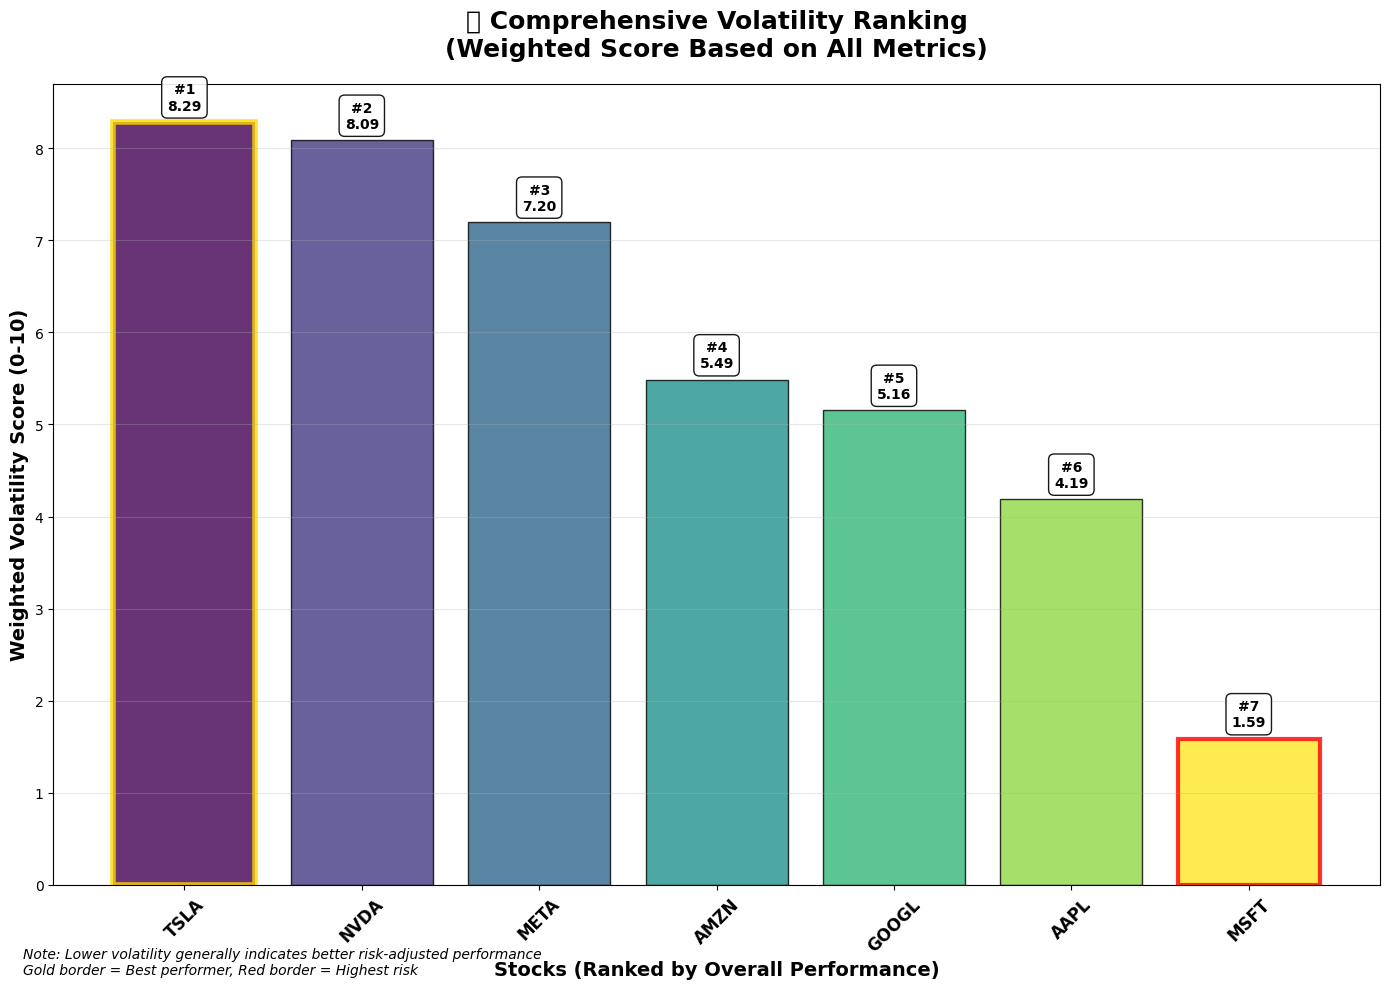

📊 Creating individual volatility plots...
[1/6] Creating plot for annual_volatility...


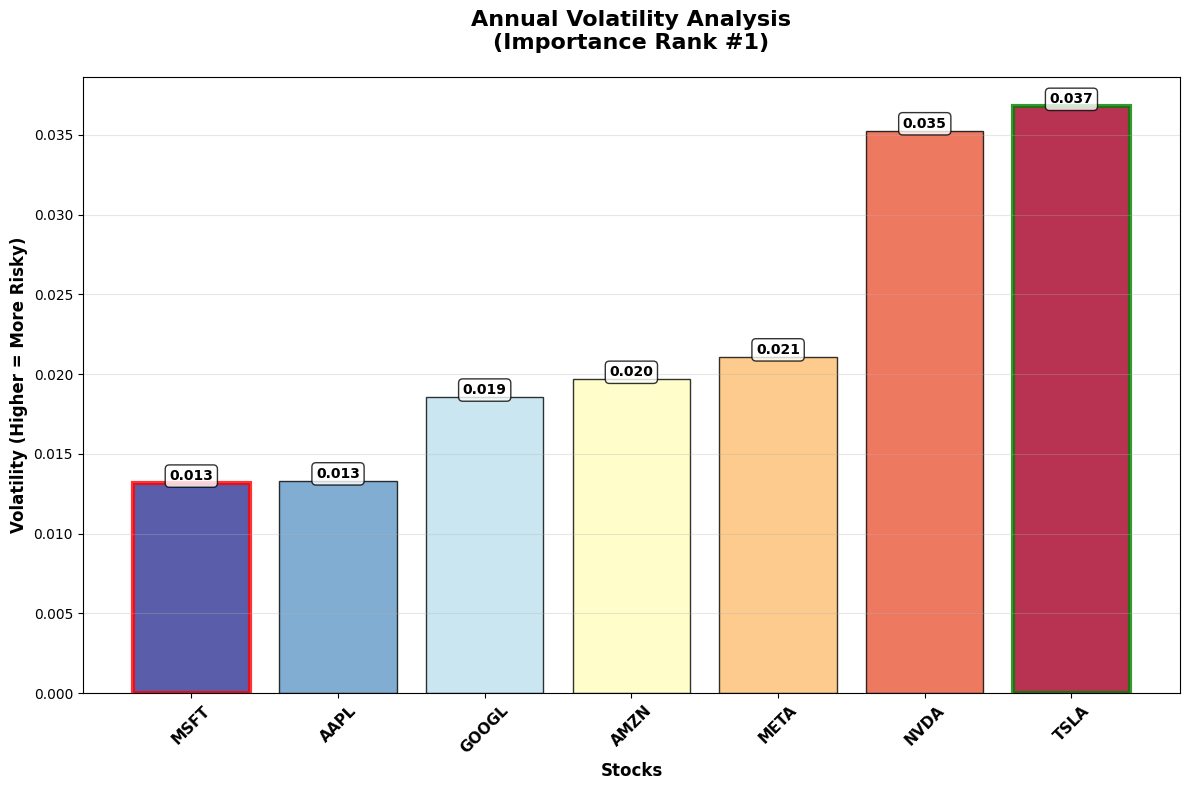

[2/6] Creating plot for sharpe_ratio...


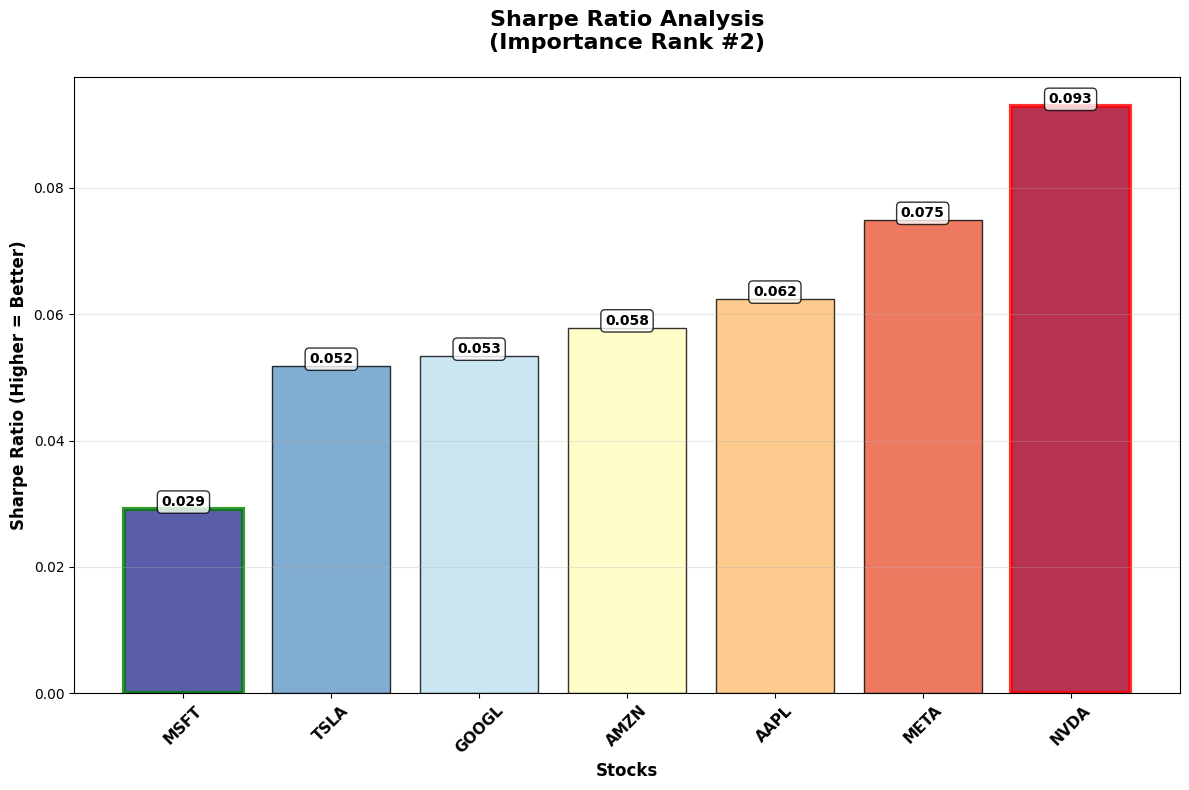

[3/6] Creating plot for max_drawdown...


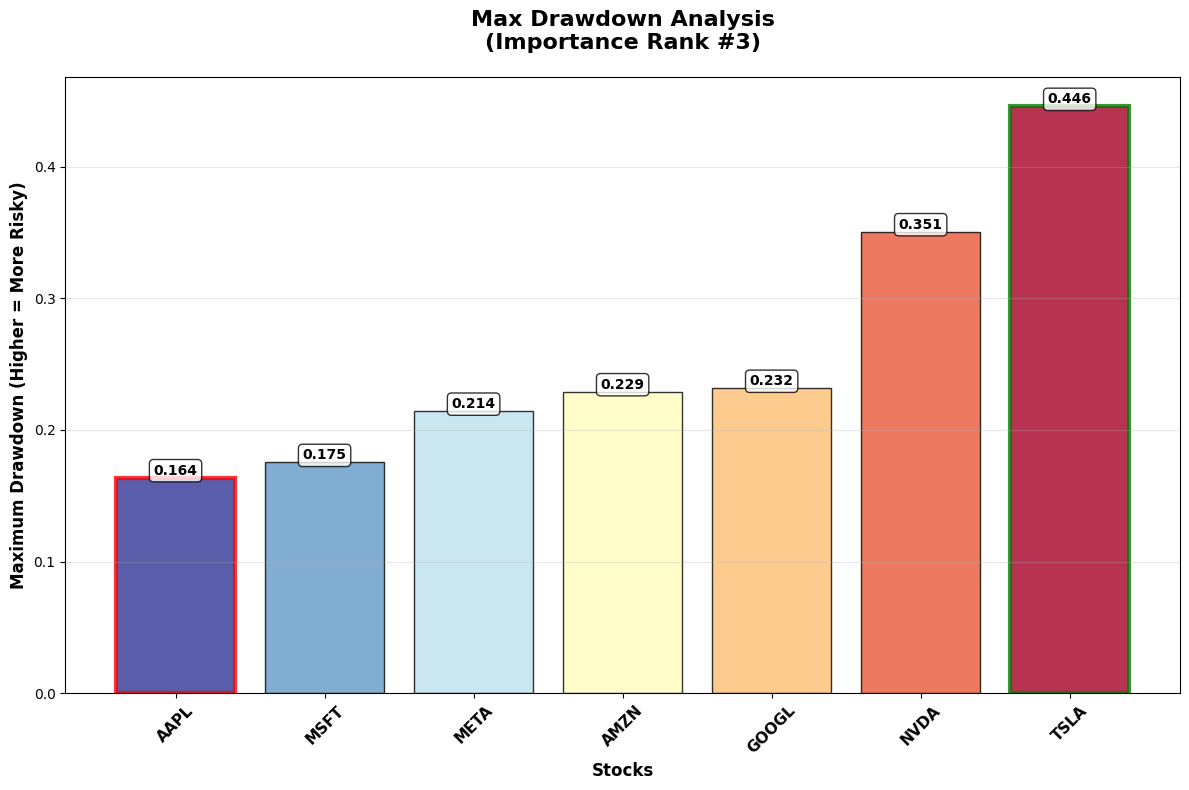

[4/6] Creating plot for var_95...


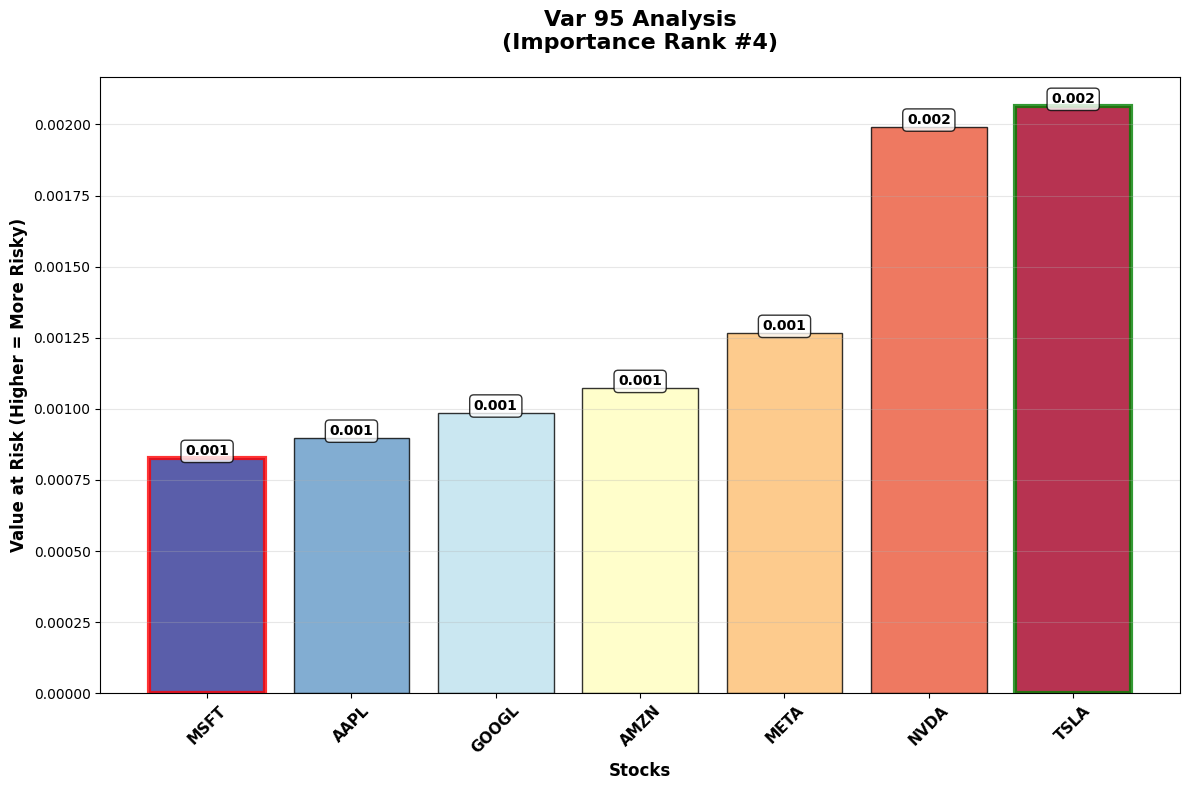

[5/6] Creating plot for var_99...


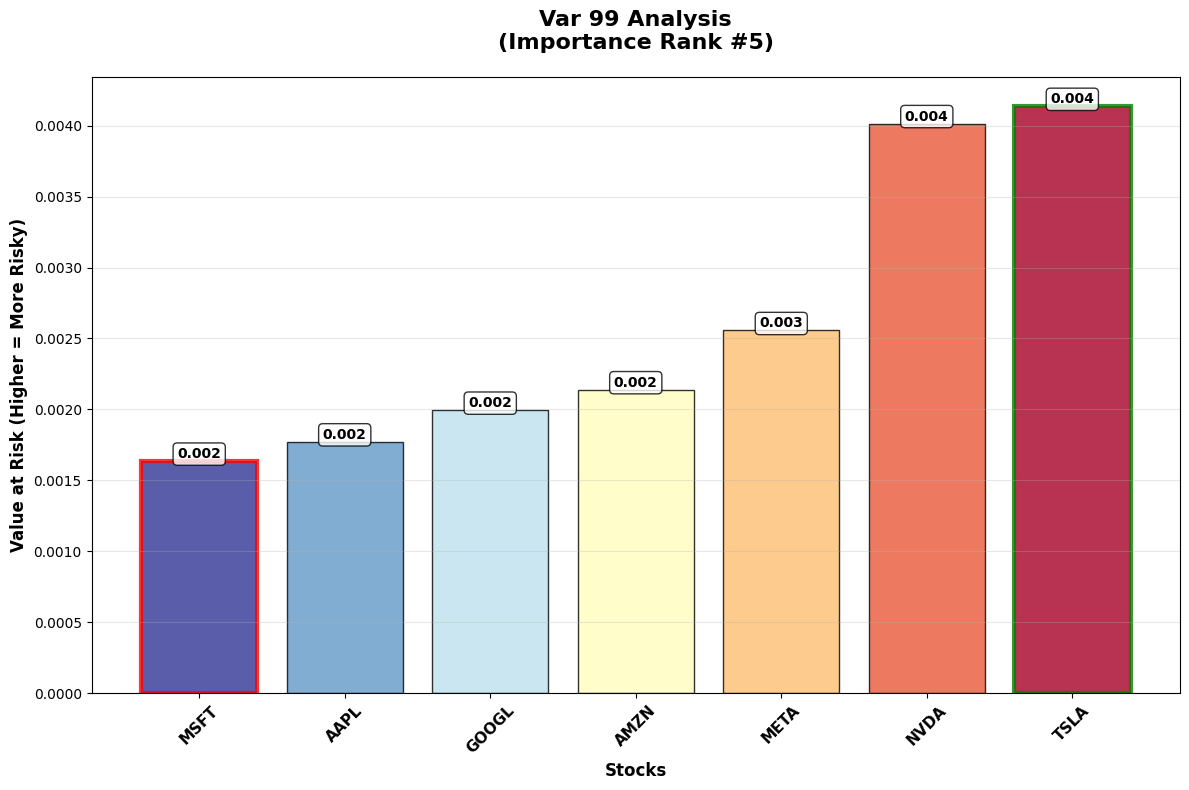

[6/6] Creating plot for daily_volatility...


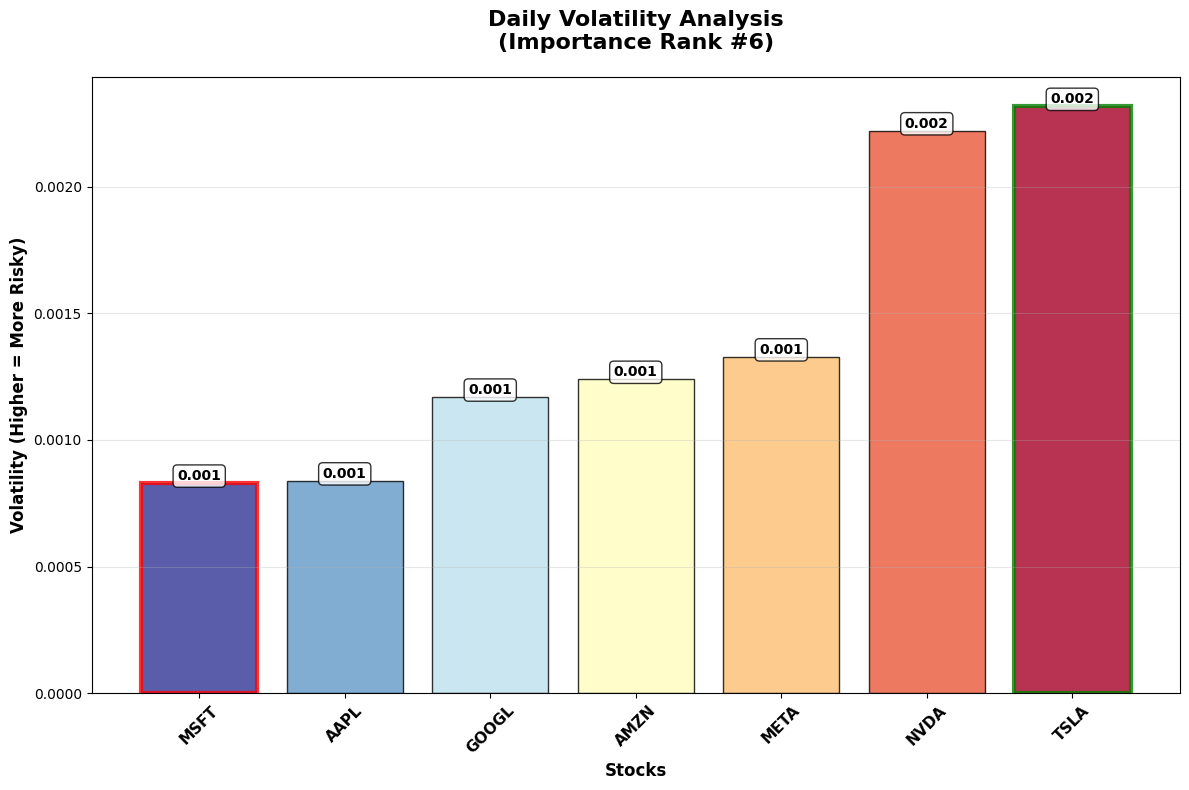


💾 Results saved to: market_volatility_ranking_volatility_ranking_20250611_112309.csv


In [13]:
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class VolatilityRankingAnalyzer:
    def __init__(self, db_config):
        """
        PostgreSQL 변동성 순위 분석기 초기화
        
        db_config 예시:
        {
            'host': '192.168.40.193',
            'database': 'minute',
            'user': 'postgres',
            'password': 'mysecretpassword',
            'port': 5432
        }
        """
        self.db_config = db_config
        self.engine = self._create_connection()
        
        # 변동성 지표 중요도 가중치 (순위별)
        self.volatility_weights = {
            'annual_volatility': 9.5,      # 1위
            'sharpe_ratio': 9.0,           # 2위  
            'max_drawdown': 8.5,           # 3위
            'var_95': 8.0,                 # 4위
            'var_99': 8.0,                 # 4위 (동점)
            'daily_volatility': 7.5,       # 5위
            'price_range_pct': 7.0,        # 6위
            'log_volatility': 6.5,         # 7위
            'skewness': 6.0,               # 8위
            'kurtosis': 5.5                # 9위
        }
        
    def _create_connection(self):
        """PostgreSQL 데이터베이스 연결 생성"""
        try:
            connection_string = f"postgresql://{self.db_config['user']}:{self.db_config['password']}@{self.db_config['host']}:{self.db_config['port']}/{self.db_config['database']}"
            engine = create_engine(connection_string)
            print(f"✅ Database connection established: {self.db_config['host']}:{self.db_config['port']}")
            return engine
        except Exception as e:
            print(f"❌ Database connection failed: {e}")
            raise
    
    def fetch_market_data(self, start_date, end_date=None, symbols=None):
        """PostgreSQL에서 시장 데이터 가져오기"""
        
        base_query = """
        SELECT 
            date, symbol, open, high, low, close, volume
        FROM us_market_data 
        WHERE date >= %(start_date)s
        """
        
        params = {'start_date': start_date}
        
        if end_date:
            base_query += " AND date <= %(end_date)s"
            params['end_date'] = end_date
            
        if symbols:
            # WHERE symbol IN ('AAPL', 'MSFT', ...) 형태로 생성
            symbol_placeholders = ','.join([f"'{symbol}'" for symbol in symbols])
            base_query += f" AND symbol IN ({symbol_placeholders})"
            
        base_query += " ORDER BY symbol, date"
        
        try:
            print(f"🔍 Fetching data from PostgreSQL...")
            print(f"   Start date: {start_date}")
            if end_date:
                print(f"   End date: {end_date}")
            if symbols:
                print(f"   Symbols: {symbols}")
            
            df = pd.read_sql_query(base_query, self.engine, params=params)
            df['date'] = pd.to_datetime(df['date'])
            
            if not df.empty:
                print(f"✅ Successfully fetched {len(df)} records")
                print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
                print(f"   Symbols: {df['symbol'].nunique()} ({df['symbol'].unique()})")
            else:
                print("❌ No data found with given criteria")
                
            return df
            
        except Exception as e:
            print(f"❌ Error fetching data: {e}")
            return pd.DataFrame()
    
    def fetch_symbol_data(self, symbol, start_date, end_date=None):
        """특정 심볼의 데이터만 가져오기"""
        
        query = """
        SELECT 
            date, symbol, open, high, low, close, volume
        FROM us_market_data 
        WHERE symbol = %(symbol)s
        AND date >= %(start_date)s
        """
        
        params = {
            'symbol': symbol,
            'start_date': start_date
        }
        
        if end_date:
            query += " AND date <= %(end_date)s"
            params['end_date'] = end_date
            
        query += " ORDER BY date"
        
        try:
            df = pd.read_sql_query(query, self.engine, params=params)
            df['date'] = pd.to_datetime(df['date'])
            print(f"✅ {symbol}: {len(df)} records fetched")
            return df
            
        except Exception as e:
            print(f"❌ Error fetching {symbol}: {e}")
            return pd.DataFrame()
    
    def calculate_returns(self, df):
        """수익률 및 기본 지표 계산"""
        if df.empty:
            return df
            
        df = df.copy()
        df = df.sort_values(['symbol', 'date'])
        
        # 심볼별로 그룹화하여 계산
        df['prev_close'] = df.groupby('symbol')['close'].shift(1)
        
        # 일일 수익률
        df['daily_return'] = (df['close'] - df['prev_close']) / df['prev_close']
        
        # 로그 수익률
        df['log_return'] = np.log(df['close'] / df['prev_close'])
        
        # 가격 변동폭
        df['price_range'] = df['high'] - df['low']
        df['price_range_pct'] = df['price_range'] / df['close']
        
        # NaN 제거
        df = df.dropna(subset=['daily_return'])
        
        print(f"📊 Returns calculated for {len(df)} records")
        return df
    
    def calculate_volatility_metrics_by_symbol(self, symbol, start_date, end_date=None):
        """개별 심볼의 변동성 지표 계산"""
        
        # 해당 심볼 데이터 가져오기
        symbol_df = self.fetch_symbol_data(symbol, start_date, end_date)
        
        if symbol_df.empty or len(symbol_df) < 30:
            print(f"⚠️  {symbol}: Insufficient data ({len(symbol_df)} records)")
            return None
        
        # 수익률 계산
        symbol_df = self.calculate_returns(symbol_df)
        
        if symbol_df.empty:
            return None
            
        returns = symbol_df['daily_return'].dropna()
        log_returns = symbol_df['log_return'].dropna()
        
        if len(returns) < 10:
            print(f"⚠️  {symbol}: Insufficient return data ({len(returns)} points)")
            return None
        
        try:
            # 1위: Annual Volatility (연간 변동성)
            daily_vol = returns.std()
            annual_vol = daily_vol * np.sqrt(252)
            
            # 2위: Sharpe Ratio (샤프 비율)
            avg_return = returns.mean()
            sharpe = (avg_return / daily_vol * np.sqrt(252)) if daily_vol > 0 else 0
            
            # 3위: Maximum Drawdown (최대 손실폭)
            cumulative_returns = (1 + returns).cumprod()
            rolling_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - rolling_max) / rolling_max
            max_dd = abs(drawdown.min())
            
            # 4위: VaR (Value at Risk)
            var_95 = abs(returns.quantile(0.05))
            var_99 = abs(returns.quantile(0.01))
            
            # 5위: Daily Volatility (일일 변동성)
            daily_volatility = daily_vol
            
            # 6위: Price Range Percentage (가격 변동폭 비율)
            avg_price_range_pct = symbol_df['price_range_pct'].mean()
            
            # 7위: Log Volatility (로그 변동성)
            log_vol = log_returns.std()
            annual_log_vol = log_vol * np.sqrt(252)
            
            # 8위: Skewness (왜도)
            skew = abs(returns.skew())
            
            # 9위: Kurtosis (첨도)
            kurt = abs(returns.kurtosis())
            
            # 결과 반환
            result = {
                'symbol': symbol,
                'data_points': len(returns),
                'period_start': symbol_df['date'].min().strftime('%Y-%m-%d'),
                'period_end': symbol_df['date'].max().strftime('%Y-%m-%d'),
                
                # 순위별 변동성 지표
                'annual_volatility': annual_vol,
                'sharpe_ratio': sharpe,
                'max_drawdown': max_dd,
                'var_95': var_95,
                'var_99': var_99,
                'daily_volatility': daily_volatility,
                'price_range_pct': avg_price_range_pct,
                'log_volatility': annual_log_vol,
                'skewness': skew,
                'kurtosis': kurt,
                
                # 기본 통계
                'avg_daily_return': avg_return,
                'total_return': (symbol_df['close'].iloc[-1] / symbol_df['close'].iloc[0] - 1),
                'min_return': returns.min(),
                'max_return': returns.max(),
                'avg_volume': symbol_df['volume'].mean()
            }
            
            print(f"✅ {symbol}: Volatility metrics calculated")
            return result
            
        except Exception as e:
            print(f"❌ Error calculating metrics for {symbol}: {e}")
            return None
    
    def calculate_all_volatility_metrics(self, symbols, start_date, end_date=None):
        """모든 심볼의 변동성 지표 계산"""
        
        print(f"🔄 Processing {len(symbols)} symbols...")
        results = []
        
        for i, symbol in enumerate(symbols, 1):
            print(f"[{i}/{len(symbols)}] Processing {symbol}...")
            
            metrics = self.calculate_volatility_metrics_by_symbol(symbol, start_date, end_date)
            
            if metrics:
                results.append(metrics)
            
        if results:
            df = pd.DataFrame(results)
            print(f"✅ Successfully processed {len(results)} symbols")
            return df
        else:
            print("❌ No volatility metrics calculated")
            return pd.DataFrame()
    
    def create_volatility_ranking(self, metrics_df):
        """변동성 지표 기반 종합 순위 생성"""
        if metrics_df.empty:
            return pd.DataFrame()
        
        ranking_df = metrics_df.copy()
        volatility_cols = list(self.volatility_weights.keys())
        
        print("📊 Creating volatility rankings...")
        
        # 각 지표별 순위 계산
        for col in volatility_cols:
            if col in ranking_df.columns:
                if col == 'sharpe_ratio':
                    # Sharpe Ratio는 높을수록 좋음 (역순)
                    ranking_df[f'{col}_rank'] = ranking_df[col].rank(ascending=False)
                else:
                    # 나머지 변동성 지표들은 높을수록 위험함 (정순)
                    ranking_df[f'{col}_rank'] = ranking_df[col].rank(ascending=False)
        
        # 가중 점수 계산
        ranking_df['weighted_score'] = 0
        ranking_df['total_weight'] = 0
        
        for col, weight in self.volatility_weights.items():
            rank_col = f'{col}_rank'
            if rank_col in ranking_df.columns:
                # 순위를 점수로 변환 (1위=10점, 꼴지=1점)
                max_rank = len(ranking_df)
                points = (max_rank + 1 - ranking_df[rank_col]) / max_rank * 10
                ranking_df['weighted_score'] += points * weight
                ranking_df['total_weight'] += weight
        
        # 최종 점수 계산 (0-10 스케일)
        ranking_df['final_score'] = ranking_df['weighted_score'] / ranking_df['total_weight']
        ranking_df['overall_rank'] = ranking_df['final_score'].rank(ascending=False)
        
        # 정렬
        ranking_df = ranking_df.sort_values('overall_rank')
        
        print("✅ Volatility ranking completed")
        return ranking_df
    
    def create_individual_metric_plot(self, ranking_df, metric, plot_title=None):
        """개별 지표에 대한 플롯 생성"""
        if ranking_df.empty or metric not in ranking_df.columns:
            print(f"❌ Cannot create plot for {metric}: Data not available")
            return
        
        # 데이터 정렬 (해당 지표 기준)
        sorted_data = ranking_df.sort_values(metric, ascending=True)
        
        # 플롯 생성
        plt.figure(figsize=(12, 8))
        
        # 색상 설정 (RdYlBu_r 컬러맵 사용)
        colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(sorted_data)))
        
        # 바 차트
        bars = plt.bar(range(len(sorted_data)), sorted_data[metric], 
                      color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        
        # 제목과 축 설정
        if plot_title is None:
            metric_name = metric.replace('_', ' ').title()
            if metric in self.volatility_weights:
                rank = list(self.volatility_weights.keys()).index(metric) + 1
                plot_title = f'{metric_name} Analysis\n(Importance Rank #{rank})'
            else:
                plot_title = f'{metric_name} Analysis'
        
        plt.title(plot_title, fontweight='bold', fontsize=16, pad=20)
        plt.xlabel('Stocks', fontweight='bold', fontsize=12)
        
        # Y축 라벨 설정
        if metric == 'sharpe_ratio':
            plt.ylabel('Sharpe Ratio (Higher = Better)', fontweight='bold', fontsize=12)
        elif 'volatility' in metric:
            plt.ylabel('Volatility (Higher = More Risky)', fontweight='bold', fontsize=12)
        elif metric == 'max_drawdown':
            plt.ylabel('Maximum Drawdown (Higher = More Risky)', fontweight='bold', fontsize=12)
        elif 'var' in metric:
            plt.ylabel('Value at Risk (Higher = More Risky)', fontweight='bold', fontsize=12)
        else:
            plt.ylabel('Value', fontweight='bold', fontsize=12)
        
        # X축 설정
        plt.xticks(range(len(sorted_data)), sorted_data['symbol'], 
                  rotation=45, fontsize=11, fontweight='bold')
        
        # 그리드 추가
        plt.grid(True, alpha=0.3, axis='y')
        
        # 값 표시
        for i, (bar, value) in enumerate(zip(bars, sorted_data[metric])):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.3f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        # 최고/최저 강조
        if len(sorted_data) > 0:
            best_idx = 0 if metric == 'sharpe_ratio' else len(sorted_data) - 1
            worst_idx = len(sorted_data) - 1 if metric == 'sharpe_ratio' else 0
            
            # 테두리 강조
            bars[best_idx].set_edgecolor('green')
            bars[best_idx].set_linewidth(3)
            bars[worst_idx].set_edgecolor('red')
            bars[worst_idx].set_linewidth(3)
        
        plt.tight_layout()
        plt.show()
        
    def create_all_individual_plots(self, ranking_df):
        """모든 주요 지표에 대한 개별 플롯 생성"""
        if ranking_df.empty:
            print("❌ No data to visualize")
            return
        
        # 주요 6개 지표 (중요도 순위별)
        main_metrics = ['annual_volatility', 'sharpe_ratio', 'max_drawdown', 
                       'var_95', 'var_99', 'daily_volatility']
        
        print("📊 Creating individual volatility plots...")
        
        for i, metric in enumerate(main_metrics, 1):
            if metric in ranking_df.columns:
                print(f"[{i}/{len(main_metrics)}] Creating plot for {metric}...")
                self.create_individual_metric_plot(ranking_df, metric)
            else:
                print(f"⚠️  Skipping {metric}: Not found in data")
    
    def create_comprehensive_overview_plot(self, ranking_df):
        """종합 순위 개요 플롯"""
        if ranking_df.empty:
            print("❌ No data to visualize")
            return
        
        # 최종 점수 기준으로 정렬
        sorted_data = ranking_df.sort_values('final_score', ascending=False)
        
        plt.figure(figsize=(14, 10))
        
        # 색상 그라데이션
        colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_data)))
        
        # 바 차트
        bars = plt.bar(range(len(sorted_data)), sorted_data['final_score'], 
                      color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        
        # 제목 설정
        plt.title('🏆 Comprehensive Volatility Ranking\n(Weighted Score Based on All Metrics)', 
                 fontweight='bold', fontsize=18, pad=20)
        plt.xlabel('Stocks (Ranked by Overall Performance)', fontweight='bold', fontsize=14)
        plt.ylabel('Weighted Volatility Score (0-10)', fontweight='bold', fontsize=14)
        
        # X축 설정
        plt.xticks(range(len(sorted_data)), sorted_data['symbol'], 
                  rotation=45, fontsize=12, fontweight='bold')
        
        # 그리드 추가
        plt.grid(True, alpha=0.3, axis='y')
        
        # 점수 표시
        for i, (bar, value, rank) in enumerate(zip(bars, sorted_data['final_score'], sorted_data['overall_rank'])):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'#{int(rank)}\n{value:.2f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))
        
        # 1위와 꼴찌 강조
        if len(bars) > 0:
            bars[0].set_edgecolor('gold')
            bars[0].set_linewidth(4)
            if len(bars) > 1:
                bars[-1].set_edgecolor('red')
                bars[-1].set_linewidth(3)
        
        # 범례 추가
        plt.figtext(0.02, 0.02, 
                   'Note: Lower volatility generally indicates better risk-adjusted performance\n'
                   'Gold border = Best performer, Red border = Highest risk',
                   fontsize=10, style='italic')
        
        plt.tight_layout()
        plt.show()
    
    def generate_ranking_report(self, symbols, start_date, end_date=None, save_to_file=None):
        """종합 변동성 순위 보고서 생성"""
        
        print("="*70)
        print("🏆 MARKET VOLATILITY RANKING ANALYSIS REPORT")
        print("="*70)
        print(f"📅 Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"📊 Database: {self.db_config['host']}:{self.db_config['port']}/{self.db_config['database']}")
        print(f"📈 Period: {start_date} ~ {end_date or 'Latest'}")
        print(f"🎯 Symbols: {symbols}")
        print("-"*70)
        
        # 변동성 지표 중요도 출력
        print("\n📋 VOLATILITY METRICS IMPORTANCE RANKING:")
        print("-"*50)
        for i, (metric, weight) in enumerate(self.volatility_weights.items(), 1):
            metric_name = metric.replace('_', ' ').title()
            print(f"{i:2d}. {metric_name:<25} (Weight: {weight:4.1f}/10)")
        
        # 변동성 지표 계산
        metrics_df = self.calculate_all_volatility_metrics(symbols, start_date, end_date)
        
        if metrics_df.empty:
            print("\n❌ No volatility metrics could be calculated")
            return None
        
        # 순위 생성
        ranking_df = self.create_volatility_ranking(metrics_df)
        
        # 결과 출력
        print(f"\n🏆 STOCK VOLATILITY RANKING (Weighted Score):")
        print("-"*80)
        print(f"{'Rank':<4} {'Symbol':<8} {'Score':<8} {'AnnVol':<8} {'Sharpe':<8} {'MaxDD':<8} {'VaR95':<8}")
        print("-"*80)
        
        for _, row in ranking_df.iterrows():
            print(f"{int(row['overall_rank']):2d}   {row['symbol']:<8} "
                  f"{row['final_score']:6.2f}   "
                  f"{row['annual_volatility']:6.3f}   "
                  f"{row['sharpe_ratio']:6.3f}   "
                  f"{row['max_drawdown']:6.3f}   "
                  f"{row['var_95']:6.3f}")
        
        # 상세 분석
        print(f"\n📊 DETAILED ANALYSIS:")
        print("-"*50)
        best_performer = ranking_df.iloc[0]
        worst_performer = ranking_df.iloc[-1]
        
        print(f"🥇 Best Overall: {best_performer['symbol']} (Score: {best_performer['final_score']:.2f})")
        print(f"🥉 Worst Overall: {worst_performer['symbol']} (Score: {worst_performer['final_score']:.2f})")
        
        # 각 지표별 1위
        print(f"\n🏅 INDIVIDUAL METRIC LEADERS:")
        print("-"*30)
        for metric in ['annual_volatility', 'sharpe_ratio', 'max_drawdown', 'var_95']:
            if metric == 'sharpe_ratio':
                leader = ranking_df.loc[ranking_df[metric].idxmax()]
                print(f"• Best {metric.replace('_', ' ').title()}: {leader['symbol']} ({leader[metric]:.3f})")
            else:
                leader = ranking_df.loc[ranking_df[metric].idxmax()]
                print(f"• Highest {metric.replace('_', ' ').title()}: {leader['symbol']} ({leader[metric]:.3f})")
        
        # 개별 시각화 (각 플롯을 따로 생성)
        print("\n📊 Generating individual metric visualizations...")
        self.create_comprehensive_overview_plot(ranking_df)
        self.create_all_individual_plots(ranking_df)
        
        # 파일 저장
        if save_to_file:
            try:
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                filename = f"{save_to_file}_volatility_ranking_{timestamp}.csv"
                ranking_df.to_csv(filename, index=False)
                print(f"\n💾 Results saved to: {filename}")
            except Exception as e:
                print(f"❌ Error saving file: {e}")
        
        print("="*70)
        
        return ranking_df

# 사용 예시
def main():
    """메인 실행 함수"""
    
    # PostgreSQL 데이터베이스 설정
    db_config = {
        'host': '192.168.40.193',
        'database': 'minute', 
        'user': 'postgres',
        'password': 'mysecretpassword',
        'port': 5432
    }
    
    try:
        # 분석기 초기화
        analyzer = VolatilityRankingAnalyzer(db_config)
        
        # 분석할 종목들
        symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'GOOG']
        
        # 분석 기간 설정
        start_date = '2024-01-01'
        end_date = '2025-01-01'  # 선택사항
        
        # 종합 순위 분석 실행
        ranking_results = analyzer.generate_ranking_report(
            symbols=symbols,
            start_date=start_date,
            end_date=end_date,
            save_to_file='market_volatility_ranking'
        )
        
        return ranking_results
        
    except Exception as e:
        print(f"❌ Error in main execution: {e}")
        return None

if __name__ == "__main__":
    # 실행
    results = main()

✅ Database connection established: 192.168.40.193:5432
🏆 MARKET VOLATILITY RANKING ANALYSIS REPORT
📅 Generated: 2025-06-11 11:25:25
📊 Database: 192.168.40.193:5432/minute
📈 Period: 2024-01-01 ~ 2025-01-01
🎯 Symbols: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX']
----------------------------------------------------------------------

📋 VOLATILITY METRICS IMPORTANCE RANKING:
--------------------------------------------------
 1. Annual Volatility         (Weight:  9.5/10)
 2. Sharpe Ratio              (Weight:  9.0/10)
 3. Max Drawdown              (Weight:  8.5/10)
 4. Var 95                    (Weight:  8.0/10)
 5. Var 99                    (Weight:  8.0/10)
 6. Daily Volatility          (Weight:  7.5/10)
 7. Price Range Pct           (Weight:  7.0/10)
 8. Log Volatility            (Weight:  6.5/10)
 9. Skewness                  (Weight:  6.0/10)
10. Kurtosis                  (Weight:  5.5/10)
🔄 Processing 8 symbols...
[1/8] Processing AAPL...
✅ AAPL: 97994 records f

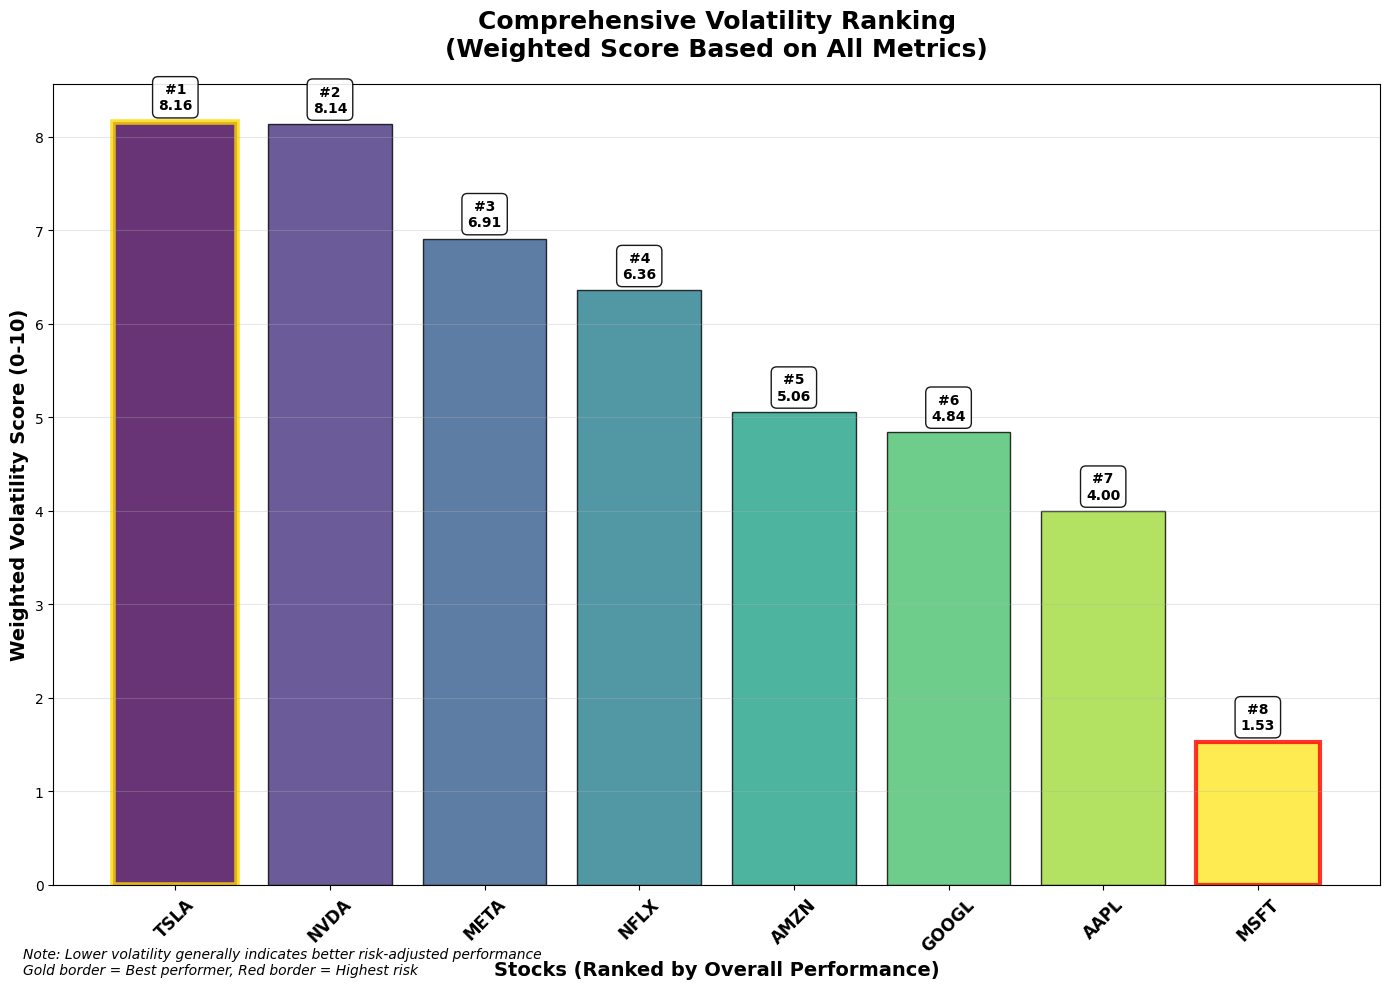

📊 Creating individual volatility plots...
[1/6] Creating plot for annual_volatility...


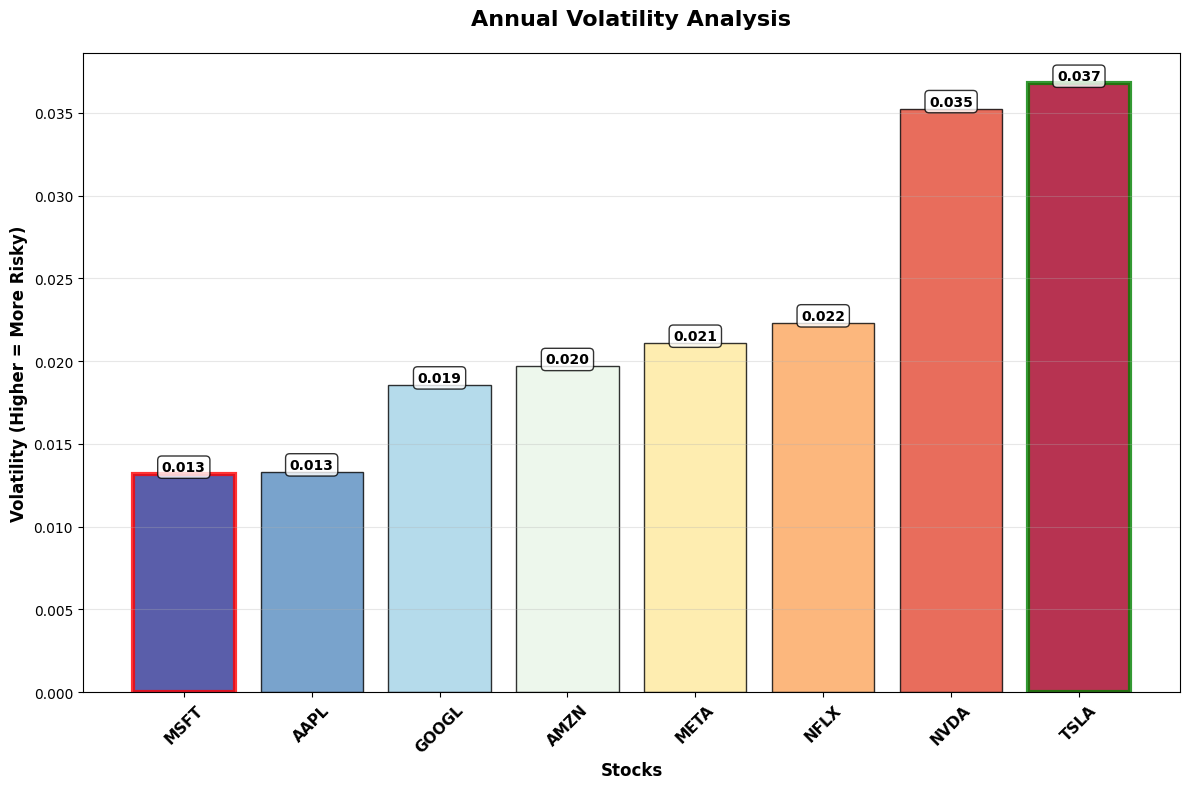

[2/6] Creating plot for sharpe_ratio...


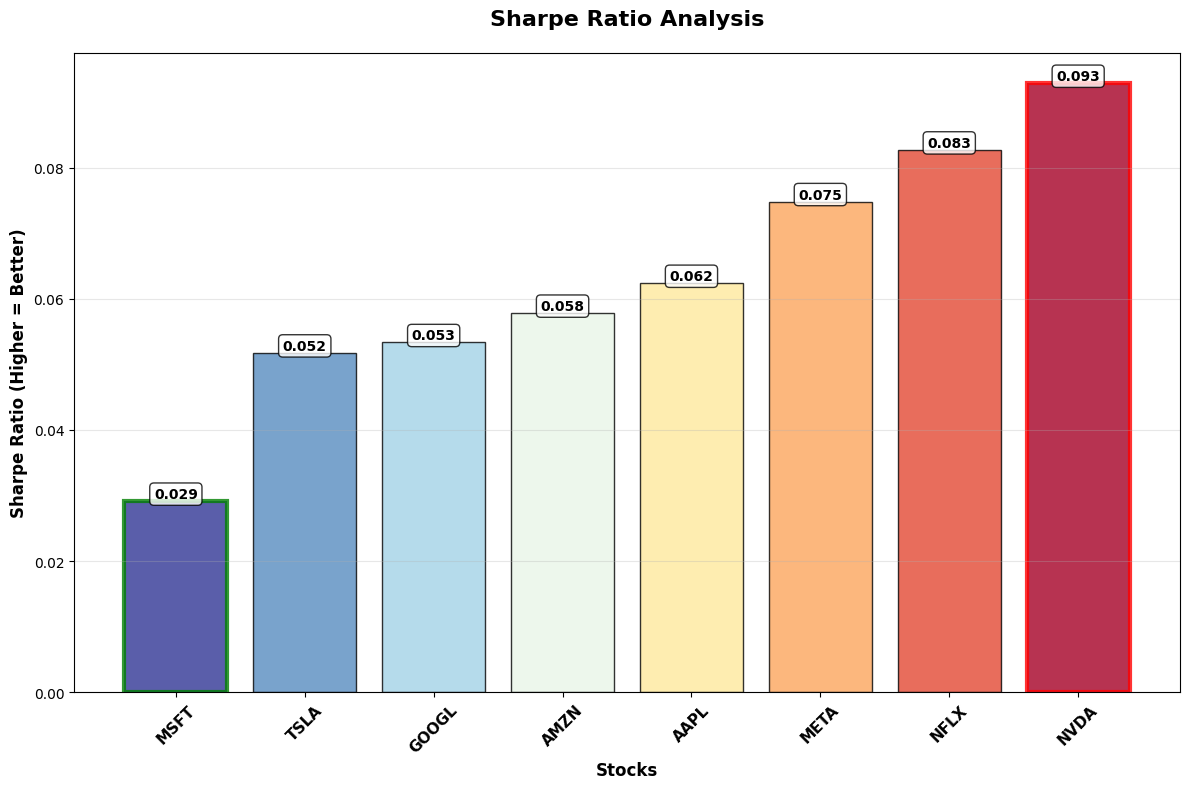

[3/6] Creating plot for max_drawdown...


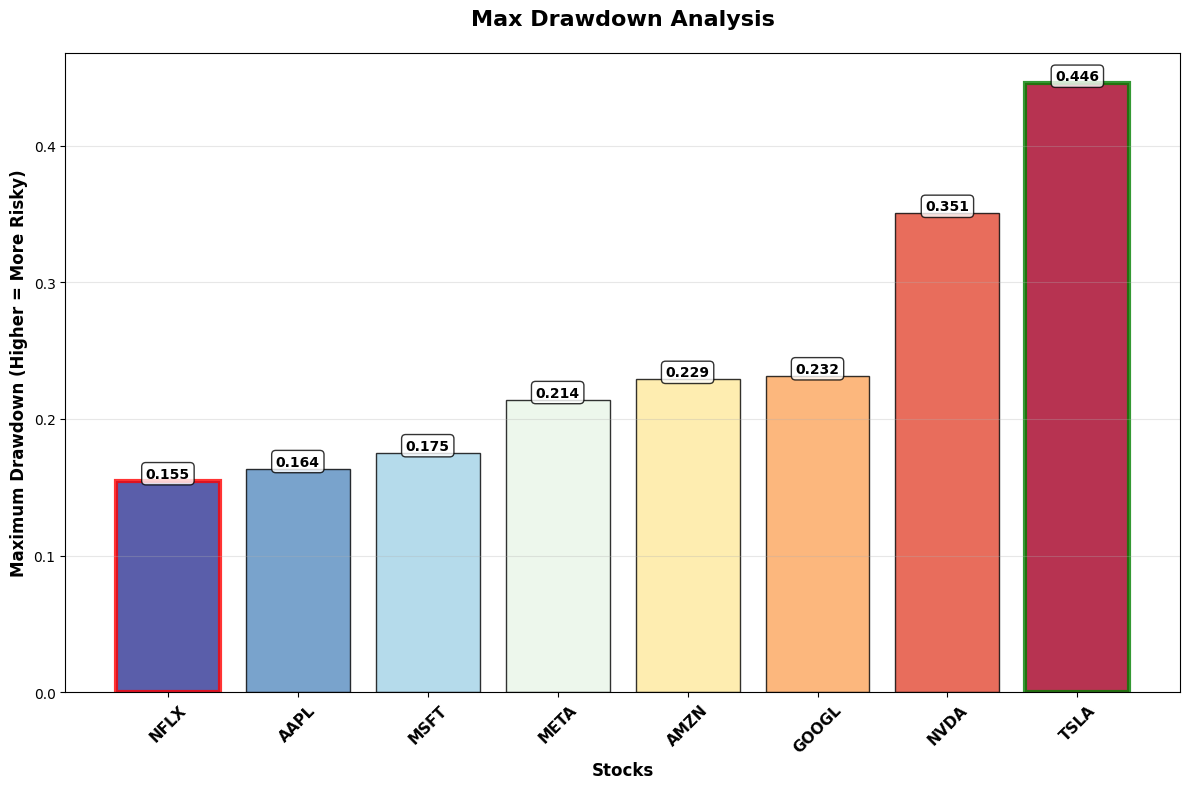

[4/6] Creating plot for var_95...


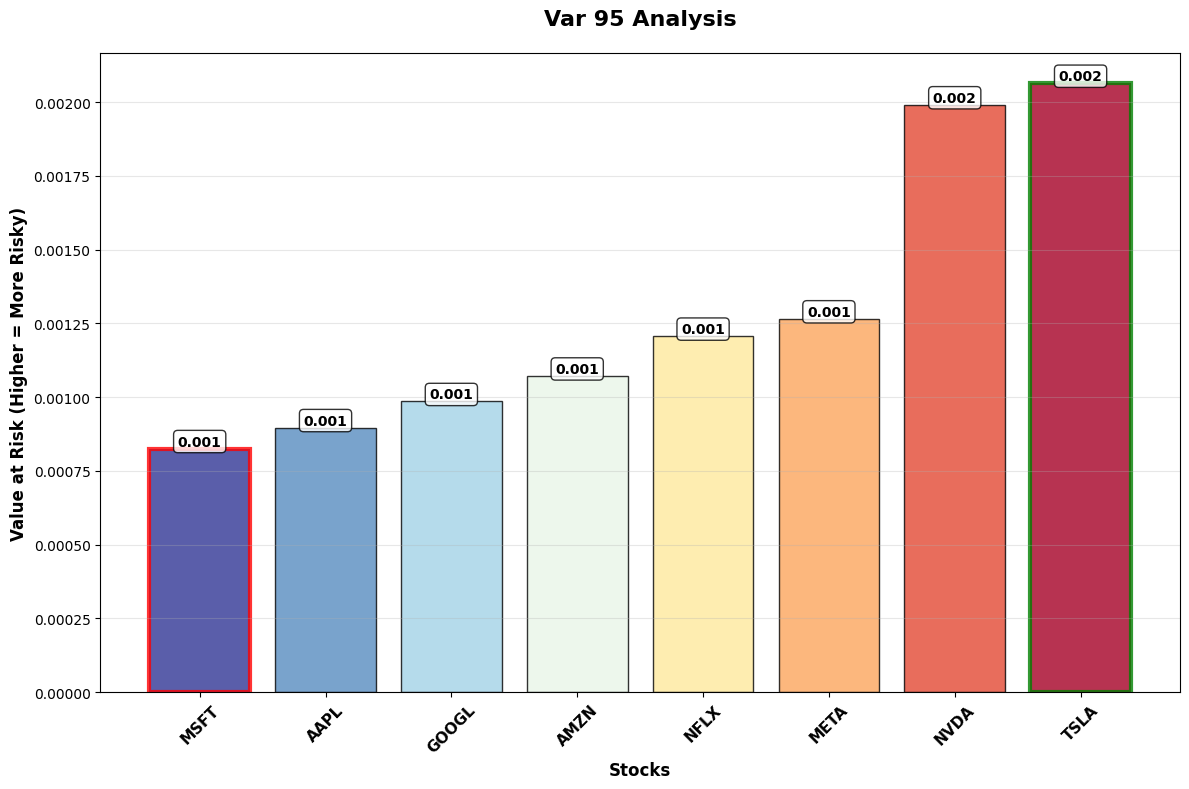

[5/6] Creating plot for var_99...


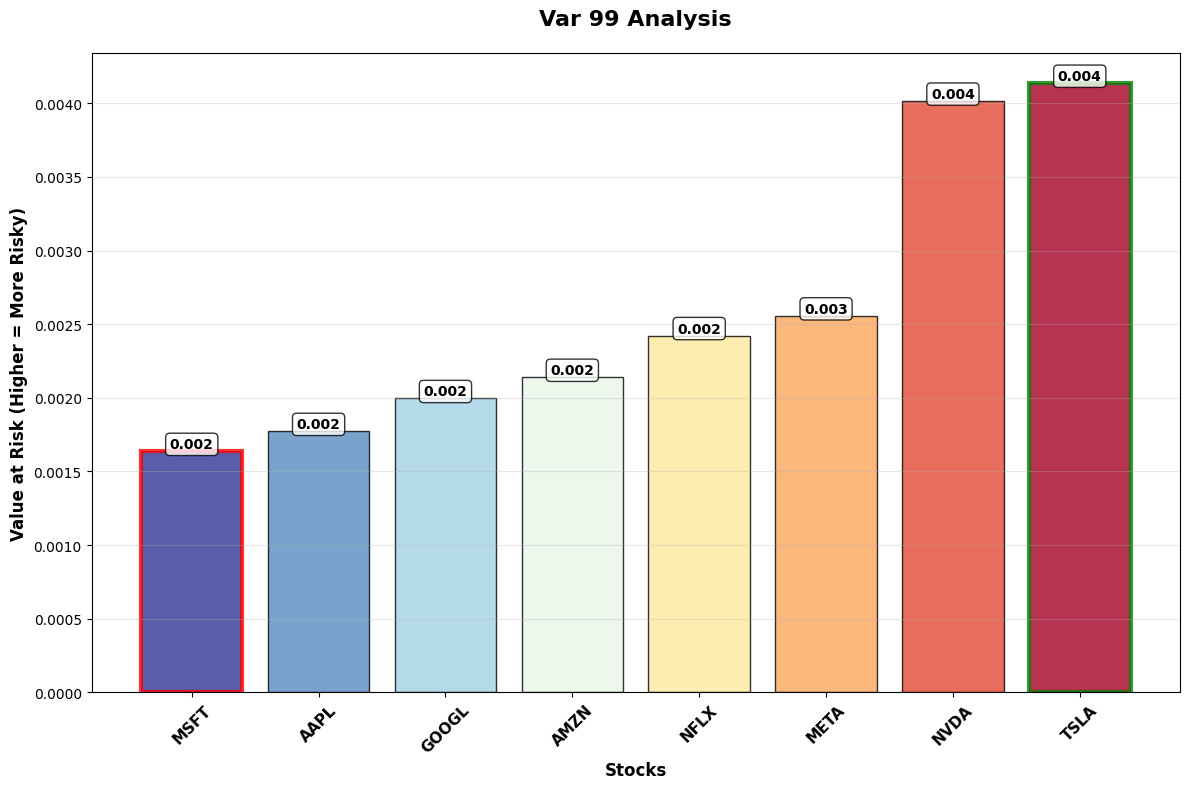

[6/6] Creating plot for daily_volatility...


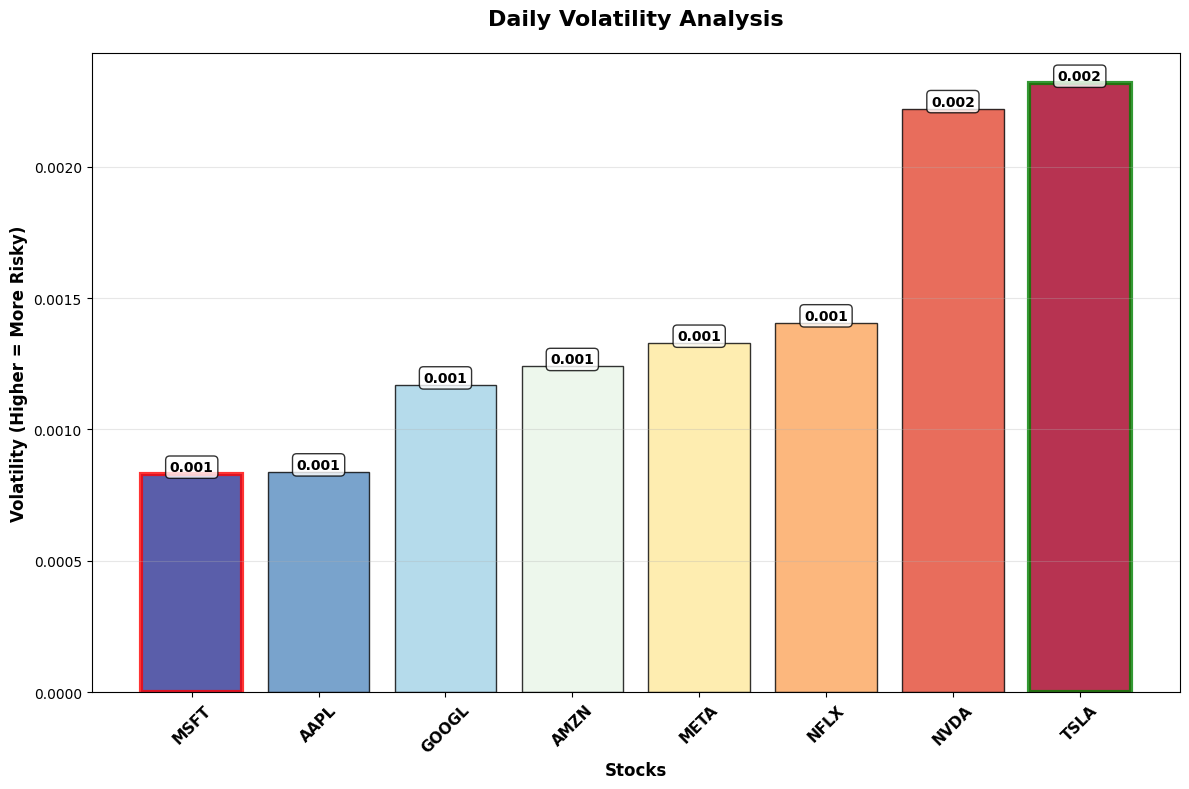


💾 Results saved to: market_volatility_ranking_volatility_ranking_20250611_112547.csv


In [16]:
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class VolatilityRankingAnalyzer:
    def __init__(self, db_config):
        """
        PostgreSQL 변동성 순위 분석기 초기화
        
        db_config 예시:
        {
            'host': '192.168.40.193',
            'database': 'minute',
            'user': 'postgres',
            'password': 'mysecretpassword',
            'port': 5432
        }
        """
        self.db_config = db_config
        self.engine = self._create_connection()
        
        # 변동성 지표 중요도 가중치 (순위별)
        self.volatility_weights = {
            'annual_volatility': 9.5,      # 1위
            'sharpe_ratio': 9.0,           # 2위  
            'max_drawdown': 8.5,           # 3위
            'var_95': 8.0,                 # 4위
            'var_99': 8.0,                 # 4위 (동점)
            'daily_volatility': 7.5,       # 5위
            'price_range_pct': 7.0,        # 6위
            'log_volatility': 6.5,         # 7위
            'skewness': 6.0,               # 8위
            'kurtosis': 5.5                # 9위
        }
        
    def _create_connection(self):
        """PostgreSQL 데이터베이스 연결 생성"""
        try:
            connection_string = f"postgresql://{self.db_config['user']}:{self.db_config['password']}@{self.db_config['host']}:{self.db_config['port']}/{self.db_config['database']}"
            engine = create_engine(connection_string)
            print(f"✅ Database connection established: {self.db_config['host']}:{self.db_config['port']}")
            return engine
        except Exception as e:
            print(f"❌ Database connection failed: {e}")
            raise
    
    def fetch_market_data(self, start_date, end_date=None, symbols=None):
        """PostgreSQL에서 시장 데이터 가져오기"""
        
        base_query = """
        SELECT 
            date, symbol, open, high, low, close, volume
        FROM us_market_data 
        WHERE date >= %(start_date)s
        """
        
        params = {'start_date': start_date}
        
        if end_date:
            base_query += " AND date <= %(end_date)s"
            params['end_date'] = end_date
            
        if symbols:
            # WHERE symbol IN ('AAPL', 'MSFT', ...) 형태로 생성
            symbol_placeholders = ','.join([f"'{symbol}'" for symbol in symbols])
            base_query += f" AND symbol IN ({symbol_placeholders})"
            
        base_query += " ORDER BY symbol, date"
        
        try:
            print(f"🔍 Fetching data from PostgreSQL...")
            print(f"   Start date: {start_date}")
            if end_date:
                print(f"   End date: {end_date}")
            if symbols:
                print(f"   Symbols: {symbols}")
            
            df = pd.read_sql_query(base_query, self.engine, params=params)
            df['date'] = pd.to_datetime(df['date'])
            
            if not df.empty:
                print(f"✅ Successfully fetched {len(df)} records")
                print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
                print(f"   Symbols: {df['symbol'].nunique()} ({df['symbol'].unique()})")
            else:
                print("❌ No data found with given criteria")
                
            return df
            
        except Exception as e:
            print(f"❌ Error fetching data: {e}")
            return pd.DataFrame()
    
    def fetch_symbol_data(self, symbol, start_date, end_date=None):
        """특정 심볼의 데이터만 가져오기"""
        
        query = """
        SELECT 
            *
        FROM us_market_data 
        WHERE symbol = %(symbol)s
        AND date >= %(start_date)s
        """
        
        params = {
            'symbol': symbol,
            'start_date': start_date
        }
        
        if end_date:
            query += " AND date <= %(end_date)s"
            params['end_date'] = end_date
            
        query += " ORDER BY date"
        
        try:
            df = pd.read_sql_query(query, self.engine, params=params)
            df['date'] = pd.to_datetime(df['date'])
            print(f"✅ {symbol}: {len(df)} records fetched")
            return df
            
        except Exception as e:
            print(f"❌ Error fetching {symbol}: {e}")
            return pd.DataFrame()
    
    def calculate_returns(self, df):
        """수익률 및 기본 지표 계산"""
        if df.empty:
            return df
            
        df = df.copy()
        df = df.sort_values(['symbol', 'date'])
        
        # 심볼별로 그룹화하여 계산
        df['prev_close'] = df.groupby('symbol')['close'].shift(1)
        
        # 일일 수익률
        df['daily_return'] = (df['close'] - df['prev_close']) / df['prev_close']
        
        # 로그 수익률
        df['log_return'] = np.log(df['close'] / df['prev_close'])
        
        # 가격 변동폭
        df['price_range'] = df['high'] - df['low']
        df['price_range_pct'] = df['price_range'] / df['close']
        
        # NaN 제거
        df = df.dropna(subset=['daily_return'])
        
        print(f"📊 Returns calculated for {len(df)} records")
        return df
    
    def calculate_volatility_metrics_by_symbol(self, symbol, start_date, end_date=None):
        """개별 심볼의 변동성 지표 계산"""
        
        # 해당 심볼 데이터 가져오기
        symbol_df = self.fetch_symbol_data(symbol, start_date, end_date)
        
        if symbol_df.empty or len(symbol_df) < 30:
            print(f"⚠️  {symbol}: Insufficient data ({len(symbol_df)} records)")
            return None
        
        # 수익률 계산
        symbol_df = self.calculate_returns(symbol_df)
        
        if symbol_df.empty:
            return None
            
        returns = symbol_df['daily_return'].dropna()
        log_returns = symbol_df['log_return'].dropna()
        
        if len(returns) < 10:
            print(f"⚠️  {symbol}: Insufficient return data ({len(returns)} points)")
            return None
        
        try:
            # 1위: Annual Volatility (연간 변동성)
            daily_vol = returns.std()
            annual_vol = daily_vol * np.sqrt(252)
            
            # 2위: Sharpe Ratio (샤프 비율)
            avg_return = returns.mean()
            sharpe = (avg_return / daily_vol * np.sqrt(252)) if daily_vol > 0 else 0
            
            # 3위: Maximum Drawdown (최대 손실폭)
            cumulative_returns = (1 + returns).cumprod()
            rolling_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - rolling_max) / rolling_max
            max_dd = abs(drawdown.min())
            
            # 4위: VaR (Value at Risk)
            var_95 = abs(returns.quantile(0.05))
            var_99 = abs(returns.quantile(0.01))
            
            # 5위: Daily Volatility (일일 변동성)
            daily_volatility = daily_vol
            
            # 6위: Price Range Percentage (가격 변동폭 비율)
            avg_price_range_pct = symbol_df['price_range_pct'].mean()
            
            # 7위: Log Volatility (로그 변동성)
            log_vol = log_returns.std()
            annual_log_vol = log_vol * np.sqrt(252)
            
            # 8위: Skewness (왜도)
            skew = abs(returns.skew())
            
            # 9위: Kurtosis (첨도)
            kurt = abs(returns.kurtosis())
            
            # 결과 반환
            result = {
                'symbol': symbol,
                'data_points': len(returns),
                'period_start': symbol_df['date'].min().strftime('%Y-%m-%d'),
                'period_end': symbol_df['date'].max().strftime('%Y-%m-%d'),
                
                # 순위별 변동성 지표
                'annual_volatility': annual_vol,
                'sharpe_ratio': sharpe,
                'max_drawdown': max_dd,
                'var_95': var_95,
                'var_99': var_99,
                'daily_volatility': daily_volatility,
                'price_range_pct': avg_price_range_pct,
                'log_volatility': annual_log_vol,
                'skewness': skew,
                'kurtosis': kurt,
                
                # 기본 통계
                'avg_daily_return': avg_return,
                'total_return': (symbol_df['close'].iloc[-1] / symbol_df['close'].iloc[0] - 1),
                'min_return': returns.min(),
                'max_return': returns.max(),
                'avg_volume': symbol_df['volume'].mean()
            }
            
            print(f"✅ {symbol}: Volatility metrics calculated")
            return result
            
        except Exception as e:
            print(f"❌ Error calculating metrics for {symbol}: {e}")
            return None
    
    def calculate_all_volatility_metrics(self, symbols, start_date, end_date=None):
        """모든 심볼의 변동성 지표 계산"""
        
        print(f"🔄 Processing {len(symbols)} symbols...")
        results = []
        
        for i, symbol in enumerate(symbols, 1):
            print(f"[{i}/{len(symbols)}] Processing {symbol}...")
            
            metrics = self.calculate_volatility_metrics_by_symbol(symbol, start_date, end_date)
            
            if metrics:
                results.append(metrics)
            
        if results:
            df = pd.DataFrame(results)
            print(f"✅ Successfully processed {len(results)} symbols")
            return df
        else:
            print("❌ No volatility metrics calculated")
            return pd.DataFrame()
    
    def create_volatility_ranking(self, metrics_df):
        """변동성 지표 기반 종합 순위 생성"""
        if metrics_df.empty:
            return pd.DataFrame()
        
        ranking_df = metrics_df.copy()
        volatility_cols = list(self.volatility_weights.keys())
        
        print("📊 Creating volatility rankings...")
        
        # 각 지표별 순위 계산
        for col in volatility_cols:
            if col in ranking_df.columns:
                if col == 'sharpe_ratio':
                    # Sharpe Ratio는 높을수록 좋음 (역순)
                    ranking_df[f'{col}_rank'] = ranking_df[col].rank(ascending=False)
                else:
                    # 나머지 변동성 지표들은 높을수록 위험함 (정순)
                    ranking_df[f'{col}_rank'] = ranking_df[col].rank(ascending=False)
        
        # 가중 점수 계산
        ranking_df['weighted_score'] = 0
        ranking_df['total_weight'] = 0
        
        for col, weight in self.volatility_weights.items():
            rank_col = f'{col}_rank'
            if rank_col in ranking_df.columns:
                # 순위를 점수로 변환 (1위=10점, 꼴지=1점)
                max_rank = len(ranking_df)
                points = (max_rank + 1 - ranking_df[rank_col]) / max_rank * 10
                ranking_df['weighted_score'] += points * weight
                ranking_df['total_weight'] += weight
        
        # 최종 점수 계산 (0-10 스케일)
        ranking_df['final_score'] = ranking_df['weighted_score'] / ranking_df['total_weight']
        ranking_df['overall_rank'] = ranking_df['final_score'].rank(ascending=False)
        
        # 정렬
        ranking_df = ranking_df.sort_values('overall_rank')
        
        print("✅ Volatility ranking completed")
        return ranking_df
    
    def create_individual_metric_plot(self, ranking_df, metric, plot_title=None):
        """개별 지표에 대한 플롯 생성"""
        if ranking_df.empty or metric not in ranking_df.columns:
            print(f"❌ Cannot create plot for {metric}: Data not available")
            return
        
        # 데이터 정렬 (해당 지표 기준)
        sorted_data = ranking_df.sort_values(metric, ascending=True)
        
        # 플롯 생성
        plt.figure(figsize=(12, 8))
        
        # 색상 설정 (RdYlBu_r 컬러맵 사용)
        colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(sorted_data)))
        
        # 바 차트
        bars = plt.bar(range(len(sorted_data)), sorted_data[metric], 
                      color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        
        # 제목과 축 설정
        if plot_title is None:
            metric_name = metric.replace('_', ' ').title()
            plot_title = f'{metric_name} Analysis'
        
        plt.title(plot_title, fontweight='bold', fontsize=16, pad=20)
        plt.xlabel('Stocks', fontweight='bold', fontsize=12)
        
        # Y축 라벨 설정
        if metric == 'sharpe_ratio':
            plt.ylabel('Sharpe Ratio (Higher = Better)', fontweight='bold', fontsize=12)
        elif 'volatility' in metric:
            plt.ylabel('Volatility (Higher = More Risky)', fontweight='bold', fontsize=12)
        elif metric == 'max_drawdown':
            plt.ylabel('Maximum Drawdown (Higher = More Risky)', fontweight='bold', fontsize=12)
        elif 'var' in metric:
            plt.ylabel('Value at Risk (Higher = More Risky)', fontweight='bold', fontsize=12)
        else:
            plt.ylabel('Value', fontweight='bold', fontsize=12)
        
        # X축 설정
        plt.xticks(range(len(sorted_data)), sorted_data['symbol'], 
                  rotation=45, fontsize=11, fontweight='bold')
        
        # 그리드 추가
        plt.grid(True, alpha=0.3, axis='y')
        
        # 값 표시
        for i, (bar, value) in enumerate(zip(bars, sorted_data[metric])):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.3f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        # 최고/최저 강조
        if len(sorted_data) > 0:
            best_idx = 0 if metric == 'sharpe_ratio' else len(sorted_data) - 1
            worst_idx = len(sorted_data) - 1 if metric == 'sharpe_ratio' else 0
            
            # 테두리 강조
            bars[best_idx].set_edgecolor('green')
            bars[best_idx].set_linewidth(3)
            bars[worst_idx].set_edgecolor('red')
            bars[worst_idx].set_linewidth(3)
        
        plt.tight_layout()
        plt.show()
        
    def create_all_individual_plots(self, ranking_df):
        """모든 주요 지표에 대한 개별 플롯 생성"""
        if ranking_df.empty:
            print("❌ No data to visualize")
            return
        
        # 주요 6개 지표 (중요도 순위별)
        main_metrics = ['annual_volatility', 'sharpe_ratio', 'max_drawdown', 
                       'var_95', 'var_99', 'daily_volatility']
        
        print("📊 Creating individual volatility plots...")
        
        for i, metric in enumerate(main_metrics, 1):
            if metric in ranking_df.columns:
                print(f"[{i}/{len(main_metrics)}] Creating plot for {metric}...")
                self.create_individual_metric_plot(ranking_df, metric)
            else:
                print(f"⚠️  Skipping {metric}: Not found in data")
    
    def create_comprehensive_overview_plot(self, ranking_df):
        """종합 순위 개요 플롯"""
        if ranking_df.empty:
            print("❌ No data to visualize")
            return
        
        # 최종 점수 기준으로 정렬
        sorted_data = ranking_df.sort_values('final_score', ascending=False)
        
        plt.figure(figsize=(14, 10))
        
        # 색상 그라데이션
        colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_data)))
        
        # 바 차트
        bars = plt.bar(range(len(sorted_data)), sorted_data['final_score'], 
                      color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        
        # 제목 설정
        plt.title('Comprehensive Volatility Ranking\n(Weighted Score Based on All Metrics)', 
                 fontweight='bold', fontsize=18, pad=20)
        plt.xlabel('Stocks (Ranked by Overall Performance)', fontweight='bold', fontsize=14)
        plt.ylabel('Weighted Volatility Score (0-10)', fontweight='bold', fontsize=14)
        
        # X축 설정
        plt.xticks(range(len(sorted_data)), sorted_data['symbol'], 
                  rotation=45, fontsize=12, fontweight='bold')
        
        # 그리드 추가
        plt.grid(True, alpha=0.3, axis='y')
        
        # 점수 표시
        for i, (bar, value, rank) in enumerate(zip(bars, sorted_data['final_score'], sorted_data['overall_rank'])):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'#{int(rank)}\n{value:.2f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))
        
        # 1위와 꼴찌 강조
        if len(bars) > 0:
            bars[0].set_edgecolor('gold')
            bars[0].set_linewidth(4)
            if len(bars) > 1:
                bars[-1].set_edgecolor('red')
                bars[-1].set_linewidth(3)
        
        # 범례 추가
        plt.figtext(0.02, 0.02, 
                   'Note: Lower volatility generally indicates better risk-adjusted performance\n'
                   'Gold border = Best performer, Red border = Highest risk',
                   fontsize=10, style='italic')
        
        plt.tight_layout()
        plt.show()
    
    def generate_ranking_report(self, symbols, start_date, end_date=None, save_to_file=None):
        """종합 변동성 순위 보고서 생성"""
        
        print("="*70)
        print("🏆 MARKET VOLATILITY RANKING ANALYSIS REPORT")
        print("="*70)
        print(f"📅 Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"📊 Database: {self.db_config['host']}:{self.db_config['port']}/{self.db_config['database']}")
        print(f"📈 Period: {start_date} ~ {end_date or 'Latest'}")
        print(f"🎯 Symbols: {symbols}")
        print("-"*70)
        
        # 변동성 지표 중요도 출력
        print("\n📋 VOLATILITY METRICS IMPORTANCE RANKING:")
        print("-"*50)
        for i, (metric, weight) in enumerate(self.volatility_weights.items(), 1):
            metric_name = metric.replace('_', ' ').title()
            print(f"{i:2d}. {metric_name:<25} (Weight: {weight:4.1f}/10)")
        
        # 변동성 지표 계산
        metrics_df = self.calculate_all_volatility_metrics(symbols, start_date, end_date)
        
        if metrics_df.empty:
            print("\n❌ No volatility metrics could be calculated")
            return None
        
        # 순위 생성
        ranking_df = self.create_volatility_ranking(metrics_df)
        
        # 결과 출력
        print(f"\n🏆 STOCK VOLATILITY RANKING (Weighted Score):")
        print("-"*80)
        print(f"{'Rank':<4} {'Symbol':<8} {'Score':<8} {'AnnVol':<8} {'Sharpe':<8} {'MaxDD':<8} {'VaR95':<8}")
        print("-"*80)
        
        for _, row in ranking_df.iterrows():
            print(f"{int(row['overall_rank']):2d}   {row['symbol']:<8} "
                  f"{row['final_score']:6.2f}   "
                  f"{row['annual_volatility']:6.3f}   "
                  f"{row['sharpe_ratio']:6.3f}   "
                  f"{row['max_drawdown']:6.3f}   "
                  f"{row['var_95']:6.3f}")
        
        # 상세 분석
        print(f"\n📊 DETAILED ANALYSIS:")
        print("-"*50)
        best_performer = ranking_df.iloc[0]
        worst_performer = ranking_df.iloc[-1]
        
        print(f"🥇 Best Overall: {best_performer['symbol']} (Score: {best_performer['final_score']:.2f})")
        print(f"🥉 Worst Overall: {worst_performer['symbol']} (Score: {worst_performer['final_score']:.2f})")
        
        # 각 지표별 1위
        print(f"\n🏅 INDIVIDUAL METRIC LEADERS:")
        print("-"*30)
        for metric in ['annual_volatility', 'sharpe_ratio', 'max_drawdown', 'var_95']:
            if metric == 'sharpe_ratio':
                leader = ranking_df.loc[ranking_df[metric].idxmax()]
                print(f"• Best {metric.replace('_', ' ').title()}: {leader['symbol']} ({leader[metric]:.3f})")
            else:
                leader = ranking_df.loc[ranking_df[metric].idxmax()]
                print(f"• Highest {metric.replace('_', ' ').title()}: {leader['symbol']} ({leader[metric]:.3f})")
        
        # 개별 시각화 (각 플롯을 따로 생성)
        print("\n📊 Generating individual metric visualizations...")
        self.create_comprehensive_overview_plot(ranking_df)
        self.create_all_individual_plots(ranking_df)
        
        # 파일 저장
        if save_to_file:
            try:
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                filename = f"{save_to_file}_volatility_ranking_{timestamp}.csv"
                ranking_df.to_csv(filename, index=False)
                print(f"\n💾 Results saved to: {filename}")
            except Exception as e:
                print(f"❌ Error saving file: {e}")
        
        print("="*70)
        
        return ranking_df

# 사용 예시
def main():
    """메인 실행 함수"""
    
    # PostgreSQL 데이터베이스 설정
    db_config = {
        'host': '192.168.40.193',
        'database': 'minute', 
        'user': 'postgres',
        'password': 'mysecretpassword',
        'port': 5432
    }
    
    try:
        # 분석기 초기화
        analyzer = VolatilityRankingAnalyzer(db_config)
        
        # 분석할 종목들
        symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX']
        
        # 분석 기간 설정
        start_date = '2024-01-01'
        end_date = '2025-01-01'  # 선택사항
        
        # 종합 순위 분석 실행
        ranking_results = analyzer.generate_ranking_report(
            symbols=symbols,
            start_date=start_date,
            end_date=end_date,
            save_to_file='market_volatility_ranking'
        )
        
        return ranking_results
        
    except Exception as e:
        print(f"❌ Error in main execution: {e}")
        return None

if __name__ == "__main__":
    # 실행
    results = main()

✅ Database connection established: 192.168.40.193:5432
🏆 MARKET VOLATILITY RANKING ANALYSIS REPORT
📅 Generated: 2025-06-11 13:55:46
📊 Database: 192.168.40.193:5432/minute
📈 Period: 2024-01-01 ~ 2025-01-01
🎯 Symbols: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX']
----------------------------------------------------------------------

📋 VOLATILITY METRICS IMPORTANCE RANKING:
--------------------------------------------------
 1. Annual Volatility         (Weight:  9.5/10)
 2. Sharpe Ratio              (Weight:  9.0/10)
 3. Max Drawdown              (Weight:  8.5/10)
 4. Var 95                    (Weight:  8.0/10)
 5. Var 99                    (Weight:  8.0/10)
 6. Daily Volatility          (Weight:  7.5/10)
 7. Price Range Pct           (Weight:  7.0/10)
 8. Log Volatility            (Weight:  6.5/10)
 9. Skewness                  (Weight:  6.0/10)
10. Kurtosis                  (Weight:  5.5/10)
🔄 Processing 8 symbols...
[1/8] Processing AAPL...
✅ AAPL: 97994 records f

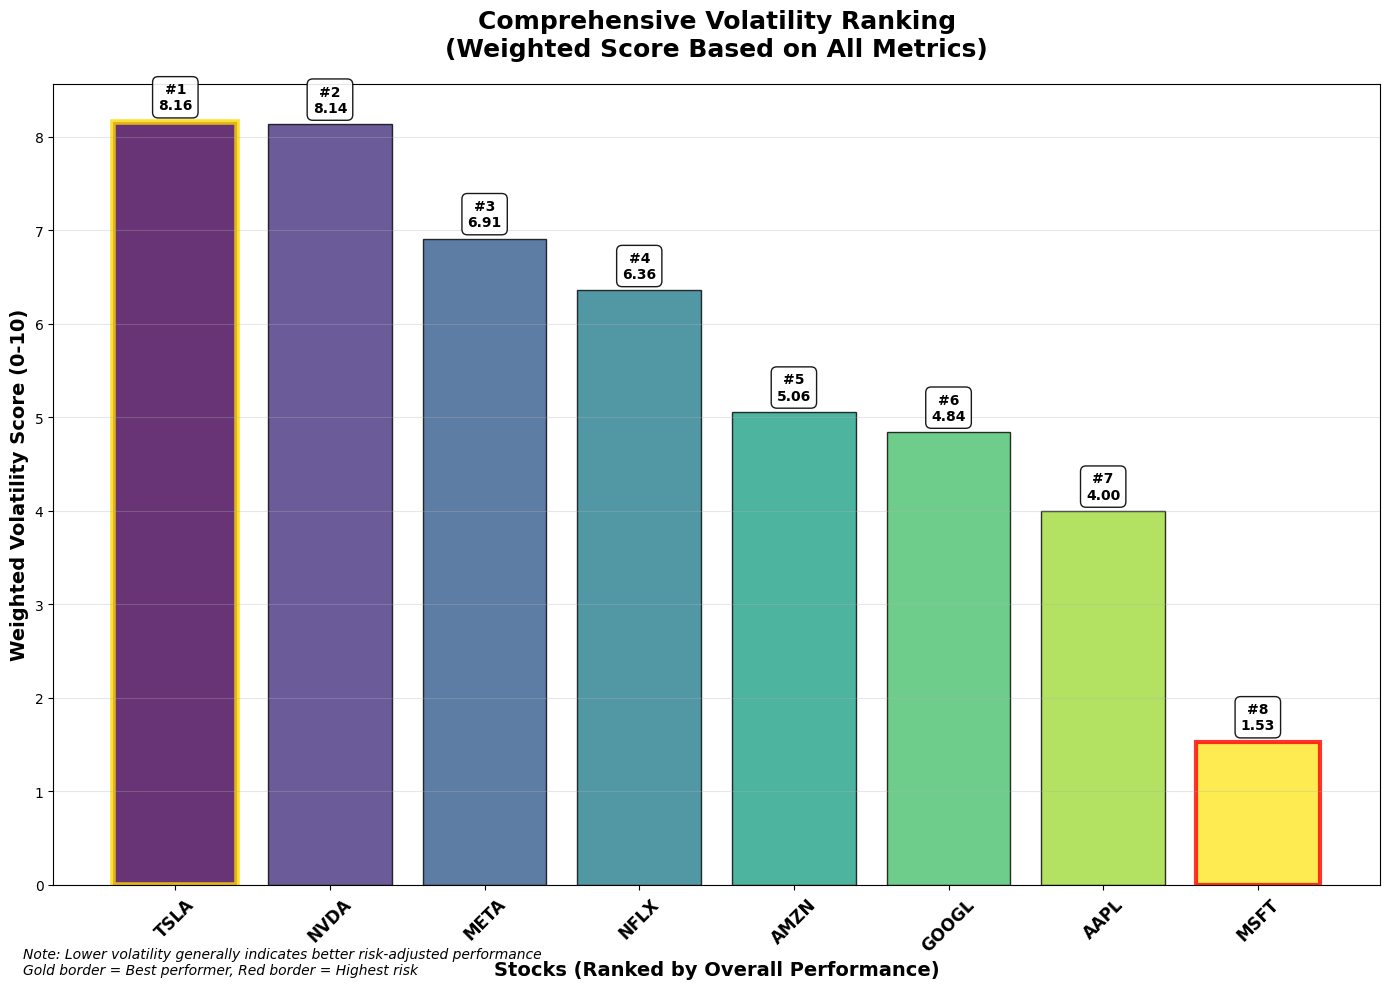

📊 Creating individual volatility plots...
[1/6] Creating plot for annual_volatility...


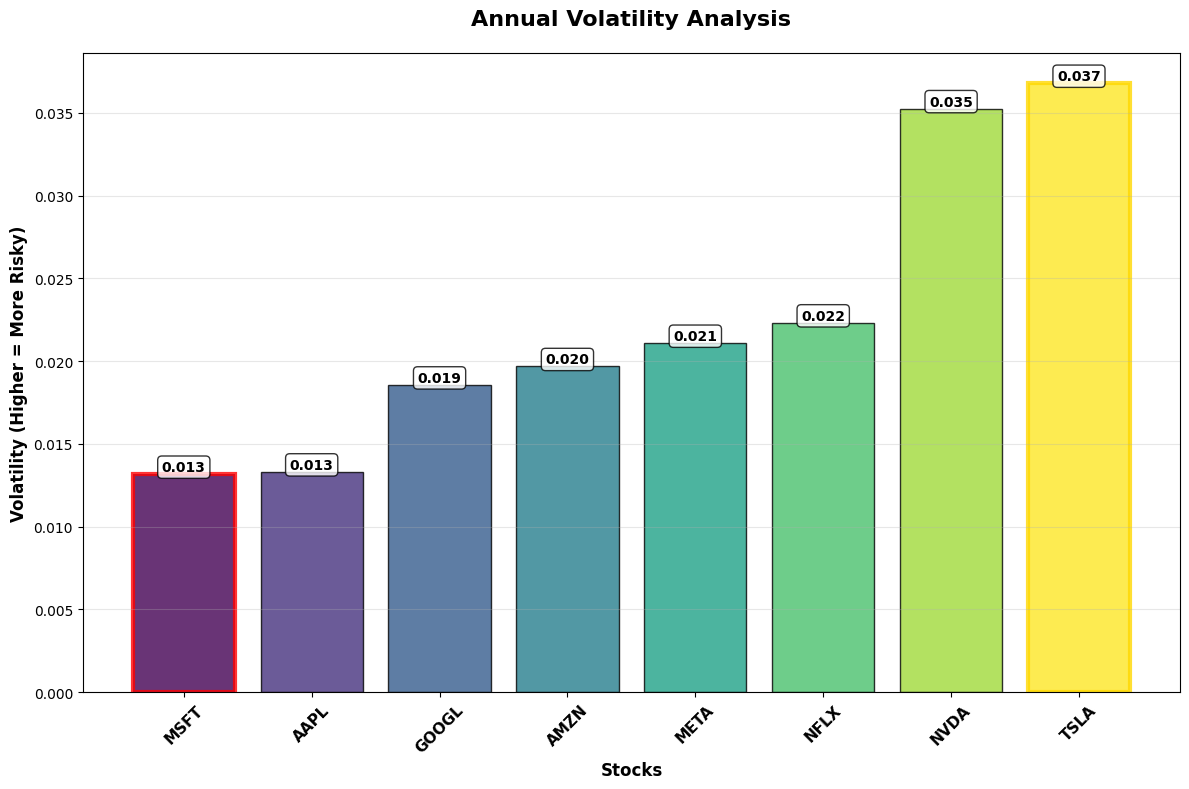

[2/6] Creating plot for sharpe_ratio...


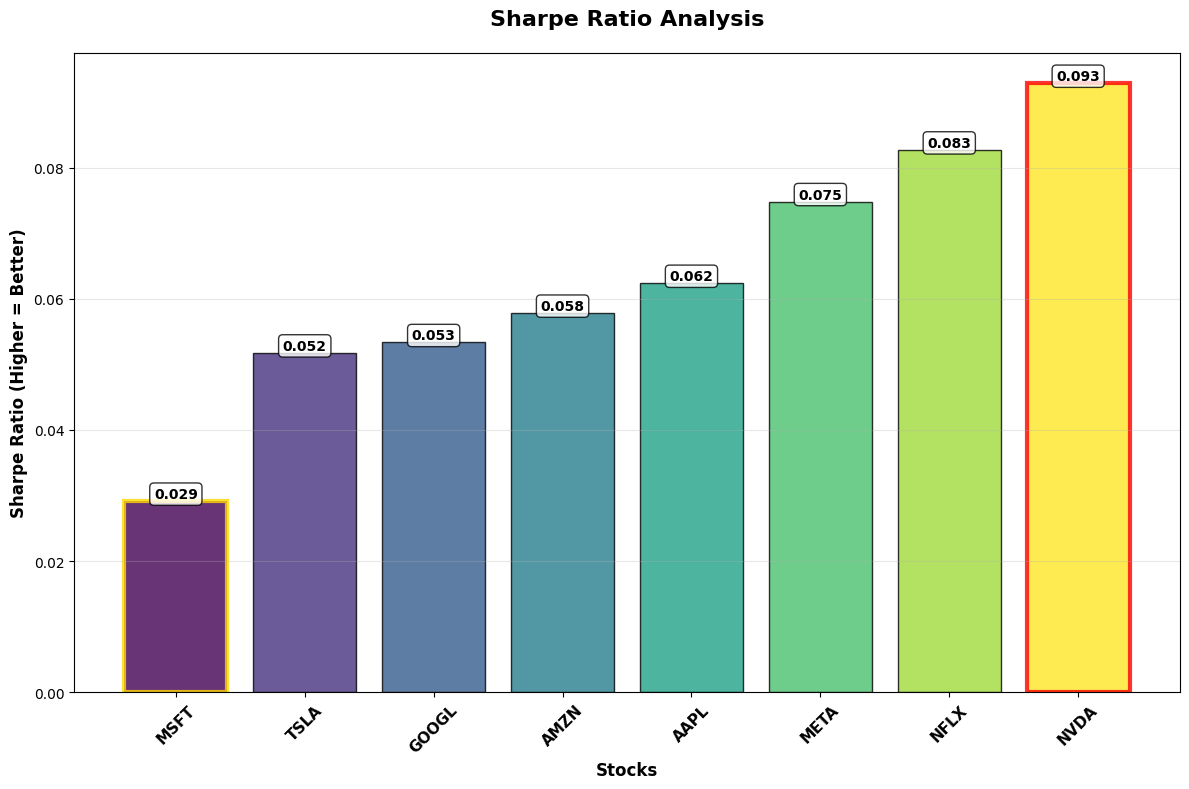

[3/6] Creating plot for max_drawdown...


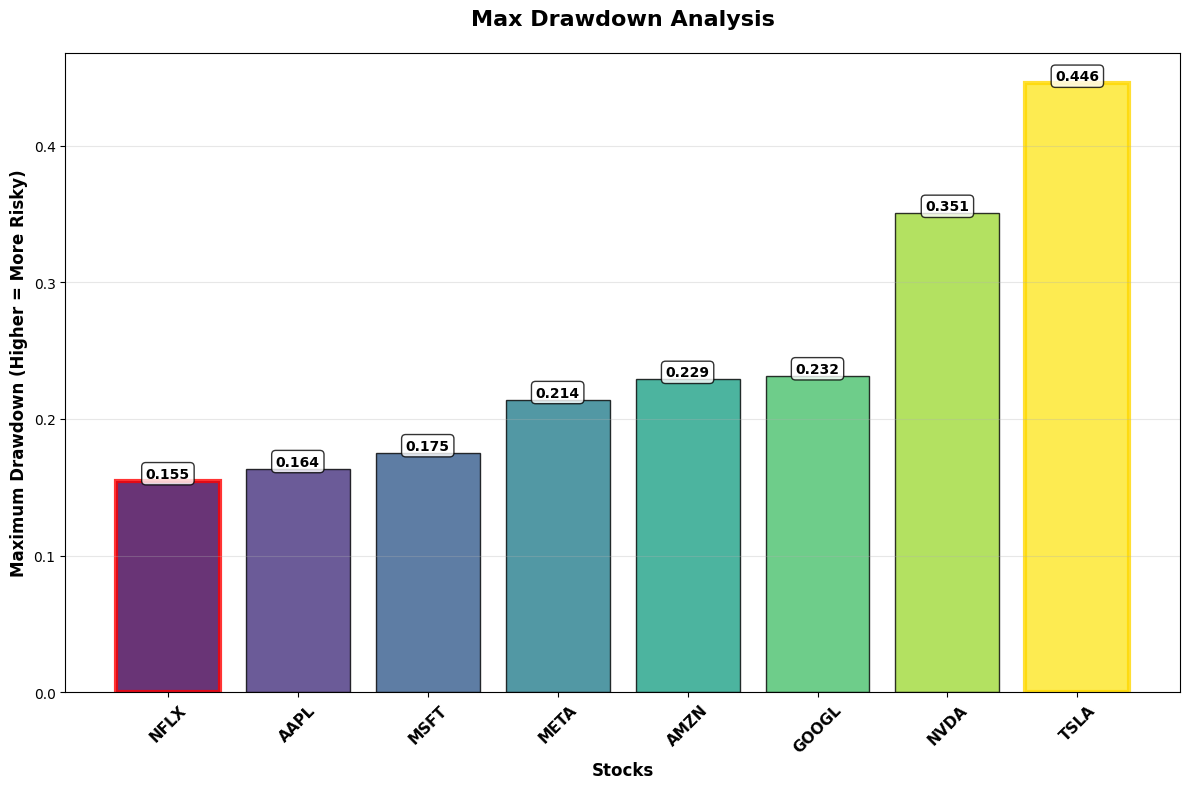

[4/6] Creating plot for var_95...


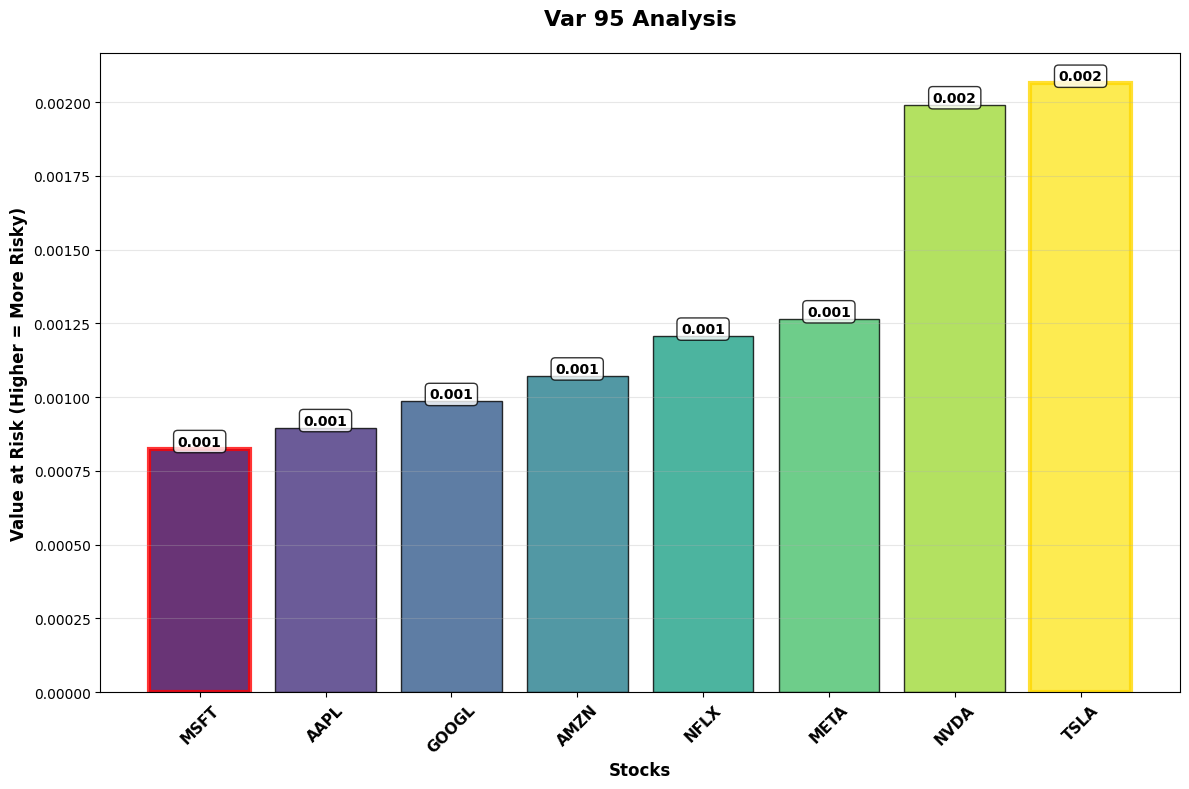

[5/6] Creating plot for var_99...


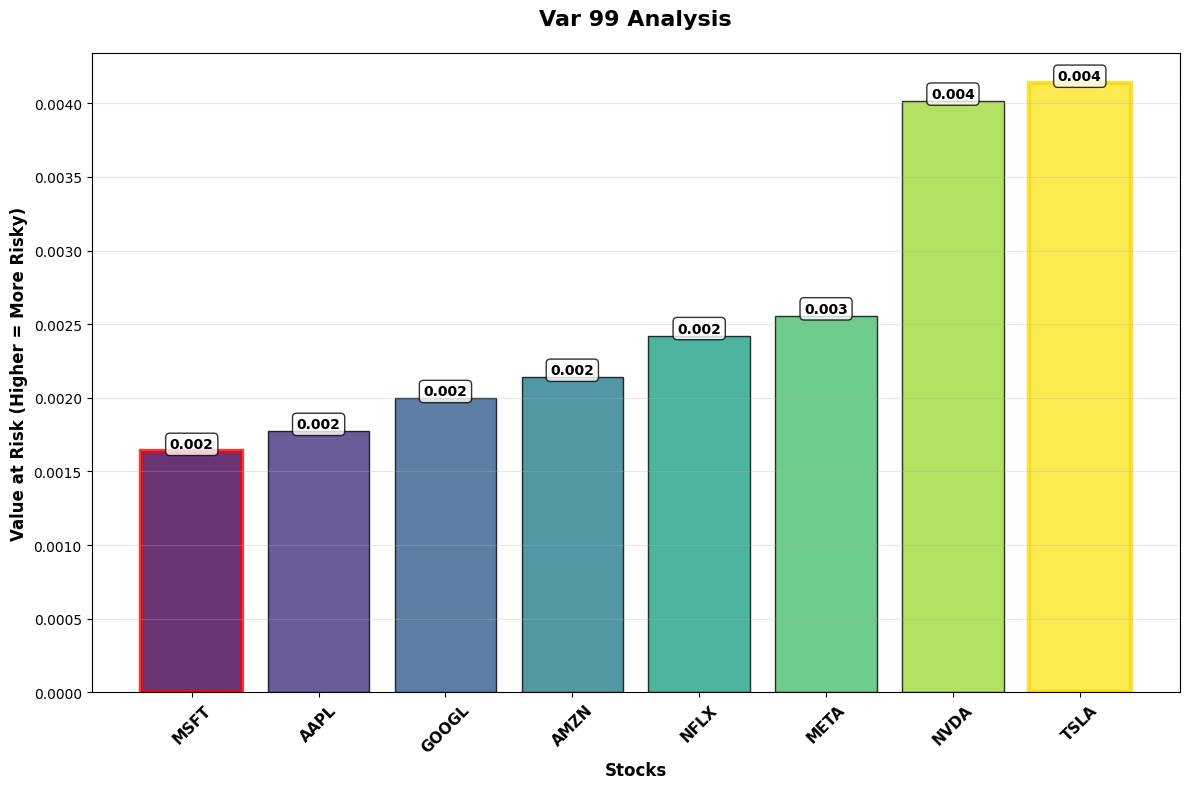

[6/6] Creating plot for daily_volatility...


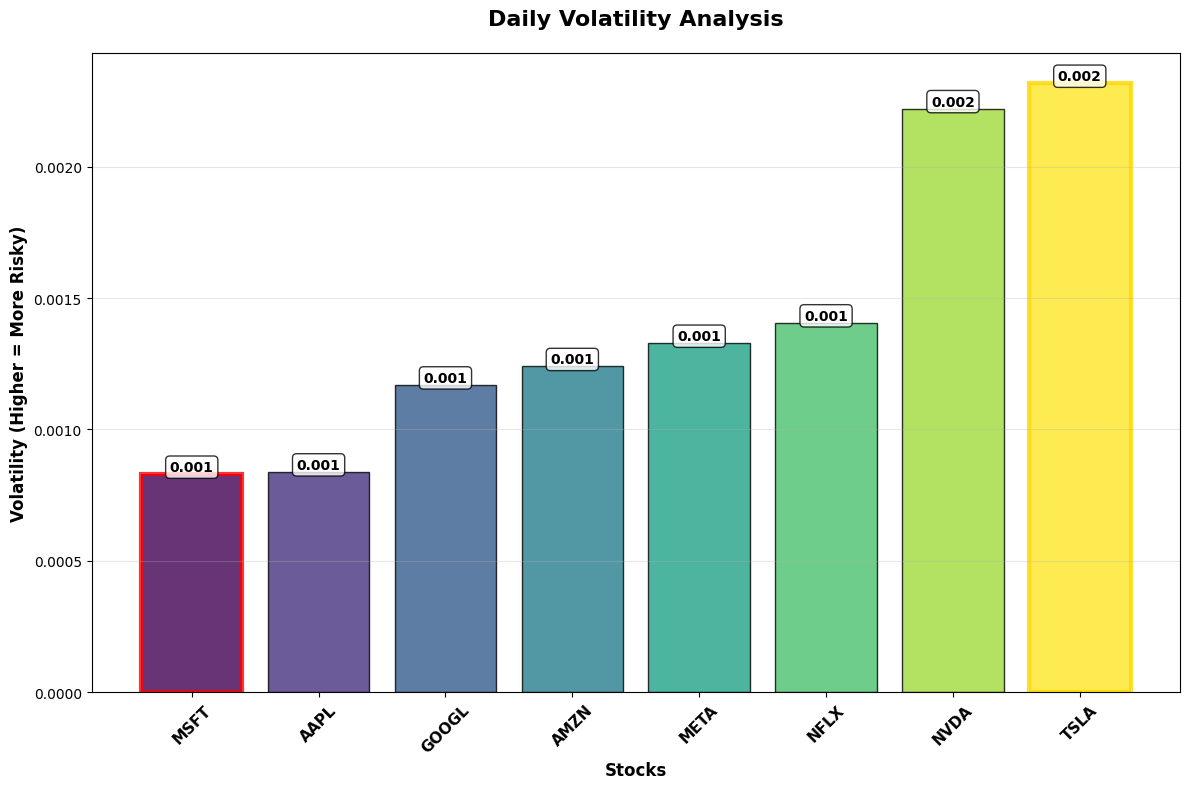


💾 Results saved to: market_volatility_ranking_volatility_ranking_20250611_135603.csv


In [2]:
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class VolatilityRankingAnalyzer:
    def __init__(self, db_config):
        """
        PostgreSQL 변동성 순위 분석기 초기화
        
        db_config 예시:
        {
            'host': '192.168.40.193',
            'database': 'minute',
            'user': 'postgres',
            'password': 'mysecretpassword',
            'port': 5432
        }
        """
        self.db_config = db_config
        self.engine = self._create_connection()
        
        # 변동성 지표 중요도 가중치 (순위별)
        self.volatility_weights = {
            'annual_volatility': 9.5,      # 1위
            'sharpe_ratio': 9.0,           # 2위  
            'max_drawdown': 8.5,           # 3위
            'var_95': 8.0,                 # 4위
            'var_99': 8.0,                 # 4위 (동점)
            'daily_volatility': 7.5,       # 5위
            'price_range_pct': 7.0,        # 6위
            'log_volatility': 6.5,         # 7위
            'skewness': 6.0,               # 8위
            'kurtosis': 5.5                # 9위
        }
        
    def _create_connection(self):
        """PostgreSQL 데이터베이스 연결 생성"""
        try:
            connection_string = f"postgresql://{self.db_config['user']}:{self.db_config['password']}@{self.db_config['host']}:{self.db_config['port']}/{self.db_config['database']}"
            engine = create_engine(connection_string)
            print(f"✅ Database connection established: {self.db_config['host']}:{self.db_config['port']}")
            return engine
        except Exception as e:
            print(f"❌ Database connection failed: {e}")
            raise
    
    def fetch_market_data(self, start_date, end_date=None, symbols=None):
        """PostgreSQL에서 시장 데이터 가져오기"""
        
        base_query = """
        SELECT 
            date, symbol, open, high, low, close, volume
        FROM us_market_data 
        WHERE date >= %(start_date)s
        """
        
        params = {'start_date': start_date}
        
        if end_date:
            base_query += " AND date <= %(end_date)s"
            params['end_date'] = end_date
            
        if symbols:
            # WHERE symbol IN ('AAPL', 'MSFT', ...) 형태로 생성
            symbol_placeholders = ','.join([f"'{symbol}'" for symbol in symbols])
            base_query += f" AND symbol IN ({symbol_placeholders})"
            
        base_query += " ORDER BY symbol, date"
        
        try:
            print(f"🔍 Fetching data from PostgreSQL...")
            print(f"   Start date: {start_date}")
            if end_date:
                print(f"   End date: {end_date}")
            if symbols:
                print(f"   Symbols: {symbols}")
            
            df = pd.read_sql_query(base_query, self.engine, params=params)
            df['date'] = pd.to_datetime(df['date'])
            
            if not df.empty:
                print(f"✅ Successfully fetched {len(df)} records")
                print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
                print(f"   Symbols: {df['symbol'].nunique()} ({df['symbol'].unique()})")
            else:
                print("❌ No data found with given criteria")
                
            return df
            
        except Exception as e:
            print(f"❌ Error fetching data: {e}")
            return pd.DataFrame()
    
    def fetch_symbol_data(self, symbol, start_date, end_date=None):
        """특정 심볼의 데이터만 가져오기"""
        
        query = """
        SELECT 
            *
        FROM us_market_data 
        WHERE symbol = %(symbol)s
        AND date >= %(start_date)s
        """
        
        params = {
            'symbol': symbol,
            'start_date': start_date
        }
        
        if end_date:
            query += " AND date <= %(end_date)s"
            params['end_date'] = end_date
            
        query += " ORDER BY date"
        
        try:
            df = pd.read_sql_query(query, self.engine, params=params)
            df['date'] = pd.to_datetime(df['date'])
            print(f"✅ {symbol}: {len(df)} records fetched")
            return df
            
        except Exception as e:
            print(f"❌ Error fetching {symbol}: {e}")
            return pd.DataFrame()
    
    def calculate_returns(self, df):
        """수익률 및 기본 지표 계산"""
        if df.empty:
            return df
            
        df = df.copy()
        df = df.sort_values(['symbol', 'date'])
        
        # 심볼별로 그룹화하여 계산
        df['prev_close'] = df.groupby('symbol')['close'].shift(1)
        
        # 일일 수익률
        df['daily_return'] = (df['close'] - df['prev_close']) / df['prev_close']
        
        # 로그 수익률
        df['log_return'] = np.log(df['close'] / df['prev_close'])
        
        # 가격 변동폭
        df['price_range'] = df['high'] - df['low']
        df['price_range_pct'] = df['price_range'] / df['close']
        
        # NaN 제거
        df = df.dropna(subset=['daily_return'])
        
        print(f"📊 Returns calculated for {len(df)} records")
        return df
    
    def calculate_volatility_metrics_by_symbol(self, symbol, start_date, end_date=None):
        """개별 심볼의 변동성 지표 계산"""
        
        # 해당 심볼 데이터 가져오기
        symbol_df = self.fetch_symbol_data(symbol, start_date, end_date)
        
        if symbol_df.empty or len(symbol_df) < 30:
            print(f"⚠️  {symbol}: Insufficient data ({len(symbol_df)} records)")
            return None
        
        # 수익률 계산
        symbol_df = self.calculate_returns(symbol_df)
        
        if symbol_df.empty:
            return None
            
        returns = symbol_df['daily_return'].dropna()
        log_returns = symbol_df['log_return'].dropna()
        
        if len(returns) < 10:
            print(f"⚠️  {symbol}: Insufficient return data ({len(returns)} points)")
            return None
        
        try:
            # 1위: Annual Volatility (연간 변동성)
            daily_vol = returns.std()
            annual_vol = daily_vol * np.sqrt(252)
            
            # 2위: Sharpe Ratio (샤프 비율)
            avg_return = returns.mean()
            sharpe = (avg_return / daily_vol * np.sqrt(252)) if daily_vol > 0 else 0
            
            # 3위: Maximum Drawdown (최대 손실폭)
            cumulative_returns = (1 + returns).cumprod()
            rolling_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - rolling_max) / rolling_max
            max_dd = abs(drawdown.min())
            
            # 4위: VaR (Value at Risk)
            var_95 = abs(returns.quantile(0.05))
            var_99 = abs(returns.quantile(0.01))
            
            # 5위: Daily Volatility (일일 변동성)
            daily_volatility = daily_vol
            
            # 6위: Price Range Percentage (가격 변동폭 비율)
            avg_price_range_pct = symbol_df['price_range_pct'].mean()
            
            # 7위: Log Volatility (로그 변동성)
            log_vol = log_returns.std()
            annual_log_vol = log_vol * np.sqrt(252)
            
            # 8위: Skewness (왜도)
            skew = abs(returns.skew())
            
            # 9위: Kurtosis (첨도)
            kurt = abs(returns.kurtosis())
            
            # 결과 반환
            result = {
                'symbol': symbol,
                'data_points': len(returns),
                'period_start': symbol_df['date'].min().strftime('%Y-%m-%d'),
                'period_end': symbol_df['date'].max().strftime('%Y-%m-%d'),
                
                # 순위별 변동성 지표
                'annual_volatility': annual_vol,
                'sharpe_ratio': sharpe,
                'max_drawdown': max_dd,
                'var_95': var_95,
                'var_99': var_99,
                'daily_volatility': daily_volatility,
                'price_range_pct': avg_price_range_pct,
                'log_volatility': annual_log_vol,
                'skewness': skew,
                'kurtosis': kurt,
                
                # 기본 통계
                'avg_daily_return': avg_return,
                'total_return': (symbol_df['close'].iloc[-1] / symbol_df['close'].iloc[0] - 1),
                'min_return': returns.min(),
                'max_return': returns.max(),
                'avg_volume': symbol_df['volume'].mean()
            }
            
            print(f"✅ {symbol}: Volatility metrics calculated")
            return result
            
        except Exception as e:
            print(f"❌ Error calculating metrics for {symbol}: {e}")
            return None
    
    def calculate_all_volatility_metrics(self, symbols, start_date, end_date=None):
        """모든 심볼의 변동성 지표 계산"""
        
        print(f"🔄 Processing {len(symbols)} symbols...")
        results = []
        
        for i, symbol in enumerate(symbols, 1):
            print(f"[{i}/{len(symbols)}] Processing {symbol}...")
            
            metrics = self.calculate_volatility_metrics_by_symbol(symbol, start_date, end_date)
            
            if metrics:
                results.append(metrics)
            
        if results:
            df = pd.DataFrame(results)
            print(f"✅ Successfully processed {len(results)} symbols")
            return df
        else:
            print("❌ No volatility metrics calculated")
            return pd.DataFrame()
    
    def create_volatility_ranking(self, metrics_df):
        """변동성 지표 기반 종합 순위 생성"""
        if metrics_df.empty:
            return pd.DataFrame()
        
        ranking_df = metrics_df.copy()
        volatility_cols = list(self.volatility_weights.keys())
        
        print("📊 Creating volatility rankings...")
        
        # 각 지표별 순위 계산
        for col in volatility_cols:
            if col in ranking_df.columns:
                if col == 'sharpe_ratio':
                    # Sharpe Ratio는 높을수록 좋음 (역순)
                    ranking_df[f'{col}_rank'] = ranking_df[col].rank(ascending=False)
                else:
                    # 나머지 변동성 지표들은 높을수록 위험함 (정순)
                    ranking_df[f'{col}_rank'] = ranking_df[col].rank(ascending=False)
        
        # 가중 점수 계산
        ranking_df['weighted_score'] = 0
        ranking_df['total_weight'] = 0
        
        for col, weight in self.volatility_weights.items():
            rank_col = f'{col}_rank'
            if rank_col in ranking_df.columns:
                # 순위를 점수로 변환 (1위=10점, 꼴지=1점)
                max_rank = len(ranking_df)
                points = (max_rank + 1 - ranking_df[rank_col]) / max_rank * 10
                ranking_df['weighted_score'] += points * weight
                ranking_df['total_weight'] += weight
        
        # 최종 점수 계산 (0-10 스케일)
        ranking_df['final_score'] = ranking_df['weighted_score'] / ranking_df['total_weight']
        ranking_df['overall_rank'] = ranking_df['final_score'].rank(ascending=False)
        
        # 정렬
        ranking_df = ranking_df.sort_values('overall_rank')
        
        print("✅ Volatility ranking completed")
        return ranking_df
    
    def create_individual_metric_plot(self, ranking_df, metric, plot_title=None):
        """개별 지표에 대한 플롯 생성"""
        if ranking_df.empty or metric not in ranking_df.columns:
            print(f"❌ Cannot create plot for {metric}: Data not available")
            return
        
        # 데이터 정렬 (해당 지표 기준)
        sorted_data = ranking_df.sort_values(metric, ascending=True)
        
        # 플롯 생성
        plt.figure(figsize=(12, 8))
        
        # 색상 설정 (viridis 컬러맵으로 통일)
        colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_data)))
        
        # 바 차트
        bars = plt.bar(range(len(sorted_data)), sorted_data[metric], 
                      color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        
        # 제목과 축 설정
        if plot_title is None:
            metric_name = metric.replace('_', ' ').title()
            plot_title = f'{metric_name} Analysis'
        
        plt.title(plot_title, fontweight='bold', fontsize=16, pad=20)
        plt.xlabel('Stocks', fontweight='bold', fontsize=12)
        
        # Y축 라벨 설정
        if metric == 'sharpe_ratio':
            plt.ylabel('Sharpe Ratio (Higher = Better)', fontweight='bold', fontsize=12)
        elif 'volatility' in metric:
            plt.ylabel('Volatility (Higher = More Risky)', fontweight='bold', fontsize=12)
        elif metric == 'max_drawdown':
            plt.ylabel('Maximum Drawdown (Higher = More Risky)', fontweight='bold', fontsize=12)
        elif 'var' in metric:
            plt.ylabel('Value at Risk (Higher = More Risky)', fontweight='bold', fontsize=12)
        else:
            plt.ylabel('Value', fontweight='bold', fontsize=12)
        
        # X축 설정
        plt.xticks(range(len(sorted_data)), sorted_data['symbol'], 
                  rotation=45, fontsize=11, fontweight='bold')
        
        # 그리드 추가
        plt.grid(True, alpha=0.3, axis='y')
        
        # 값 표시
        for i, (bar, value) in enumerate(zip(bars, sorted_data[metric])):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.3f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        # 최고/최저 강조
        if len(sorted_data) > 0:
            best_idx = 0 if metric == 'sharpe_ratio' else len(sorted_data) - 1
            worst_idx = len(sorted_data) - 1 if metric == 'sharpe_ratio' else 0
            
            # 테두리 강조
            bars[best_idx].set_edgecolor('gold')
            bars[best_idx].set_linewidth(3)
            bars[worst_idx].set_edgecolor('red')
            bars[worst_idx].set_linewidth(3)
        
        plt.tight_layout()
        plt.show()
        
    def create_all_individual_plots(self, ranking_df):
        """모든 주요 지표에 대한 개별 플롯 생성"""
        if ranking_df.empty:
            print("❌ No data to visualize")
            return
        
        # 주요 6개 지표 (중요도 순위별)
        main_metrics = ['annual_volatility', 'sharpe_ratio', 'max_drawdown', 
                       'var_95', 'var_99', 'daily_volatility']
        
        print("📊 Creating individual volatility plots...")
        
        for i, metric in enumerate(main_metrics, 1):
            if metric in ranking_df.columns:
                print(f"[{i}/{len(main_metrics)}] Creating plot for {metric}...")
                self.create_individual_metric_plot(ranking_df, metric)
            else:
                print(f"⚠️  Skipping {metric}: Not found in data")
    
    def create_comprehensive_overview_plot(self, ranking_df):
        """종합 순위 개요 플롯"""
        if ranking_df.empty:
            print("❌ No data to visualize")
            return
        
        # 최종 점수 기준으로 정렬
        sorted_data = ranking_df.sort_values('final_score', ascending=False)
        
        plt.figure(figsize=(14, 10))
        
        # 색상 그라데이션 (viridis 컬러맵으로 통일)
        colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_data)))
        
        # 바 차트
        bars = plt.bar(range(len(sorted_data)), sorted_data['final_score'], 
                      color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        
        # 제목 설정
        plt.title('Comprehensive Volatility Ranking\n(Weighted Score Based on All Metrics)', 
                 fontweight='bold', fontsize=18, pad=20)
        plt.xlabel('Stocks (Ranked by Overall Performance)', fontweight='bold', fontsize=14)
        plt.ylabel('Weighted Volatility Score (0-10)', fontweight='bold', fontsize=14)
        
        # X축 설정
        plt.xticks(range(len(sorted_data)), sorted_data['symbol'], 
                  rotation=45, fontsize=12, fontweight='bold')
        
        # 그리드 추가
        plt.grid(True, alpha=0.3, axis='y')
        
        # 점수 표시
        for i, (bar, value, rank) in enumerate(zip(bars, sorted_data['final_score'], sorted_data['overall_rank'])):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'#{int(rank)}\n{value:.2f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))
        
        # 1위와 꼴찌 강조
        if len(bars) > 0:
            bars[0].set_edgecolor('gold')
            bars[0].set_linewidth(4)
            if len(bars) > 1:
                bars[-1].set_edgecolor('red')
                bars[-1].set_linewidth(3)
        
        # 범례 추가
        plt.figtext(0.02, 0.02, 
                   'Note: Lower volatility generally indicates better risk-adjusted performance\n'
                   'Gold border = Best performer, Red border = Highest risk',
                   fontsize=10, style='italic')
        
        plt.tight_layout()
        plt.show()
    
    def generate_ranking_report(self, symbols, start_date, end_date=None, save_to_file=None):
        """종합 변동성 순위 보고서 생성"""
        
        print("="*70)
        print("🏆 MARKET VOLATILITY RANKING ANALYSIS REPORT")
        print("="*70)
        print(f"📅 Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"📊 Database: {self.db_config['host']}:{self.db_config['port']}/{self.db_config['database']}")
        print(f"📈 Period: {start_date} ~ {end_date or 'Latest'}")
        print(f"🎯 Symbols: {symbols}")
        print("-"*70)
        
        # 변동성 지표 중요도 출력
        print("\n📋 VOLATILITY METRICS IMPORTANCE RANKING:")
        print("-"*50)
        for i, (metric, weight) in enumerate(self.volatility_weights.items(), 1):
            metric_name = metric.replace('_', ' ').title()
            print(f"{i:2d}. {metric_name:<25} (Weight: {weight:4.1f}/10)")
        
        # 변동성 지표 계산
        metrics_df = self.calculate_all_volatility_metrics(symbols, start_date, end_date)
        
        if metrics_df.empty:
            print("\n❌ No volatility metrics could be calculated")
            return None
        
        # 순위 생성
        ranking_df = self.create_volatility_ranking(metrics_df)
        
        # 결과 출력
        print(f"\n🏆 STOCK VOLATILITY RANKING (Weighted Score):")
        print("-"*80)
        print(f"{'Rank':<4} {'Symbol':<8} {'Score':<8} {'AnnVol':<8} {'Sharpe':<8} {'MaxDD':<8} {'VaR95':<8}")
        print("-"*80)
        
        for _, row in ranking_df.iterrows():
            print(f"{int(row['overall_rank']):2d}   {row['symbol']:<8} "
                  f"{row['final_score']:6.2f}   "
                  f"{row['annual_volatility']:6.3f}   "
                  f"{row['sharpe_ratio']:6.3f}   "
                  f"{row['max_drawdown']:6.3f}   "
                  f"{row['var_95']:6.3f}")
        
        # 상세 분석
        print(f"\n📊 DETAILED ANALYSIS:")
        print("-"*50)
        best_performer = ranking_df.iloc[0]
        worst_performer = ranking_df.iloc[-1]
        
        print(f"🥇 Best Overall: {best_performer['symbol']} (Score: {best_performer['final_score']:.2f})")
        print(f"🥉 Worst Overall: {worst_performer['symbol']} (Score: {worst_performer['final_score']:.2f})")
        
        # 각 지표별 1위
        print(f"\n🏅 INDIVIDUAL METRIC LEADERS:")
        print("-"*30)
        for metric in ['annual_volatility', 'sharpe_ratio', 'max_drawdown', 'var_95']:
            if metric == 'sharpe_ratio':
                leader = ranking_df.loc[ranking_df[metric].idxmax()]
                print(f"• Best {metric.replace('_', ' ').title()}: {leader['symbol']} ({leader[metric]:.3f})")
            else:
                leader = ranking_df.loc[ranking_df[metric].idxmax()]
                print(f"• Highest {metric.replace('_', ' ').title()}: {leader['symbol']} ({leader[metric]:.3f})")
        
        # 개별 시각화 (각 플롯을 따로 생성)
        print("\n📊 Generating individual metric visualizations...")
        self.create_comprehensive_overview_plot(ranking_df)
        self.create_all_individual_plots(ranking_df)
        
        # 파일 저장
        if save_to_file:
            try:
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                filename = f"{save_to_file}_volatility_ranking_{timestamp}.csv"
                ranking_df.to_csv(filename, index=False)
                print(f"\n💾 Results saved to: {filename}")
            except Exception as e:
                print(f"❌ Error saving file: {e}")
        
        print("="*70)
        
        return ranking_df

# 사용 예시
def main():
    """메인 실행 함수"""
    
    # PostgreSQL 데이터베이스 설정
    db_config = {
        'host': '192.168.40.193',
        'database': 'minute', 
        'user': 'postgres',
        'password': 'mysecretpassword',
        'port': 5432
    }
    
    try:
        # 분석기 초기화
        analyzer = VolatilityRankingAnalyzer(db_config)
        
        # 분석할 종목들
        symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX']
        
        # 분석 기간 설정
        start_date = '2024-01-01'
        end_date = '2025-01-01'  # 선택사항
        
        # 종합 순위 분석 실행
        ranking_results = analyzer.generate_ranking_report(
            symbols=symbols,
            start_date=start_date,
            end_date=end_date,
            save_to_file='market_volatility_ranking'
        )
        
        return ranking_results
        
    except Exception as e:
        print(f"❌ Error in main execution: {e}")
        return None

if __name__ == "__main__":
    # 실행
    results = main()

✅ Database connection established: 192.168.40.193:5432
🏆 MARKET VOLATILITY RANKING ANALYSIS REPORT
📅 Generated: 2025-06-11 14:44:02
📊 Database: 192.168.40.193:5432/minute
📈 Period: 2024-01-01 ~ 2025-01-01
🎯 Symbols: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX']
----------------------------------------------------------------------

📋 VOLATILITY METRICS IMPORTANCE RANKING:
--------------------------------------------------
 1. Annual Volatility         (Weight:  9.5/10)
 2. Sharpe Ratio              (Weight:  9.0/10)
 3. Max Drawdown              (Weight:  8.5/10)
 4. Var 95                    (Weight:  8.0/10)
 5. Var 99                    (Weight:  8.0/10)
 6. Daily Volatility          (Weight:  7.5/10)
 7. Price Range Pct           (Weight:  7.0/10)
 8. Log Volatility            (Weight:  6.5/10)
 9. Skewness                  (Weight:  6.0/10)
10. Kurtosis                  (Weight:  5.5/10)
🔄 Processing 8 symbols...
[1/8] Processing AAPL...
✅ AAPL: 97994 records f

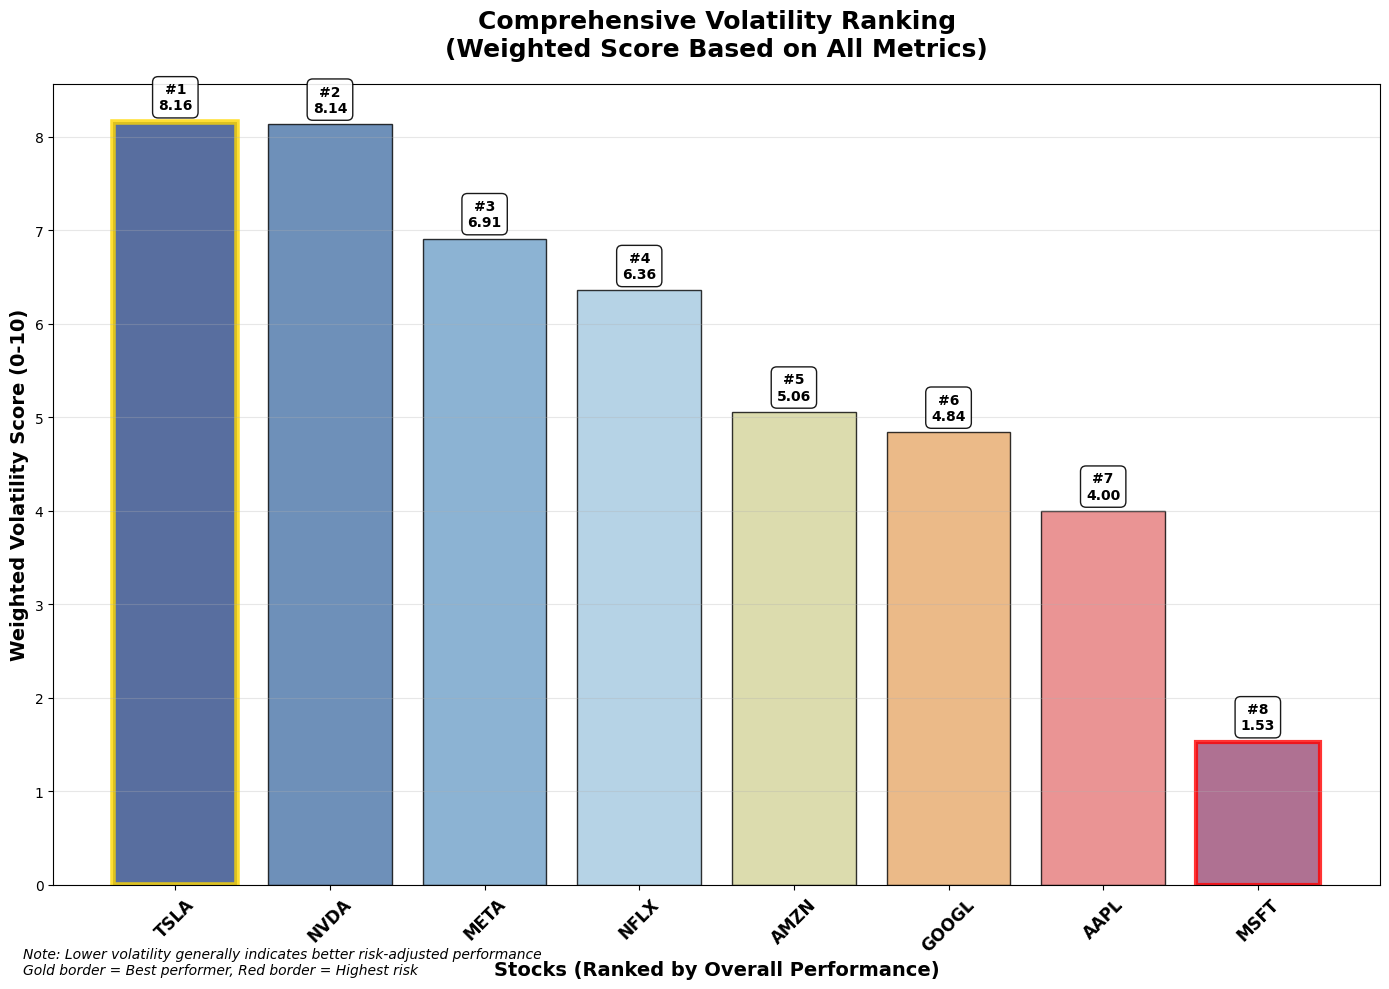

📊 Creating individual volatility plots...
[1/6] Creating plot for annual_volatility...


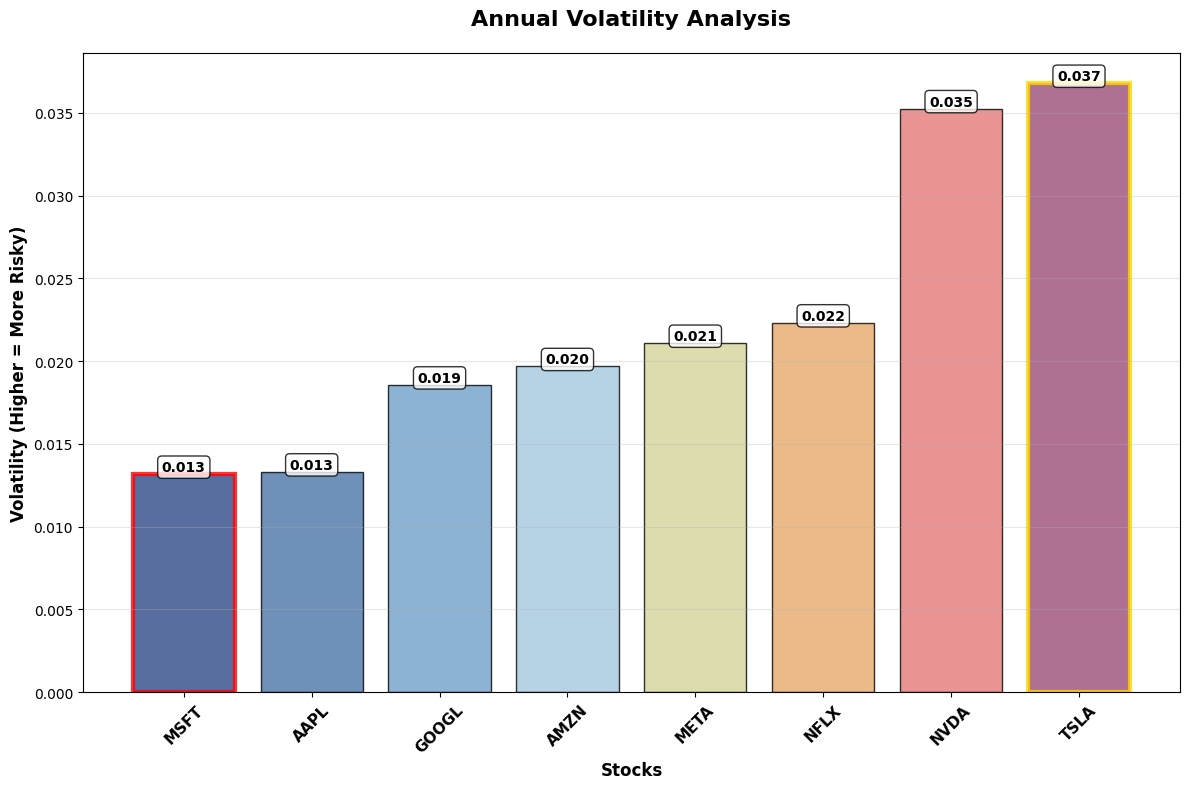

[2/6] Creating plot for sharpe_ratio...


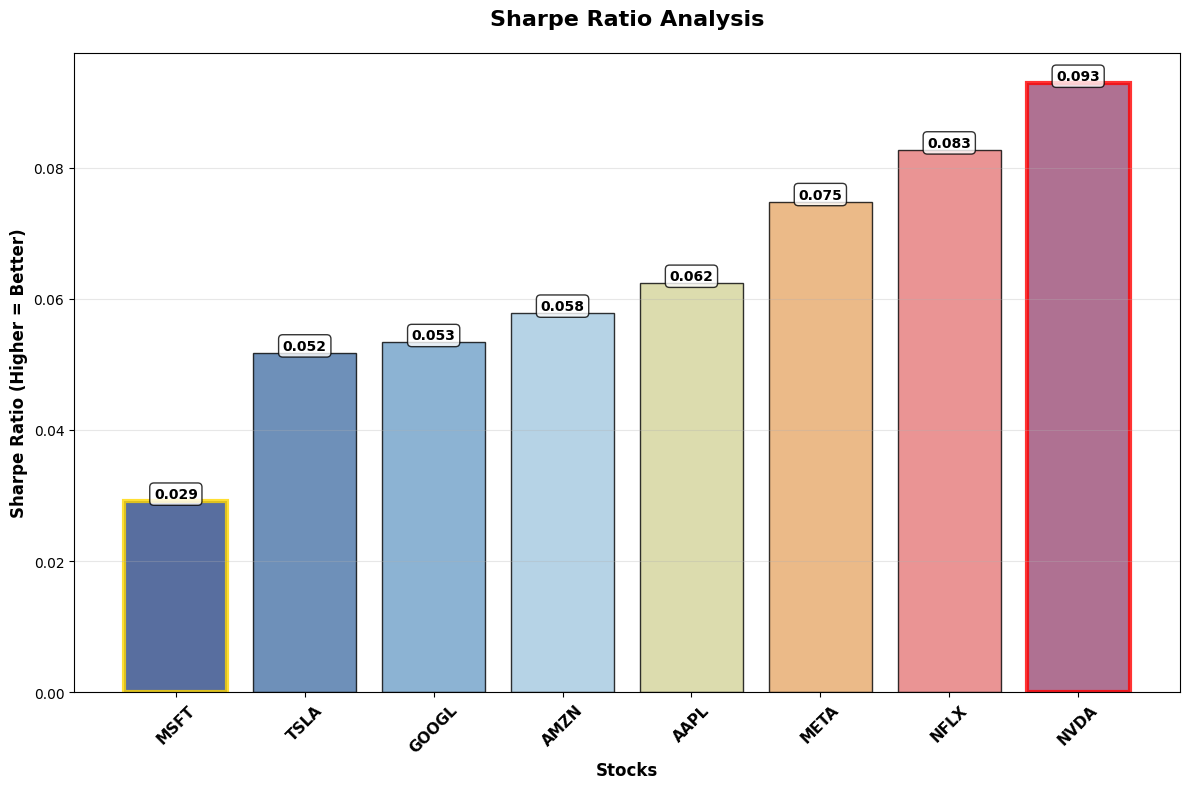

[3/6] Creating plot for max_drawdown...


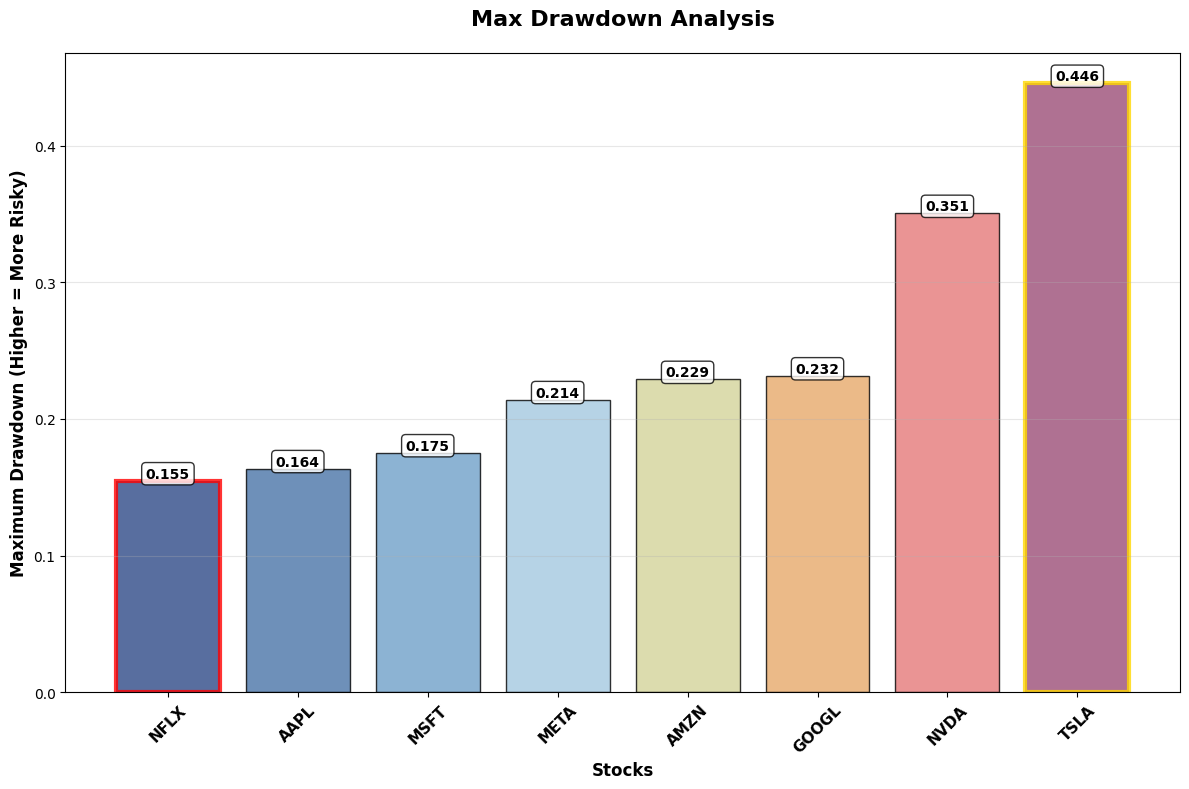

[4/6] Creating plot for var_95...


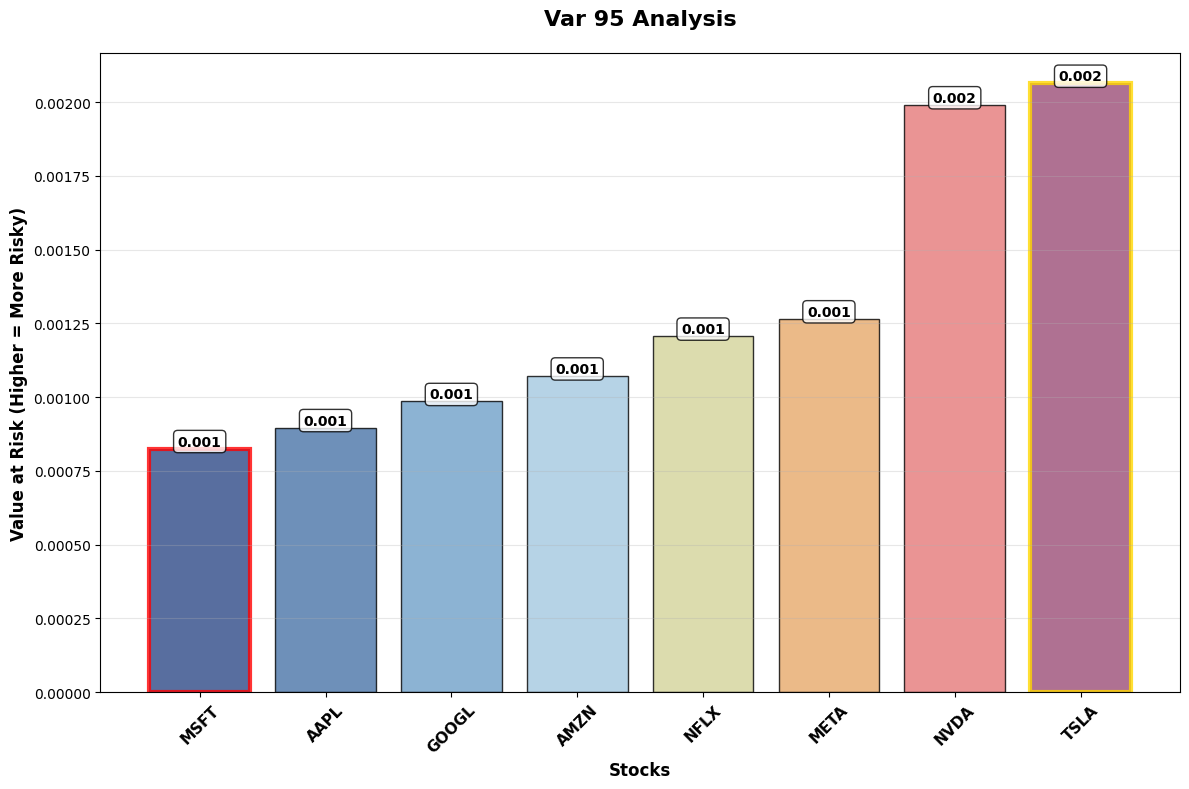

[5/6] Creating plot for var_99...


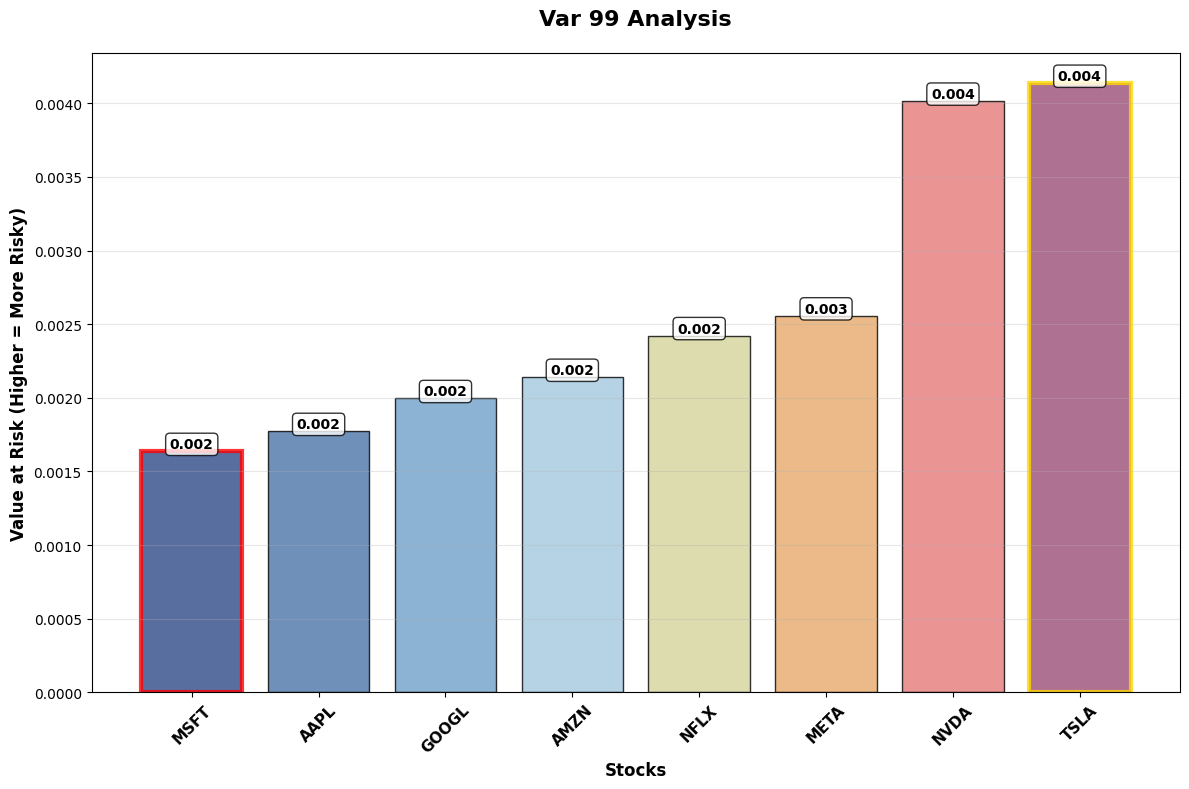

[6/6] Creating plot for daily_volatility...


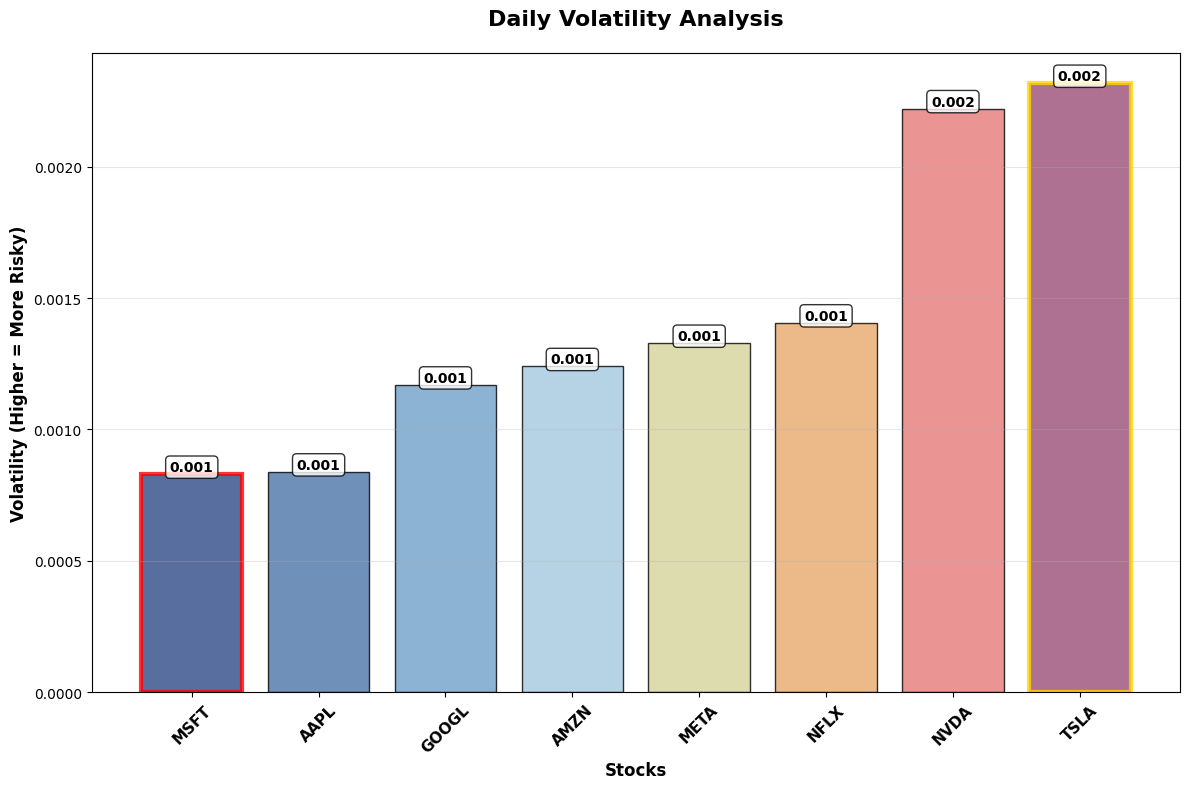


💾 Results saved to: market_volatility_ranking_volatility_ranking_20250611_144416.csv


In [3]:
import pandas as pd
import numpy as np
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class VolatilityRankingAnalyzer:
    def __init__(self, db_config):
        """
        PostgreSQL 변동성 순위 분석기 초기화
        
        db_config 예시:
        {
            'host': '192.168.40.193',
            'database': 'minute',
            'user': 'postgres',
            'password': 'mysecretpassword',
            'port': 5432
        }
        """
        self.db_config = db_config
        self.engine = self._create_connection()
        
        # 변동성 지표 중요도 가중치 (순위별)
        self.volatility_weights = {
            'annual_volatility': 9.5,      # 1위
            'sharpe_ratio': 9.0,           # 2위  
            'max_drawdown': 8.5,           # 3위
            'var_95': 8.0,                 # 4위
            'var_99': 8.0,                 # 4위 (동점)
            'daily_volatility': 7.5,       # 5위
            'price_range_pct': 7.0,        # 6위
            'log_volatility': 6.5,         # 7위
            'skewness': 6.0,               # 8위
            'kurtosis': 5.5                # 9위
        }
        
        # 커스텀 컬러 팔레트 (이미지 스타일과 유사)
        self.custom_colors = [
            '#2E4A87',  # 진한 파랑 (MSFT)
            '#4A74A8',  # 중간 파랑 (AAPL)
            '#6FA0C9',  # 연한 파랑 (GOOGL)
            '#A4C8E0',  # 아주 연한 파랑 (AMZN)
            '#D4D49A',  # 연한 노랑 (NFLX)
            '#E6A96B',  # 연한 주황 (META)
            '#E57A7A',  # 연한 빨강 (NVDA)
            '#9B4D77'   # 진한 자주 (TSLA)
        ]
        
    def _create_connection(self):
        """PostgreSQL 데이터베이스 연결 생성"""
        try:
            connection_string = f"postgresql://{self.db_config['user']}:{self.db_config['password']}@{self.db_config['host']}:{self.db_config['port']}/{self.db_config['database']}"
            engine = create_engine(connection_string)
            print(f"✅ Database connection established: {self.db_config['host']}:{self.db_config['port']}")
            return engine
        except Exception as e:
            print(f"❌ Database connection failed: {e}")
            raise
    
    def fetch_market_data(self, start_date, end_date=None, symbols=None):
        """PostgreSQL에서 시장 데이터 가져오기"""
        
        base_query = """
        SELECT 
            date, symbol, open, high, low, close, volume
        FROM us_market_data 
        WHERE date >= %(start_date)s
        """
        
        params = {'start_date': start_date}
        
        if end_date:
            base_query += " AND date <= %(end_date)s"
            params['end_date'] = end_date
            
        if symbols:
            # WHERE symbol IN ('AAPL', 'MSFT', ...) 형태로 생성
            symbol_placeholders = ','.join([f"'{symbol}'" for symbol in symbols])
            base_query += f" AND symbol IN ({symbol_placeholders})"
            
        base_query += " ORDER BY symbol, date"
        
        try:
            print(f"🔍 Fetching data from PostgreSQL...")
            print(f"   Start date: {start_date}")
            if end_date:
                print(f"   End date: {end_date}")
            if symbols:
                print(f"   Symbols: {symbols}")
            
            df = pd.read_sql_query(base_query, self.engine, params=params)
            df['date'] = pd.to_datetime(df['date'])
            
            if not df.empty:
                print(f"✅ Successfully fetched {len(df)} records")
                print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
                print(f"   Symbols: {df['symbol'].nunique()} ({df['symbol'].unique()})")
            else:
                print("❌ No data found with given criteria")
                
            return df
            
        except Exception as e:
            print(f"❌ Error fetching data: {e}")
            return pd.DataFrame()
    
    def fetch_symbol_data(self, symbol, start_date, end_date=None):
        """특정 심볼의 데이터만 가져오기"""
        
        query = """
        SELECT 
            *
        FROM us_market_data 
        WHERE symbol = %(symbol)s
        AND date >= %(start_date)s
        """
        
        params = {
            'symbol': symbol,
            'start_date': start_date
        }
        
        if end_date:
            query += " AND date <= %(end_date)s"
            params['end_date'] = end_date
            
        query += " ORDER BY date"
        
        try:
            df = pd.read_sql_query(query, self.engine, params=params)
            df['date'] = pd.to_datetime(df['date'])
            print(f"✅ {symbol}: {len(df)} records fetched")
            return df
            
        except Exception as e:
            print(f"❌ Error fetching {symbol}: {e}")
            return pd.DataFrame()
    
    def calculate_returns(self, df):
        """수익률 및 기본 지표 계산"""
        if df.empty:
            return df
            
        df = df.copy()
        df = df.sort_values(['symbol', 'date'])
        
        # 심볼별로 그룹화하여 계산
        df['prev_close'] = df.groupby('symbol')['close'].shift(1)
        
        # 일일 수익률
        df['daily_return'] = (df['close'] - df['prev_close']) / df['prev_close']
        
        # 로그 수익률
        df['log_return'] = np.log(df['close'] / df['prev_close'])
        
        # 가격 변동폭
        df['price_range'] = df['high'] - df['low']
        df['price_range_pct'] = df['price_range'] / df['close']
        
        # NaN 제거
        df = df.dropna(subset=['daily_return'])
        
        print(f"📊 Returns calculated for {len(df)} records")
        return df
    
    def calculate_volatility_metrics_by_symbol(self, symbol, start_date, end_date=None):
        """개별 심볼의 변동성 지표 계산"""
        
        # 해당 심볼 데이터 가져오기
        symbol_df = self.fetch_symbol_data(symbol, start_date, end_date)
        
        if symbol_df.empty or len(symbol_df) < 30:
            print(f"⚠️  {symbol}: Insufficient data ({len(symbol_df)} records)")
            return None
        
        # 수익률 계산
        symbol_df = self.calculate_returns(symbol_df)
        
        if symbol_df.empty:
            return None
            
        returns = symbol_df['daily_return'].dropna()
        log_returns = symbol_df['log_return'].dropna()
        
        if len(returns) < 10:
            print(f"⚠️  {symbol}: Insufficient return data ({len(returns)} points)")
            return None
        
        try:
            # 1위: Annual Volatility (연간 변동성)
            daily_vol = returns.std()
            annual_vol = daily_vol * np.sqrt(252)
            
            # 2위: Sharpe Ratio (샤프 비율)
            avg_return = returns.mean()
            sharpe = (avg_return / daily_vol * np.sqrt(252)) if daily_vol > 0 else 0
            
            # 3위: Maximum Drawdown (최대 손실폭)
            cumulative_returns = (1 + returns).cumprod()
            rolling_max = cumulative_returns.expanding().max()
            drawdown = (cumulative_returns - rolling_max) / rolling_max
            max_dd = abs(drawdown.min())
            
            # 4위: VaR (Value at Risk)
            var_95 = abs(returns.quantile(0.05))
            var_99 = abs(returns.quantile(0.01))
            
            # 5위: Daily Volatility (일일 변동성)
            daily_volatility = daily_vol
            
            # 6위: Price Range Percentage (가격 변동폭 비율)
            avg_price_range_pct = symbol_df['price_range_pct'].mean()
            
            # 7위: Log Volatility (로그 변동성)
            log_vol = log_returns.std()
            annual_log_vol = log_vol * np.sqrt(252)
            
            # 8위: Skewness (왜도)
            skew = abs(returns.skew())
            
            # 9위: Kurtosis (첨도)
            kurt = abs(returns.kurtosis())
            
            # 결과 반환
            result = {
                'symbol': symbol,
                'data_points': len(returns),
                'period_start': symbol_df['date'].min().strftime('%Y-%m-%d'),
                'period_end': symbol_df['date'].max().strftime('%Y-%m-%d'),
                
                # 순위별 변동성 지표
                'annual_volatility': annual_vol,
                'sharpe_ratio': sharpe,
                'max_drawdown': max_dd,
                'var_95': var_95,
                'var_99': var_99,
                'daily_volatility': daily_volatility,
                'price_range_pct': avg_price_range_pct,
                'log_volatility': annual_log_vol,
                'skewness': skew,
                'kurtosis': kurt,
                
                # 기본 통계
                'avg_daily_return': avg_return,
                'total_return': (symbol_df['close'].iloc[-1] / symbol_df['close'].iloc[0] - 1),
                'min_return': returns.min(),
                'max_return': returns.max(),
                'avg_volume': symbol_df['volume'].mean()
            }
            
            print(f"✅ {symbol}: Volatility metrics calculated")
            return result
            
        except Exception as e:
            print(f"❌ Error calculating metrics for {symbol}: {e}")
            return None
    
    def calculate_all_volatility_metrics(self, symbols, start_date, end_date=None):
        """모든 심볼의 변동성 지표 계산"""
        
        print(f"🔄 Processing {len(symbols)} symbols...")
        results = []
        
        for i, symbol in enumerate(symbols, 1):
            print(f"[{i}/{len(symbols)}] Processing {symbol}...")
            
            metrics = self.calculate_volatility_metrics_by_symbol(symbol, start_date, end_date)
            
            if metrics:
                results.append(metrics)
            
        if results:
            df = pd.DataFrame(results)
            print(f"✅ Successfully processed {len(results)} symbols")
            return df
        else:
            print("❌ No volatility metrics calculated")
            return pd.DataFrame()
    
    def create_volatility_ranking(self, metrics_df):
        """변동성 지표 기반 종합 순위 생성"""
        if metrics_df.empty:
            return pd.DataFrame()
        
        ranking_df = metrics_df.copy()
        volatility_cols = list(self.volatility_weights.keys())
        
        print("📊 Creating volatility rankings...")
        
        # 각 지표별 순위 계산
        for col in volatility_cols:
            if col in ranking_df.columns:
                if col == 'sharpe_ratio':
                    # Sharpe Ratio는 높을수록 좋음 (역순)
                    ranking_df[f'{col}_rank'] = ranking_df[col].rank(ascending=False)
                else:
                    # 나머지 변동성 지표들은 높을수록 위험함 (정순)
                    ranking_df[f'{col}_rank'] = ranking_df[col].rank(ascending=False)
        
        # 가중 점수 계산
        ranking_df['weighted_score'] = 0
        ranking_df['total_weight'] = 0
        
        for col, weight in self.volatility_weights.items():
            rank_col = f'{col}_rank'
            if rank_col in ranking_df.columns:
                # 순위를 점수로 변환 (1위=10점, 꼴지=1점)
                max_rank = len(ranking_df)
                points = (max_rank + 1 - ranking_df[rank_col]) / max_rank * 10
                ranking_df['weighted_score'] += points * weight
                ranking_df['total_weight'] += weight
        
        # 최종 점수 계산 (0-10 스케일)
        ranking_df['final_score'] = ranking_df['weighted_score'] / ranking_df['total_weight']
        ranking_df['overall_rank'] = ranking_df['final_score'].rank(ascending=False)
        
        # 정렬
        ranking_df = ranking_df.sort_values('overall_rank')
        
        print("✅ Volatility ranking completed")
        return ranking_df
    
    def get_symbol_color(self, symbol, sorted_symbols):
        """심볼에 따른 색상 반환"""
        try:
            # 정렬된 심볼 리스트에서 해당 심볼의 인덱스 찾기
            idx = sorted_symbols.index(symbol)
            # 인덱스가 색상 리스트 길이를 초과하면 순환
            return self.custom_colors[idx % len(self.custom_colors)]
        except (ValueError, IndexError):
            # 기본 색상 반환
            return '#4A74A8'
    
    def create_individual_metric_plot(self, ranking_df, metric, plot_title=None):
        """개별 지표에 대한 플롯 생성"""
        if ranking_df.empty or metric not in ranking_df.columns:
            print(f"❌ Cannot create plot for {metric}: Data not available")
            return
        
        # 데이터 정렬 (해당 지표 기준)
        sorted_data = ranking_df.sort_values(metric, ascending=True)
        
        # 플롯 생성
        plt.figure(figsize=(12, 8))
        
        # 커스텀 색상 적용
        colors = [self.get_symbol_color(symbol, sorted_data['symbol'].tolist()) 
                 for symbol in sorted_data['symbol']]
        
        # 바 차트
        bars = plt.bar(range(len(sorted_data)), sorted_data[metric], 
                      color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        
        # 제목과 축 설정
        if plot_title is None:
            metric_name = metric.replace('_', ' ').title()
            plot_title = f'{metric_name} Analysis'
        
        plt.title(plot_title, fontweight='bold', fontsize=16, pad=20)
        plt.xlabel('Stocks', fontweight='bold', fontsize=12)
        
        # Y축 라벨 설정
        if metric == 'sharpe_ratio':
            plt.ylabel('Sharpe Ratio (Higher = Better)', fontweight='bold', fontsize=12)
        elif 'volatility' in metric:
            plt.ylabel('Volatility (Higher = More Risky)', fontweight='bold', fontsize=12)
        elif metric == 'max_drawdown':
            plt.ylabel('Maximum Drawdown (Higher = More Risky)', fontweight='bold', fontsize=12)
        elif 'var' in metric:
            plt.ylabel('Value at Risk (Higher = More Risky)', fontweight='bold', fontsize=12)
        else:
            plt.ylabel('Value', fontweight='bold', fontsize=12)
        
        # X축 설정
        plt.xticks(range(len(sorted_data)), sorted_data['symbol'], 
                  rotation=45, fontsize=11, fontweight='bold')
        
        # 그리드 추가
        plt.grid(True, alpha=0.3, axis='y')
        
        # 값 표시
        for i, (bar, value) in enumerate(zip(bars, sorted_data[metric])):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.3f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        # 최고/최저 강조
        if len(sorted_data) > 0:
            best_idx = 0 if metric == 'sharpe_ratio' else len(sorted_data) - 1
            worst_idx = len(sorted_data) - 1 if metric == 'sharpe_ratio' else 0
            
            # 테두리 강조
            bars[best_idx].set_edgecolor('gold')
            bars[best_idx].set_linewidth(3)
            bars[worst_idx].set_edgecolor('red')
            bars[worst_idx].set_linewidth(3)
        
        plt.tight_layout()
        plt.show()
        
    def create_all_individual_plots(self, ranking_df):
        """모든 주요 지표에 대한 개별 플롯 생성"""
        if ranking_df.empty:
            print("❌ No data to visualize")
            return
        
        # 주요 6개 지표 (중요도 순위별)
        main_metrics = ['annual_volatility', 'sharpe_ratio', 'max_drawdown', 
                       'var_95', 'var_99', 'daily_volatility']
        
        print("📊 Creating individual volatility plots...")
        
        for i, metric in enumerate(main_metrics, 1):
            if metric in ranking_df.columns:
                print(f"[{i}/{len(main_metrics)}] Creating plot for {metric}...")
                self.create_individual_metric_plot(ranking_df, metric)
            else:
                print(f"⚠️  Skipping {metric}: Not found in data")
    
    def create_comprehensive_overview_plot(self, ranking_df):
        """종합 순위 개요 플롯"""
        if ranking_df.empty:
            print("❌ No data to visualize")
            return
        
        # 최종 점수 기준으로 정렬
        sorted_data = ranking_df.sort_values('final_score', ascending=False)
        
        plt.figure(figsize=(14, 10))
        
        # 커스텀 색상 적용
        colors = [self.get_symbol_color(symbol, sorted_data['symbol'].tolist()) 
                 for symbol in sorted_data['symbol']]
        
        # 바 차트
        bars = plt.bar(range(len(sorted_data)), sorted_data['final_score'], 
                      color=colors, alpha=0.8, edgecolor='black', linewidth=1)
        
        # 제목 설정
        plt.title('Comprehensive Volatility Ranking\n(Weighted Score Based on All Metrics)', 
                 fontweight='bold', fontsize=18, pad=20)
        plt.xlabel('Stocks (Ranked by Overall Performance)', fontweight='bold', fontsize=14)
        plt.ylabel('Weighted Volatility Score (0-10)', fontweight='bold', fontsize=14)
        
        # X축 설정
        plt.xticks(range(len(sorted_data)), sorted_data['symbol'], 
                  rotation=45, fontsize=12, fontweight='bold')
        
        # 그리드 추가
        plt.grid(True, alpha=0.3, axis='y')
        
        # 점수 표시
        for i, (bar, value, rank) in enumerate(zip(bars, sorted_data['final_score'], sorted_data['overall_rank'])):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'#{int(rank)}\n{value:.2f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))
        
        # 1위와 꼴찌 강조
        if len(bars) > 0:
            bars[0].set_edgecolor('gold')
            bars[0].set_linewidth(4)
            if len(bars) > 1:
                bars[-1].set_edgecolor('red')
                bars[-1].set_linewidth(3)
        
        # 범례 추가
        plt.figtext(0.02, 0.02, 
                   'Note: Lower volatility generally indicates better risk-adjusted performance\n'
                   'Gold border = Best performer, Red border = Highest risk',
                   fontsize=10, style='italic')
        
        plt.tight_layout()
        plt.show()
    
    def generate_ranking_report(self, symbols, start_date, end_date=None, save_to_file=None):
        """종합 변동성 순위 보고서 생성"""
        
        print("="*70)
        print("🏆 MARKET VOLATILITY RANKING ANALYSIS REPORT")
        print("="*70)
        print(f"📅 Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"📊 Database: {self.db_config['host']}:{self.db_config['port']}/{self.db_config['database']}")
        print(f"📈 Period: {start_date} ~ {end_date or 'Latest'}")
        print(f"🎯 Symbols: {symbols}")
        print("-"*70)
        
        # 변동성 지표 중요도 출력
        print("\n📋 VOLATILITY METRICS IMPORTANCE RANKING:")
        print("-"*50)
        for i, (metric, weight) in enumerate(self.volatility_weights.items(), 1):
            metric_name = metric.replace('_', ' ').title()
            print(f"{i:2d}. {metric_name:<25} (Weight: {weight:4.1f}/10)")
        
        # 변동성 지표 계산
        metrics_df = self.calculate_all_volatility_metrics(symbols, start_date, end_date)
        
        if metrics_df.empty:
            print("\n❌ No volatility metrics could be calculated")
            return None
        
        # 순위 생성
        ranking_df = self.create_volatility_ranking(metrics_df)
        
        # 결과 출력
        print(f"\n🏆 STOCK VOLATILITY RANKING (Weighted Score):")
        print("-"*80)
        print(f"{'Rank':<4} {'Symbol':<8} {'Score':<8} {'AnnVol':<8} {'Sharpe':<8} {'MaxDD':<8} {'VaR95':<8}")
        print("-"*80)
        
        for _, row in ranking_df.iterrows():
            print(f"{int(row['overall_rank']):2d}   {row['symbol']:<8} "
                  f"{row['final_score']:6.2f}   "
                  f"{row['annual_volatility']:6.3f}   "
                  f"{row['sharpe_ratio']:6.3f}   "
                  f"{row['max_drawdown']:6.3f}   "
                  f"{row['var_95']:6.3f}")
        
        # 상세 분석
        print(f"\n📊 DETAILED ANALYSIS:")
        print("-"*50)
        best_performer = ranking_df.iloc[0]
        worst_performer = ranking_df.iloc[-1]
        
        print(f"🥇 Best Overall: {best_performer['symbol']} (Score: {best_performer['final_score']:.2f})")
        print(f"🥉 Worst Overall: {worst_performer['symbol']} (Score: {worst_performer['final_score']:.2f})")
        
        # 각 지표별 1위
        print(f"\n🏅 INDIVIDUAL METRIC LEADERS:")
        print("-"*30)
        for metric in ['annual_volatility', 'sharpe_ratio', 'max_drawdown', 'var_95']:
            if metric == 'sharpe_ratio':
                leader = ranking_df.loc[ranking_df[metric].idxmax()]
                print(f"• Best {metric.replace('_', ' ').title()}: {leader['symbol']} ({leader[metric]:.3f})")
            else:
                leader = ranking_df.loc[ranking_df[metric].idxmax()]
                print(f"• Highest {metric.replace('_', ' ').title()}: {leader['symbol']} ({leader[metric]:.3f})")
        
        # 개별 시각화 (각 플롯을 따로 생성)
        print("\n📊 Generating individual metric visualizations...")
        self.create_comprehensive_overview_plot(ranking_df)
        self.create_all_individual_plots(ranking_df)
        
        # 파일 저장
        if save_to_file:
            try:
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                filename = f"{save_to_file}_volatility_ranking_{timestamp}.csv"
                ranking_df.to_csv(filename, index=False)
                print(f"\n💾 Results saved to: {filename}")
            except Exception as e:
                print(f"❌ Error saving file: {e}")
        
        print("="*70)
        
        return ranking_df

# 사용 예시
def main():
    """메인 실행 함수"""
    
    # PostgreSQL 데이터베이스 설정
    db_config = {
        'host': '192.168.40.193',
        'database': 'minute', 
        'user': 'postgres',
        'password': 'mysecretpassword',
        'port': 5432
    }
    
    try:
        # 분석기 초기화
        analyzer = VolatilityRankingAnalyzer(db_config)
        
        # 분석할 종목들
        symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'NFLX']
        
        # 분석 기간 설정
        start_date = '2024-01-01'
        end_date = '2025-01-01'  # 선택사항
        
        # 종합 순위 분석 실행
        ranking_results = analyzer.generate_ranking_report(
            symbols=symbols,
            start_date=start_date,
            end_date=end_date,
            save_to_file='market_volatility_ranking'
        )
        
        return ranking_results
        
    except Exception as e:
        print(f"❌ Error in main execution: {e}")
        return None

if __name__ == "__main__":
    # 실행
    results = main()

In [1]:
import alpaca_trade_api as tradeapi

# API 키 설정 (자신의 키로 바꿔주세요)
API_KEY = 'PK5SQ65O444Z6PRDV4UI'
SECRET_KEY = 'GIavNSovfJIwAnVZC14DI73pBhNBcAuY2CGhOKl5'
BASE_URL = 'https://paper-api.alpaca.markets'  # 페이퍼 트레이딩 URL

# API 객체 생성
api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

# 1. 모든 미체결 주문 취소
def cancel_all_orders():
    print("모든 미체결 주문 취소 중...")
    orders = api.list_orders(status='open')
    for order in orders:
        print(f"취소: {order.symbol} 주문")
        api.cancel_order(order.id)

# 2. 모든 포지션 청산
def close_all_positions():
    print("모든 포지션 청산 중...")
    positions = api.list_positions()
    for position in positions:
        symbol = position.symbol
        qty = abs(float(position.qty))
        side = 'sell' if position.side == 'long' else 'buy'
        print(f"{symbol} - {side} {qty}")
        api.submit_order(
            symbol=symbol,
            qty=qty,
            side=side,
            type='market',
            time_in_force='day'
        )

if __name__ == "__main__":
    cancel_all_orders()
    close_all_positions()
    print("페이퍼 트레이딩 계정 초기화 완료.")


모든 미체결 주문 취소 중...
모든 포지션 청산 중...
TSLA - sell 154.00474375
페이퍼 트레이딩 계정 초기화 완료.
